In [156]:
from pathlib import Path 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import sys
import os
import seaborn as sns
import researchpy as rp
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.nonparametric.smoothers_lowess import lowess

#sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

In [40]:
snap = pd.read_csv(Path(data_derived, 'snap_14_and_mediators.csv'))
ssrs = pd.read_csv(Path(data_derived, 'ssrs_14_and_mediators.csv'))
masc = pd.read_csv(Path(data_derived, 'masc_14_and_mediators.csv'))
pc = pd.read_csv(Path(data_derived, 'pc_14_and_mediators.csv'))
qsts =['snap', 'ssrs', 'masc', 'pc']
data_dict = dict(zip(['snap', 'ssrs', 'masc', 'pc'], [snap, ssrs, masc, pc]))

In [62]:
#remove subjects from the 'assessemnt' period (before baseline)
for key, df in data_dict.items():
    data_dict[key] = df[(df['trtname'] != 'A') & (df['days_baseline']>=0)].copy() 


In [63]:
data_dict['snap']['trtname'].unique()

array(['C', 'M', 'P'], dtype=object)

In [64]:
interaction_predictors = ['days_baseline', 'site', 'trtname'] #time, site, treatment group

# mediator variables
comorb_mediators  = ['cdorodd' , 'pso', 'psoi', 'pag', 'pagi', 'pga', 'pgai' ,'psa'] #ODD/CD or anx excluding specific phobia 
services_mediators =  ['demo61'] #reciept of public assistance 
prev_med_mediators = ['hi_24'] #medication intake prior to study 

#moderator variables 
accept_moderator = ['d2dresp'] # initail acceptance of treatment 
raters = ['Teacher', 'Parent']

med_mod_list = np.concatenate([[comorb_mediators[0]], ['anx'], services_mediators, prev_med_mediators, accept_moderator, ['sex']])
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [66]:
comorb = pd.read_csv(Path(data_derived, 'comorb.csv'), index_col= 0) # comorbid ODD/CD anxiety
prev_med = pd.read_csv(Path(data_derived, 'prev_med.csv'), index_col= 0) #'prevous stimulant medictaion exposure
assist = pd.read_csv(Path(data_derived, 'assist.csv'), index_col= 0) #reciept of public assistance 
accept = pd.read_csv(Path(data_derived, 'accept.csv'), index_col= 0) #initial acceptance of treatment arm
medi = {'comorb': comorb, 'prev_med': prev_med, 'assist': assist, 'accept': accept}

In [67]:

interaction_predictors = ['days_baseline', 'site', 'trtname'] #time, site, treatment group
#outcome variablles 
snap_vars = ['snainatx', 'snahypax', 'snaoddx'] #inattention_mean, hyperactie mean
ssrs_vars = ['sspintx', 'ssptossx']# social skills mean, internalizing mean 
masc_vars = ['masc_masctotalt']
pc_vars = ['pcrcpax', 'pcrcprx'] # power assertion, personal closeness
#wechsler_vars = ['w1readb','w2math','w3spell' ]
outcomes = np.concatenate([snap_vars, ssrs_vars, masc_vars, pc_vars])

outcomes_dict  = {'snap' : snap_vars, 'ssrs' : ssrs_vars, 'masc': masc_vars, 'pc': pc_vars}#, 'wechsler': wechsler_vars}

### Fig params 

In [144]:
#outcome variables 
outcomes_written = ['SNAP Inattention', 'SNAP Hyperactivity', 'SNAP Aggressive','SSRS Social Skills', 'SSRS Internalizing', 'MASC total Score', 'Parent-Child Power Assertion', 'Parent-Child Personal Closeness' ]
outcomes_dict_fig = dict(zip(outcomes, outcomes_written))
outcomes_dict_fig

# treatment names 
trt_dict = {'M': 'Medication Management', 'P': 'Behavioral Treatment', 'C': 'Combined Treatment'}

#mediators 
med_written = ['CD or ODD', 'Anxiety', 'Public Assistance', 'Prior Medication', 'Initial Acceptance of Treatment Arm', 'Sex']
med_options = [['No', ''],['No', ''] ,['No', ''],['No', ''], ['Low', 'High'], ['Male', 'Female']]

# mediator variable names spelled out 
med_dict_fig = {} #for figure titles 
options_dict = {}
for i, med in enumerate(med_mod_list):
    med_dict_fig[med] = [med_options[i][j] + ' ' + med_written[i] for j in range(2)]
med_dict_fig

# outcome values for mediators and moderators 
values_possible = [[0,1],[0,1],[1,2],[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6] ,['M', 'F']]
values_possible
med_values = dict(zip(med_mod_list, values_possible))
med_values

{'cdorodd': [0, 1],
 'anx': [0, 1],
 'demo61': [1, 2],
 'hi_24': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'd2dresp': [1, 2, 3, 4, 5, 6],
 'sex': ['M', 'F']}

### RR analysis, including each mediator as main effect and in interaction : if significant plot 

In [69]:
gen_interact_formula = ' days_baseline + C(site) + C(trtname)' # reapeat with log days 


In [70]:
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [71]:
#include mediators and moderator as main effect and in interaction 
gen_med_formulas = [ gen_interact_formula +' * '+  str(med) for med in med_mod_list]
gen_med_formulas

formulas =  [[[' ~ '.join((var, gen_med_form)) for var in values] for gen_med_form in gen_med_formulas] for values in outcomes_dict.values()] 
formulas_dict = dict(zip(outcomes_dict.keys(), formulas))
formulas_dict

{'snap': [['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
   'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
   'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
  ['snainatx ~  days_baseline + C(site

In [72]:
groups = 'src_subject_id'
alpha = 0.05
raters = ['Teacher', 'Parent']

In [73]:
formulas_dict['snap']

[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
  'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
  'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * sex',
 

## SNAP

In [74]:
formulas_snap = formulas_dict['snap']
formulas_snap

[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
  'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
  'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * sex',
 

In [75]:
data_dict['snap'].trtname.unique()

array(['C', 'M', 'P'], dtype=object)

In [76]:
interaction_predictors

['days_baseline', 'site', 'trtname']

In [77]:
formulas

[[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
   'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
   'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
  ['snainatx ~  days_baseline + C(site) + C(tr

In [78]:
for qst in data_dict.keys():
    print((qst))
    print((data_dict[qst]['days_baseline'].value_counts() < 0).sum())
    print('L', (data_dict[qst][ (data_dict[qst]['trtname'] == 'L') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('M', (data_dict[qst][ (data_dict[qst]['trtname'] == 'M') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('P', (data_dict[qst][ (data_dict[qst]['trtname'] == 'P') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('C', (data_dict[qst][ (data_dict[qst]['trtname'] == 'C') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('A', (data_dict[qst][ (data_dict[qst]['trtname'] == 'A') &(data_dict[qst]['days_baseline'] >=0)].shape))
    

snap
0
L (0, 17)
M (977, 17)
P (1118, 17)
C (1135, 17)
A (0, 17)
ssrs
0
L (0, 16)
M (988, 16)
P (1114, 16)
C (1135, 16)
A (0, 16)
masc
0
L (0, 14)
M (333, 14)
P (382, 14)
C (372, 14)
A (0, 14)
pc
0
L (0, 15)
M (1211, 15)
P (1359, 15)
C (1382, 15)
A (0, 15)


In [79]:
#for snap and ssrs, teacher and parent rater separated 

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results_s = {}
for i, qst in enumerate(['snap', 'ssrs']) :

    results_rater = {}
    for rater in raters: 
        results_ = {}
        
        for j, med in enumerate(med_mod_list):
            
            for k, var in enumerate(outcomes_dict[qst]):
                cols_total = np.concatenate([cols, [med, var]])
                print(cols_total)
                formula = formulas[i][j][k]
                data = data_dict[qst][(data_dict[qst]['version_form'] == rater) & (data_dict[qst][cols_total].notna().all(axis=1))]
                print(data.shape)
                groups = data['src_subject_id']
                result = smf.mixedlm(formula, data, groups = groups).fit()
                results_[str(med) + '_' + str(var) ] = result
                
        results_rater[rater] = results_
        
    results_s[qst] = results_rater

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
(1122, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snaoddx']
(1141, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snainatx']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snahypax']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snaoddx']
(1071, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snainatx']
(151, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snahypax']
(151, 17)
['src_subject_id' 'days_baseline' 'site' 'trtnam

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snainatx']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snahypax']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snaoddx']
(953, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snainatx']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snahypax']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snaoddx']
(1159, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
(1983, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
(2038, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
(2038, 17)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snaoddx']
(2038, 17)
['src_subject_id' 'days

In [80]:
results_s

{'snap': {'Teacher': {'cdorodd_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fd1d584c0>,
   'cdorodd_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fc31da440>,
   'cdorodd_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fd1e0f130>,
   'anx_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fd1e0e3b0>,
   'anx_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fc552ab00>,
   'anx_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fc552bdc0>,
   'demo61_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fc552a950>,
   'demo61_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fc552b5e0>,
   'demo61_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f7fc552a290>,
   'hi_24_snainatx': <stats

In [81]:
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [82]:
len(formulas)

4

In [145]:
# for masc and pc, no rater 

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results_m = {}
for i, qst in enumerate(['masc', 'pc']) :
    results_ = {}
    for j, med in enumerate(med_mod_list):

        for k, var in enumerate(outcomes_dict[qst]):
            cols_total = np.concatenate([cols, [med, var]])
            print(cols_total)
            formula = formulas[i+2][j][k]
            data = data_dict[qst][cols_total].dropna()
            groups = data['src_subject_id']
            result = smf.mixedlm(formula, data, groups = groups).fit()
            results_[str(med) + '_' + str(var) ] = result
    results_m[qst] = results_
            
        

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'h

In [84]:
results = {'snap': results_s['snap'], 'ssrs' : results_s['ssrs'], 'masc': results_m['masc'], 'pc': results_m['pc'] }

In [85]:
results['masc'].keys()

dict_keys(['cdorodd_masc_masctotalt', 'anx_masc_masctotalt', 'demo61_masc_masctotalt', 'hi_24_masc_masctotalt', 'd2dresp_masc_masctotalt', 'sex_masc_masctotalt'])

In [86]:
def split_on_occurrence(s, char, occurrence=1):
    if occurrence == 1:
        # Find the index of the first occurrence of the character
        index = s.find(char)
    elif occurrence == 2:
        # Find the index of the second occurrence of the character
        first_occurrence = s.find(char)
        index = s.find(char, first_occurrence + 1)
    else:
        raise ValueError("Occurrence must be 1 or 2")

    # If the occurrence is found, split the string
    if index != -1:
        return s[:index], s[index+1:]
    else:
        # If the occurrence isn't found, return the original string
        return s, ''

In [87]:
# for qst in qsts:
#     for key in results[qst].keys():
#         if not (key.startswith('hi') or 'masc' in key):
#             var_mod = key.split('_')[0]
#             var_out =  key.split('_')[1]
#         elif key.startswith('hi'):
#             var_mod = split_on_occurrence(key, '_', 2)[0]
#             var_out= split_on_occurrence(key, '_', 2)[1]
#         else: 
#             var_mod = split_on_occurrence(key, '_', 1)[0]
#             var_out= split_on_occurrence(key, '_', 1)[1]
#         title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
#         # print(title[0])
#         # print(title[1])
#         print(med_dict_fig[var_mod][1],var_mod, data_dict[qst][var_mod].unique())
#         # data = data_dict[qst]
#         # result = results[qst][key]
#         # data_dict[qst]['predicted'] = result.predict(data)
 
        
            

### Values of moderators : 
cd or ODD : 0=No; 1=Yes \
anx : 0=No; 1=Yes \
public assistance 
sex : 'M' = male, 'F'= female \
Public assistance : 1 = None, does not work; 2 = Less than $10,000; 3 = $10,001 to $20,000; 4 = $20,001 to $30,000; 5 = $30,001 to $40,000; 6 = $40,001 to $50,000; 7 = $50,001 to $60,000; 8 = $60,001 to $70,000; 9 = $70,001 to $80,000; 10 = $80,001 or more\
acceptance : 1=Very disappointed-serious reservations about continuing; 2=Moderately disappointed-some reservations but stated willingness to follow the protocol; 3=Guarded-no obvious reaction one way or the other; 4=Accepting or neutral-no stated reservations; 5=Generally positive about the outcome-moderate level of enthusiasm; 6=Very positive-happy/relieved/enthusiastic and no reservations about full commitment to the study


SNAP inatt 
SNAP hap 
SNAP odd 
SSRS int 
SSRS ss 
MASC total 
PC dominance 
PC closeness 

## 1. Plot dichotomus mediator variables : CD or ODD / ANX / SEX 

In [88]:
# for qst in qsts:
#     for key in results[qst].keys():
#         data = data_dict[qst]
#         result = results[qst][key]
#         data_dict[qst]['predicted'] = result.predict(data)
#     print(data_dict[qst]['predicted'].shape)

In [121]:
qst = 'snap'
var_mod = 'anx'
var_out = 'snahypax'
var_result = var_mod + '_' + var_out
version_form_fig = 'Parent'
title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
values = med_values[var_mod]
print(title)
print(values)

print(var_result)
if version_form_fig is not None:
    result = results[qst][rater][var_result]
else:
    result = results[qst][var_result]
data = data_dict[qst]
data['predicted'] = result.predict(data)


['14-Month Outcomes \n No Anxiety \n SNAP Hyperactivity', '14-Month Outcomes \n  Anxiety \n SNAP Hyperactivity']
[0, 1]
anx_snahypax


In [106]:

y_lim = [0,3]
x_lim = [-10, 450]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


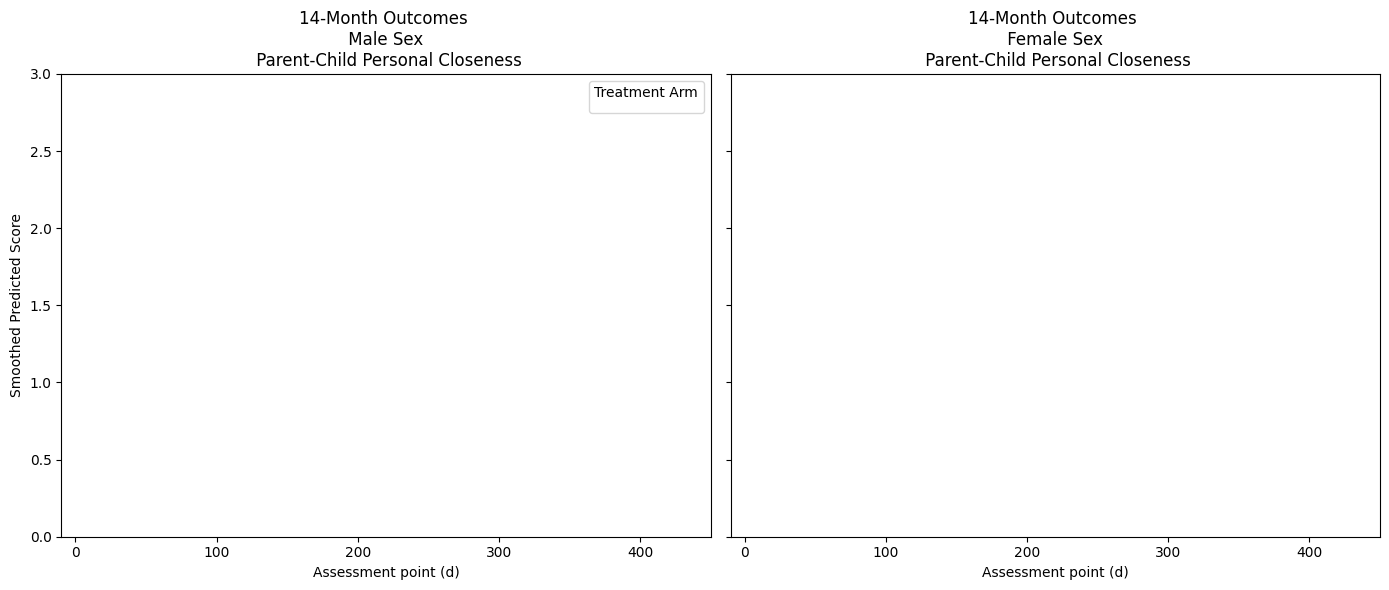

In [163]:

# Apply LOESS smoothing for "No Anxiety" and "Anxiety" subgroups, and filter for days_baseline >= 0
no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

# Create subplots (1 row, 2 columns) with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for "No Anxiety" subgroup
for trt in no_mod['trtname'].unique():
    subset = no_mod[no_mod['trtname'] == trt]
    smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
    axes[0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt])

axes[0].set_title(title[0])
axes[0].set_xlabel('Assessment point (d)')
axes[0].set_ylabel('Smoothed Predicted Score')
axes[0].legend(title='Treatment Arm')
axes[0].set_xlim(x_lim)  # Set x-axis from 0 to 450
axes[0].set_ylim(y_lim)    # Set y-axis from 0 to 3

# Plot for "Anxiety" subgroup
for trt in yes_mod['trtname'].unique():
    subset = yes_mod[yes_mod['trtname'] == trt]
    smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
    axes[1].plot(smoothed[:, 0], smoothed[:, 1],label=trt_dict[trt])

axes[1].set_title(title[1])
axes[1].set_xlabel('Assessment point (d)')
axes[1].set_xlim(x_lim)  # Set x-axis from 0 to 450
axes[1].set_ylim(y_lim)   # Ensure y-axis is from 0 to 3

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
def plot_RR_curves_med_mod_test(data, var_mod, var_out, results, outcomes_dict_fig, med_dict_fig , med_values, xlim, ylim, rater = None):
    
    var_result = var_mod + '_' + var_out
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    values = med_values[var_mod]
    result = results[var_result]
    data = data_dict[qst]
    data['predicted'] = result.predict(data)


    # Apply LOESS smoothing for "No Anxiety" and "Anxiety" subgroups, and filter for days_baseline >= 0
    no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
    yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

    # Create subplots (1 row, 2 columns) with shared y-axis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]
 
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)  # Convert warnings to exceptions
                smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
                axes[0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt]+ ' (n = {})'.format(n))
        except RuntimeWarning:
            sns.lineplot(data=data[data[var_mod] == values[0]], 
                 x='days_baseline', y='predicted', hue='trtname', ax=axes[0])
            

    axes[0].set_title(title[0])
    axes[0].set_xlabel('Assessment point (d)')
    axes[0].set_ylabel('Smoothed Predicted Score')
    axes[0].legend(title='Treatment Arm')
    axes[0].set_xlim(x_lim)  # Set x-axis from 0 to 450
    axes[0].set_ylim(y_lim)    # Set y-axis from 0 to 3

    # Plot for "Anxiety" subgroup
    for trt in yes_mod['trtname'].unique():
        subset = yes_mod[yes_mod['trtname'] == trt]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[1].plot(smoothed[:, 0], smoothed[:, 1],label=trt_dict[trt]+ ' (n = {})'.format(n))

    axes[1].set_title(title[1])
    axes[1].set_xlabel('Assessment point (d)')
    axes[1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[1].set_ylim(ylim)   # Ensure y-axis is from 0 to 3

    # Show the plot
    plt.tight_layout()
    plt.show()

In [194]:
def plot_RR_curves_med_mod_smooth(data, var_mod, var_out, results, outcomes_dict_fig, med_dict_fig , med_values, xlim, ylim, rater = None, show = True, save_path = None):
    
    var_result = var_mod + '_' + var_out
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    values = med_values[var_mod]
    result = results[var_result]
    data = data_dict[qst]
    data['predicted'] = result.predict(data)


    # Apply LOESS smoothing for "No Anxiety" and "Anxiety" subgroups, and filter for days_baseline >= 0
    no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
    yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

    # Create subplots (1 row, 2 columns) with shared y-axis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]

        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt]+ ' (n = {})'.format(n))

    axes[0].set_title(title[0])
    axes[0].set_xlabel('Assessment point (d)')
    axes[0].set_ylabel('Smoothed Predicted Score')
    axes[0].legend(title='Treatment Arm')
    axes[0].set_xlim(x_lim)  # Set x-axis from 0 to 450
    axes[0].set_ylim(y_lim)    # Set y-axis from 0 to 3

    # Plot for "Anxiety" subgroup
    for trt in yes_mod['trtname'].unique():
        subset = yes_mod[yes_mod['trtname'] == trt]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[1].plot(smoothed[:, 0], smoothed[:, 1],label=trt_dict[trt]+ ' (n = {})'.format(n))

    axes[1].set_title(title[1])
    axes[1].set_xlabel('Assessment point (d)')
    axes[1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[1].set_ylim(ylim)   # Ensure y-axis is from 0 to 3

    if save_path is not None:
        plt.savefig(Path(save_path, var_result + '.jpg'))
    # Show the plot
    if show: 
        plt.tight_layout()
        plt.show()


In [180]:
def save_RR_curves_med_mod(data, var_mod, var_out, results, outcomes_dict_fig, med_dict_fig, med_values, xlim, ylim, save_path, rater = None):
    
    var_result = var_mod + '_' + var_out
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
             '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    values = med_values[var_mod]
    result = results[var_result]
    data['predicted'] = result.predict(data)

    # Apply LOESS smoothing for "No Anxiety" and "Anxiety" subgroups, and filter for days_baseline >= 0
    no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
    yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

    # Create subplots (1 row, 2 columns) with shared y-axis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    if rater is not None: 
        plt.suptitle('Rater: ' + rater)

    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[0].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt] + ' (n = {})'.format(n))

    axes[0].set_title(title[0])
    axes[0].set_xlabel('Assessment point (d)')
    axes[0].set_ylabel('Smoothed Predicted Score')
    axes[0].legend(title='Treatment Arm')
    axes[0].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[0].set_ylim(ylim)  # Set y-axis from 0 to 3

    # Plot for "Anxiety" subgroup
    for trt in yes_mod['trtname'].unique():
        subset = yes_mod[yes_mod['trtname'] == trt]
        smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
        axes[1].plot(smoothed[:, 0], smoothed[:, 1], label=trt_dict[trt])

    axes[1].set_title(title[1])
    axes[1].set_xlabel('Assessment point (d)')
    axes[1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    # Save the figure instead of showing it
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)  # Save the figure to the specified path with a high resolution (dpi=300)
    plt.close()  # Close the figure to free up memory

In [110]:
med_values

{'cdorodd': [0, 1],
 'anx': [0, 1],
 'demo61': [1, 2],
 'hi_24': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'd2dresp': [1, 2, 3, 4, 5, 6],
 'sex': ['M', 'F']}

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


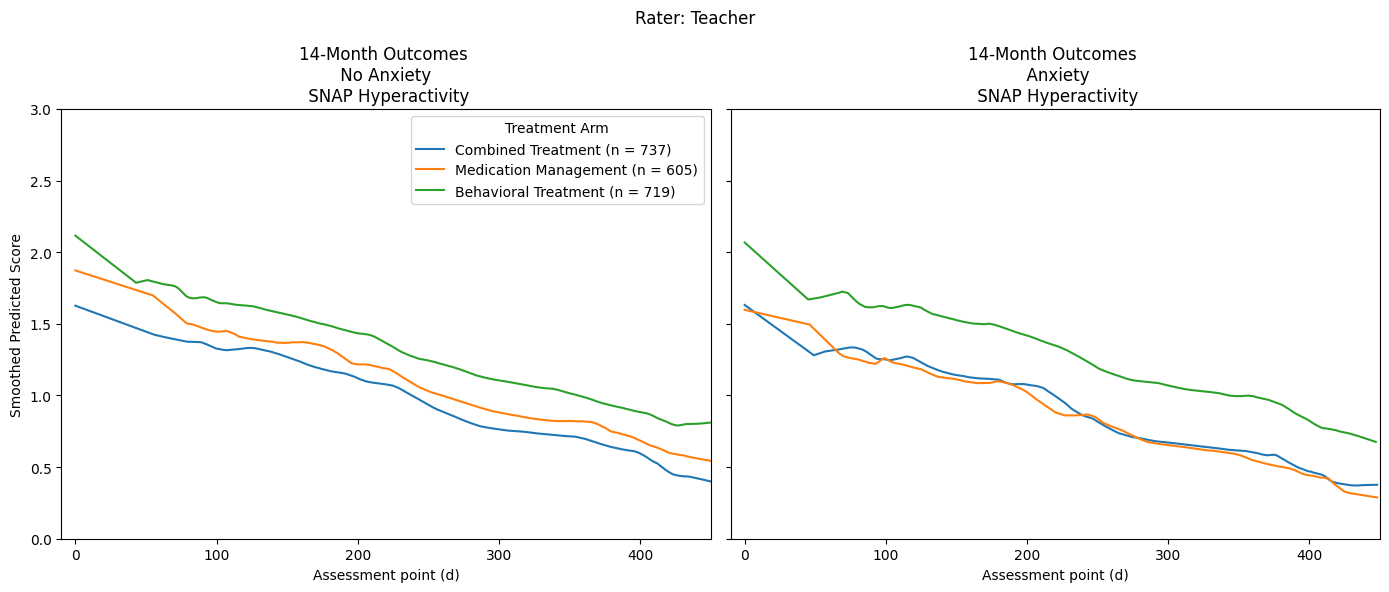

In [137]:
plot_RR_curves_med_mod_smooth(data_dict['snap'], var_mod=var_mod, var_out=var_out, results=results['snap'][raters[0]], outcomes_dict_fig= outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values = med_values, xlim = x_lim, ylim = y_lim, rater = raters[0])

### Plot : 
- hyp vs anx 
- interanalizing vs anx 
- social skills vs  public assit --> need dichotomous cutoff 
- parent closeness vs public assist -> need dichotomous cutoff 
- inattention vs attendance parent 
- inattention vs attendance teacher

In [181]:
results['snap'].keys()


dict_keys(['Parent'])

In [202]:
results['snap']

{'Teacher': {'cdorodd_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fecfdb09780>,
  'cdorodd_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fecaad303d0>,
  'cdorodd_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fecfe0442b0>,
  'anx_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fecfdd1ee90>,
  'anx_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fed1c712920>,
  'anx_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fed1c712f20>,
  'demo61_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fed1c81f9d0>,
  'demo61_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fed1c4c1ae0>,
  'demo61_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7fecab9c3fa0>,
  'hi_24_snainatx': <statsmodels.regression.

In [189]:
ylim_dict = {'snap' : [0,3], 'ssrs': [0,2], 'masc' : [0,3], 'pc': [0,4]}

In [192]:
save_path = Path('/Users/alina/Desktop/MIT/code/data/output/figures')


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


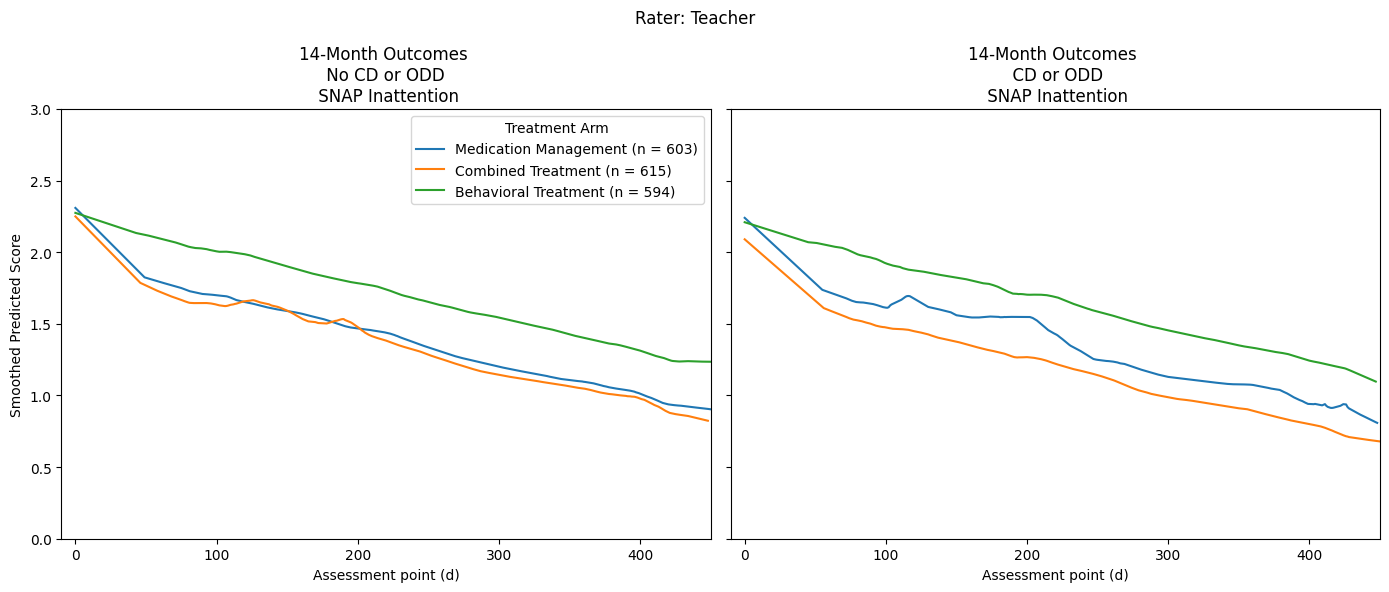

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


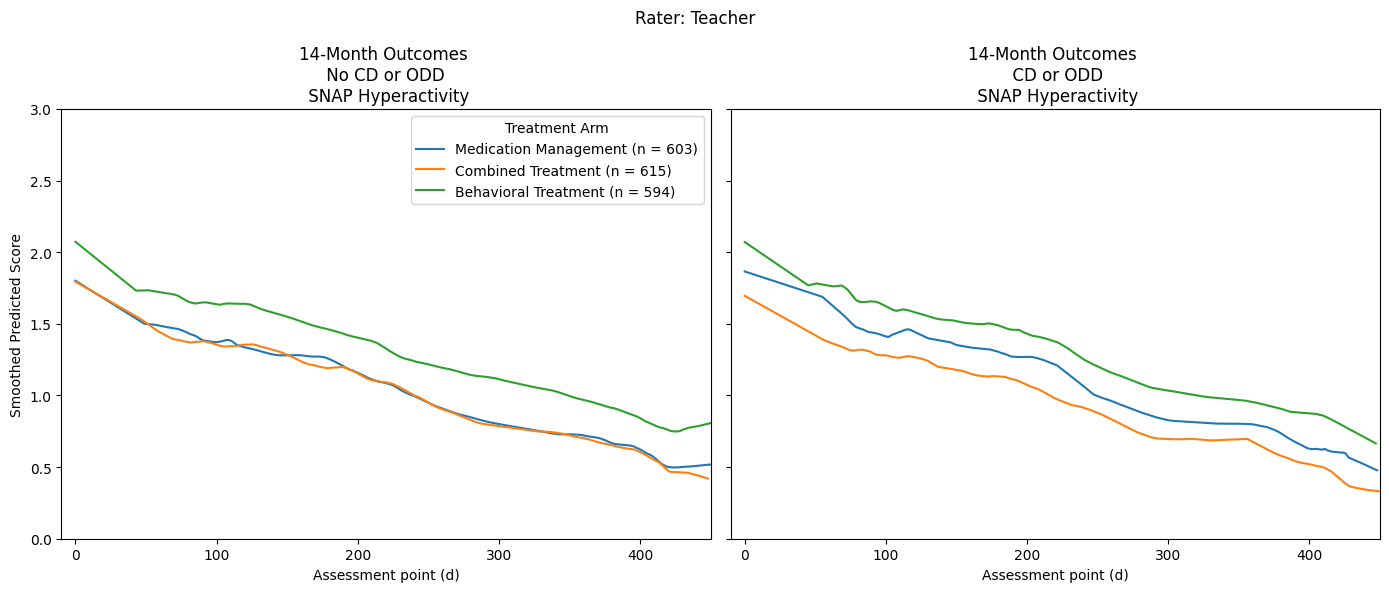

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


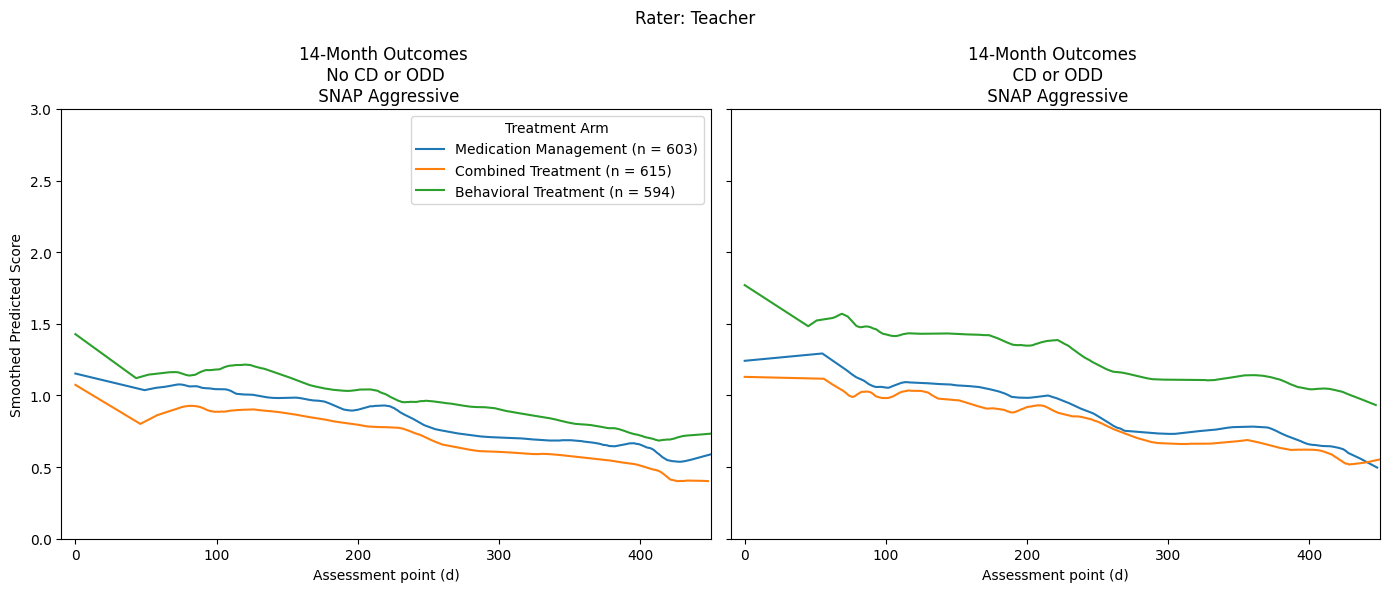

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


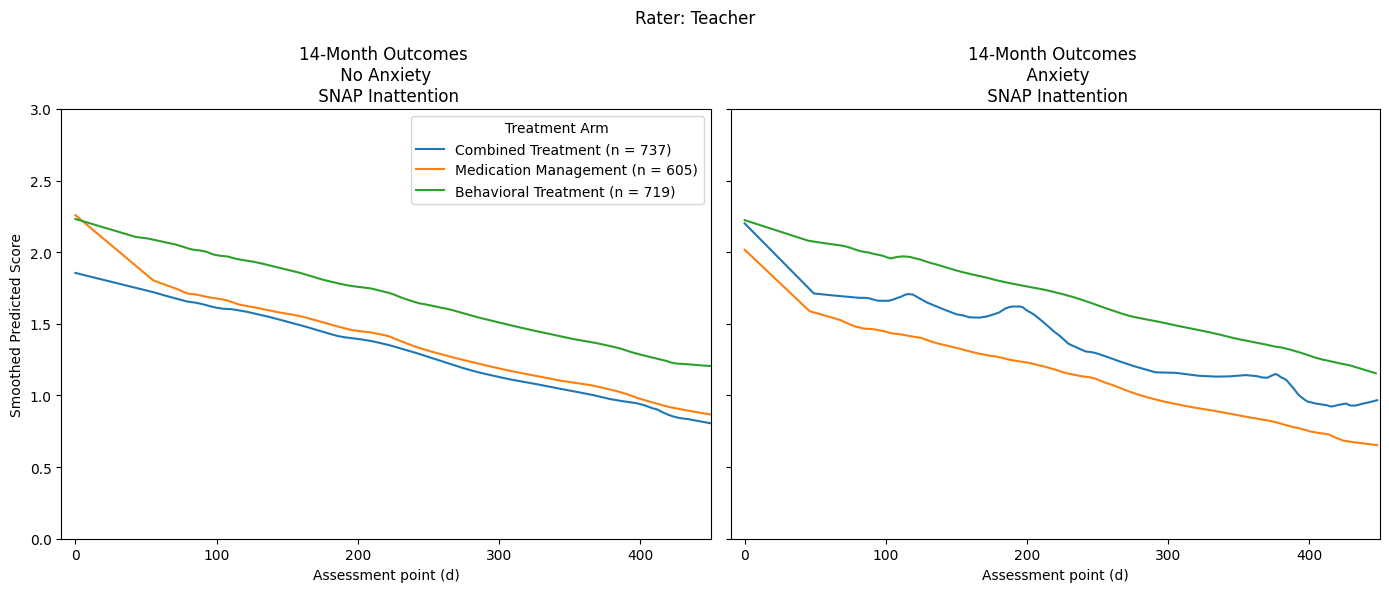

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


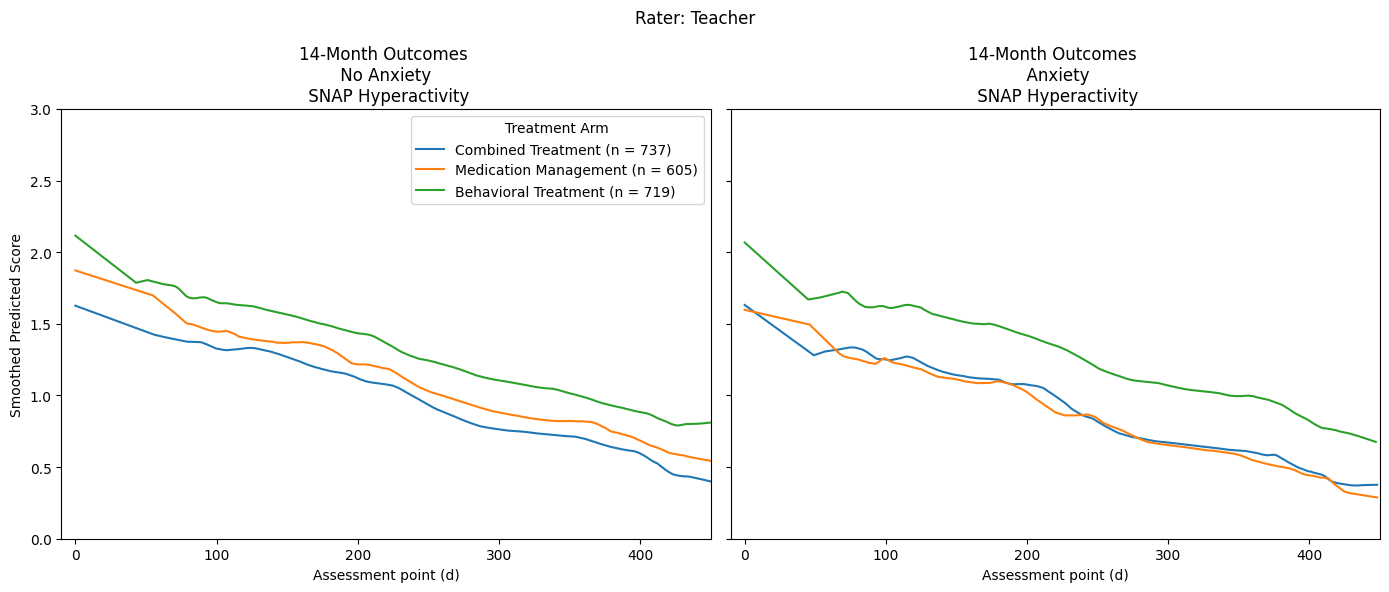

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


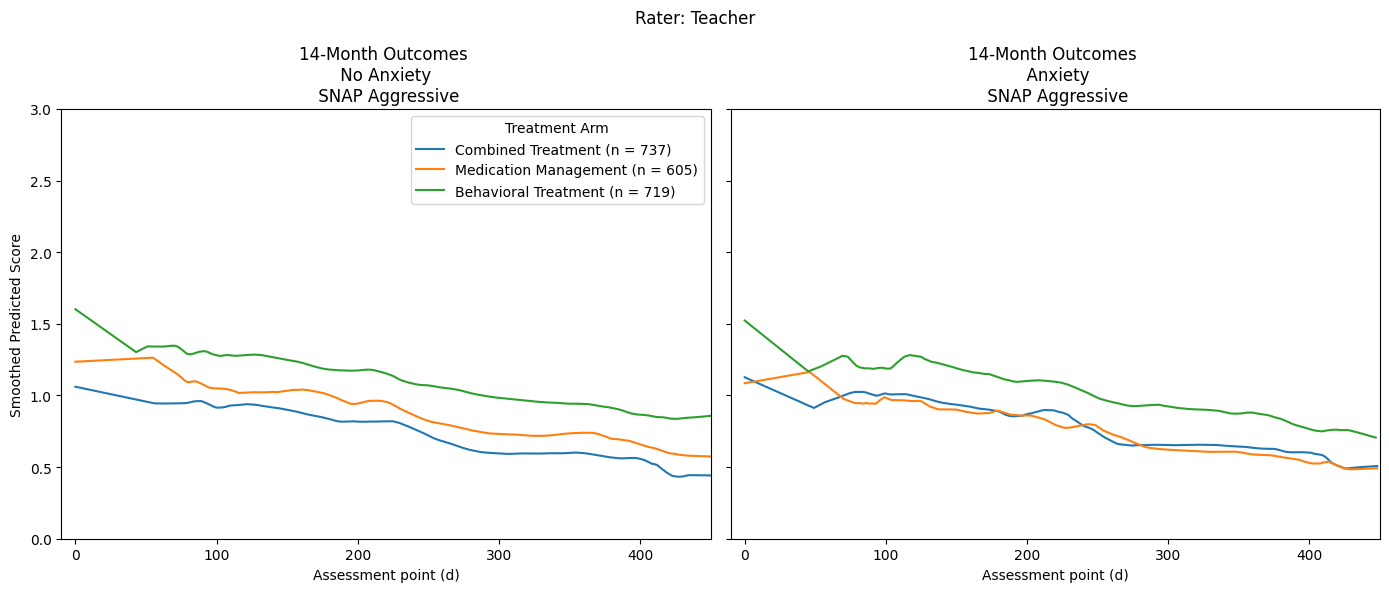

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


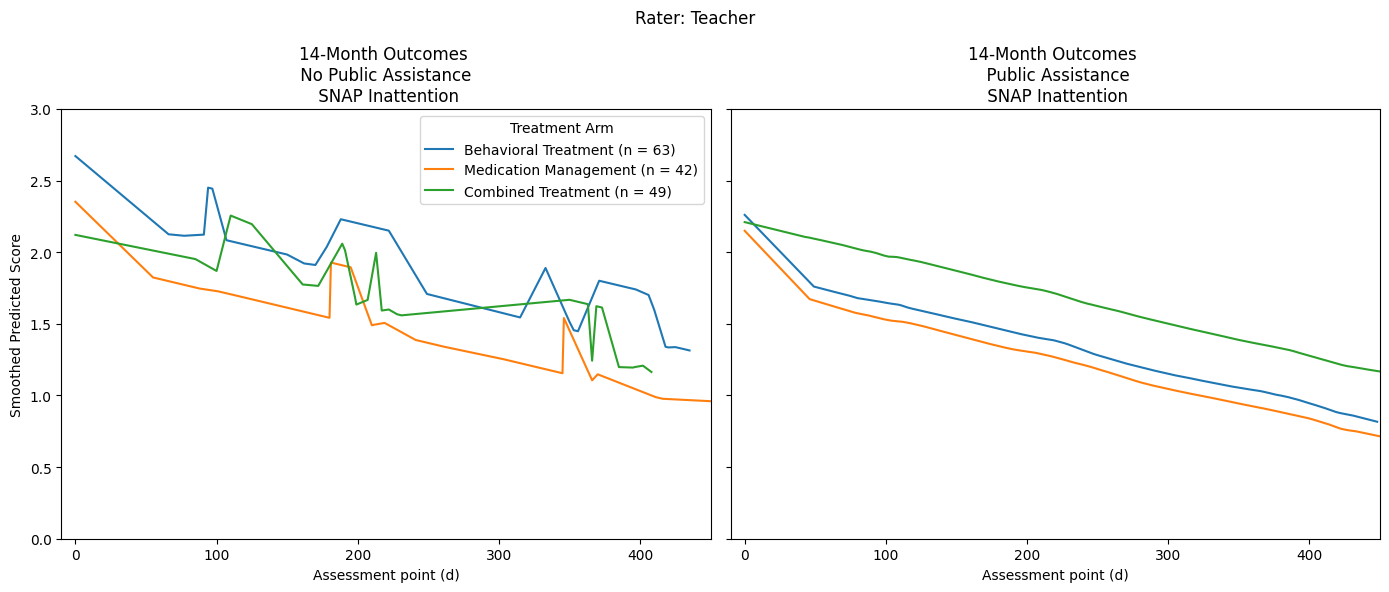

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


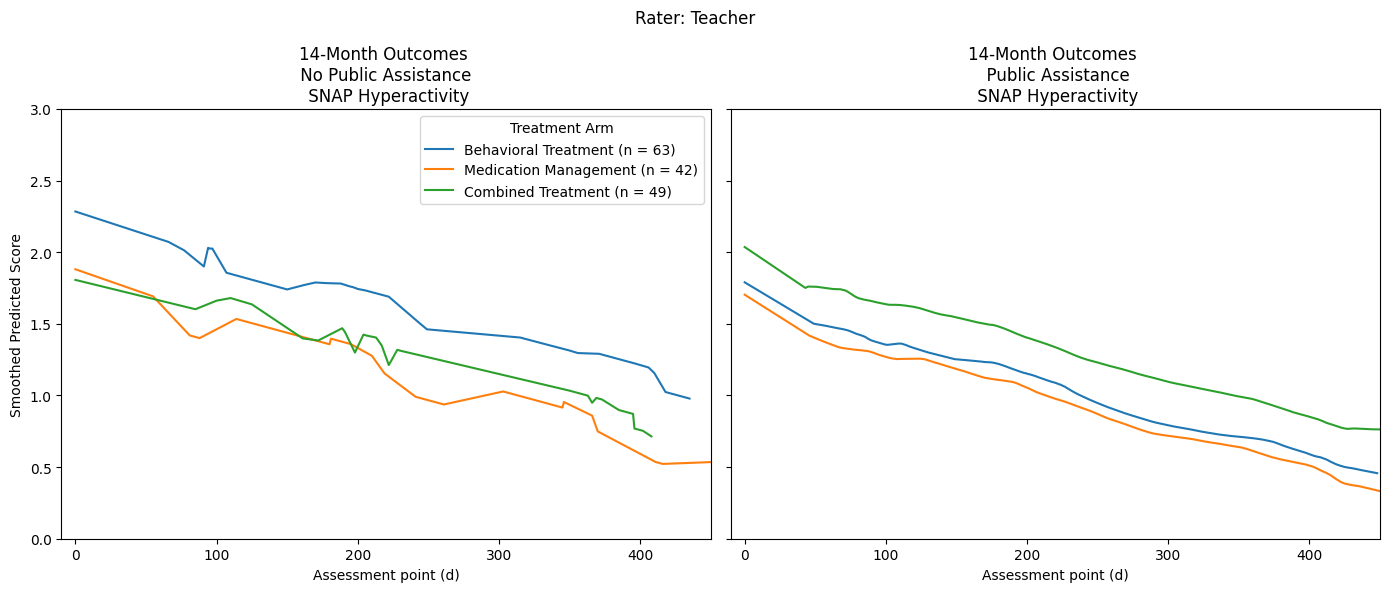

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


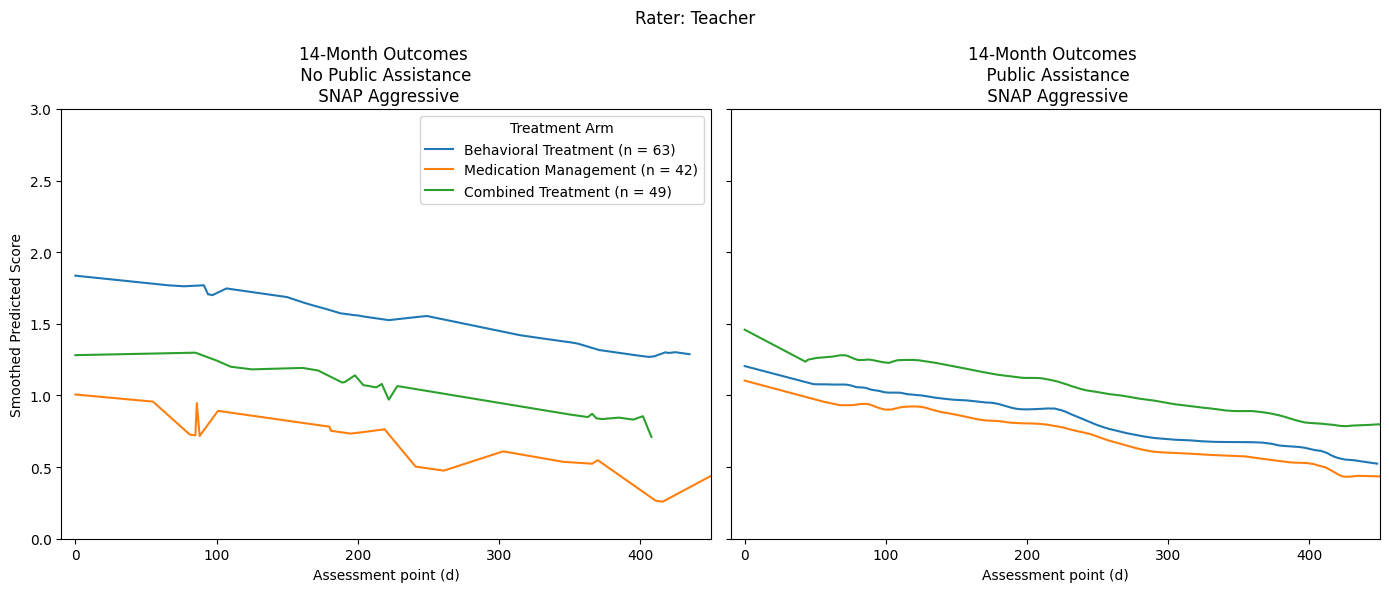

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


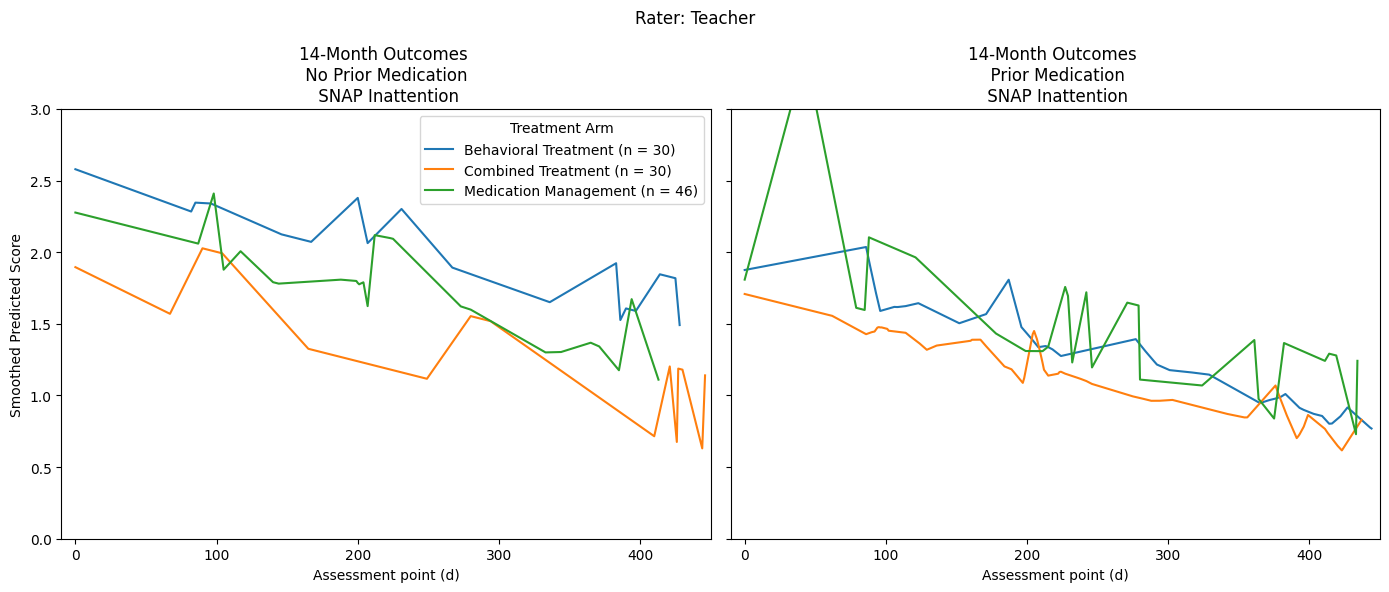

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


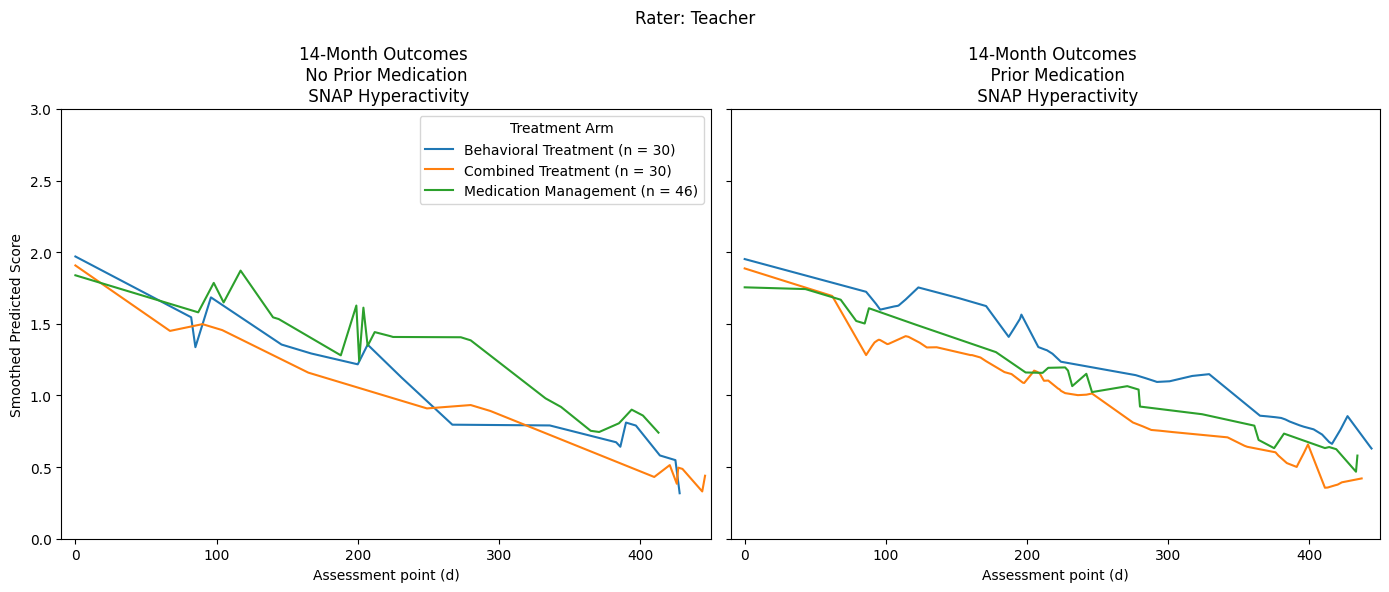

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


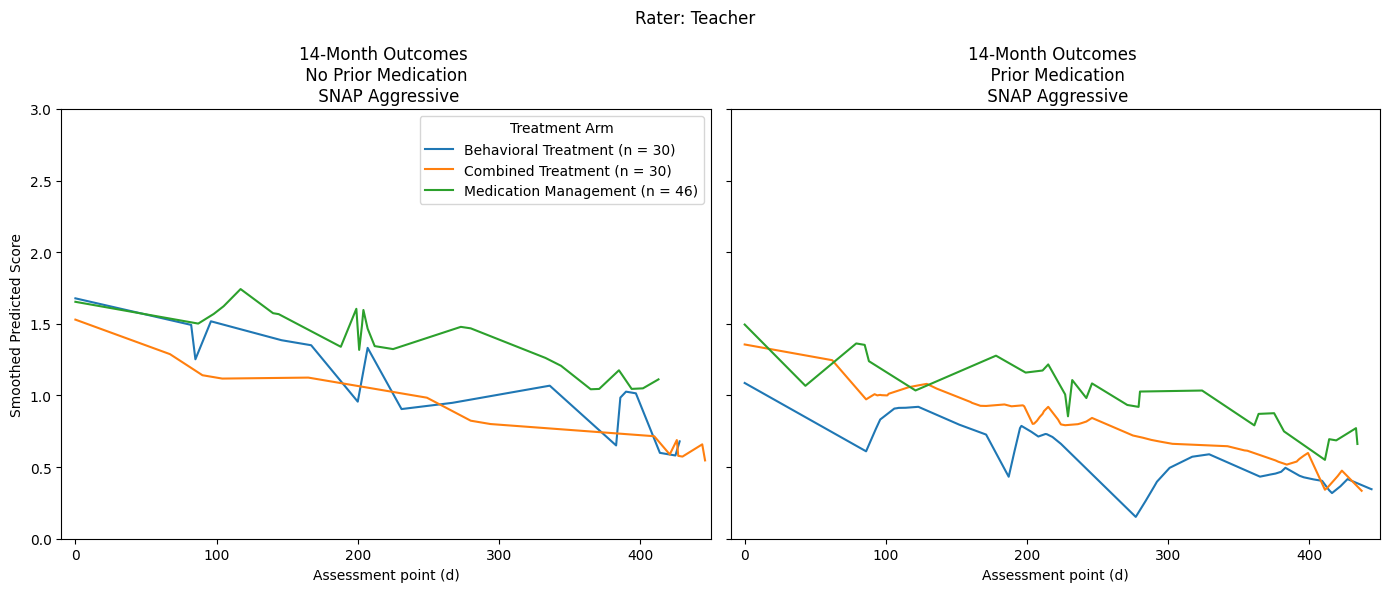

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


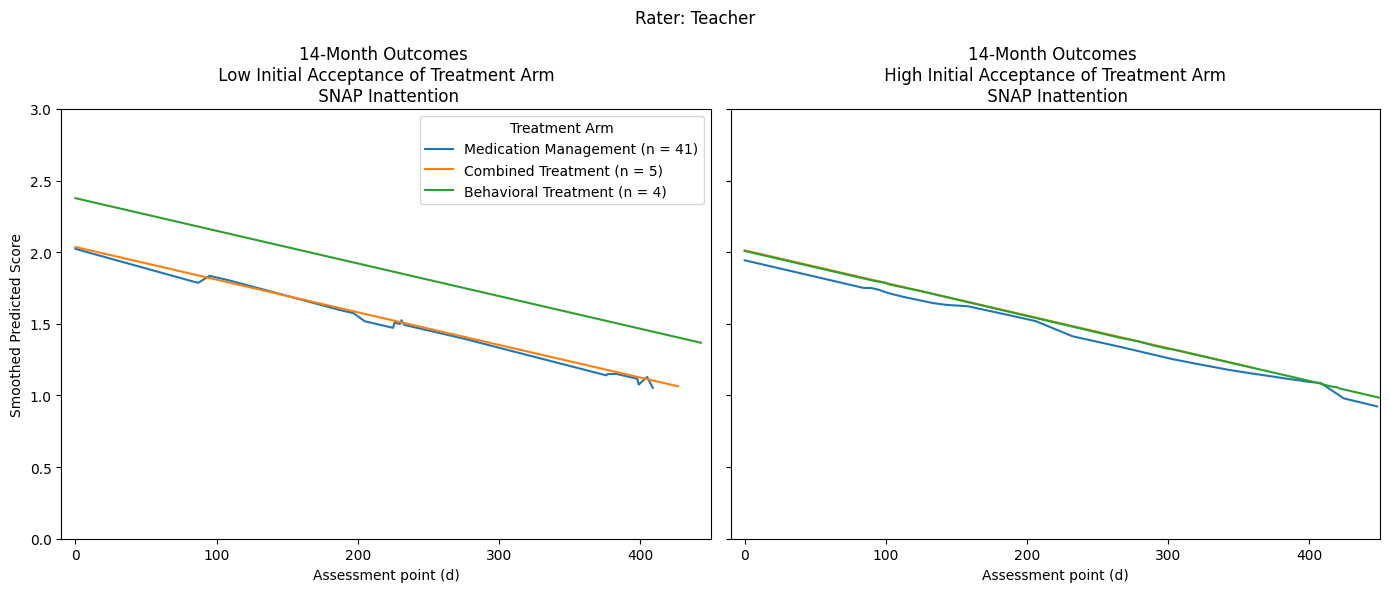

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


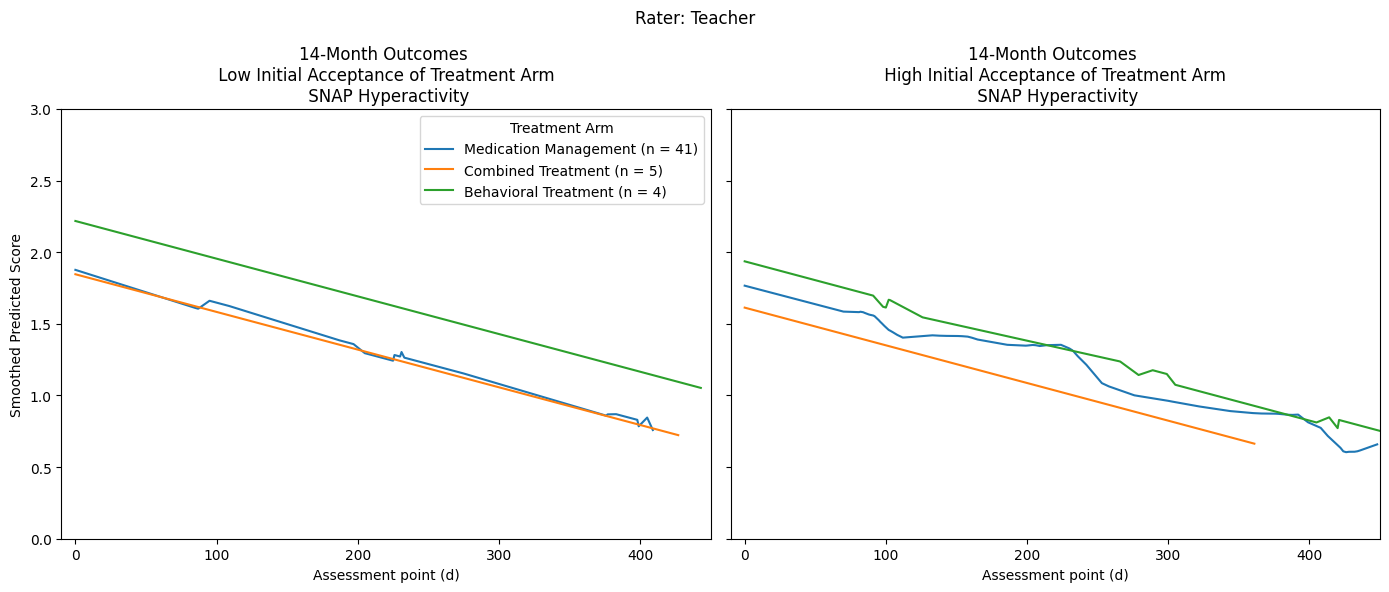

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


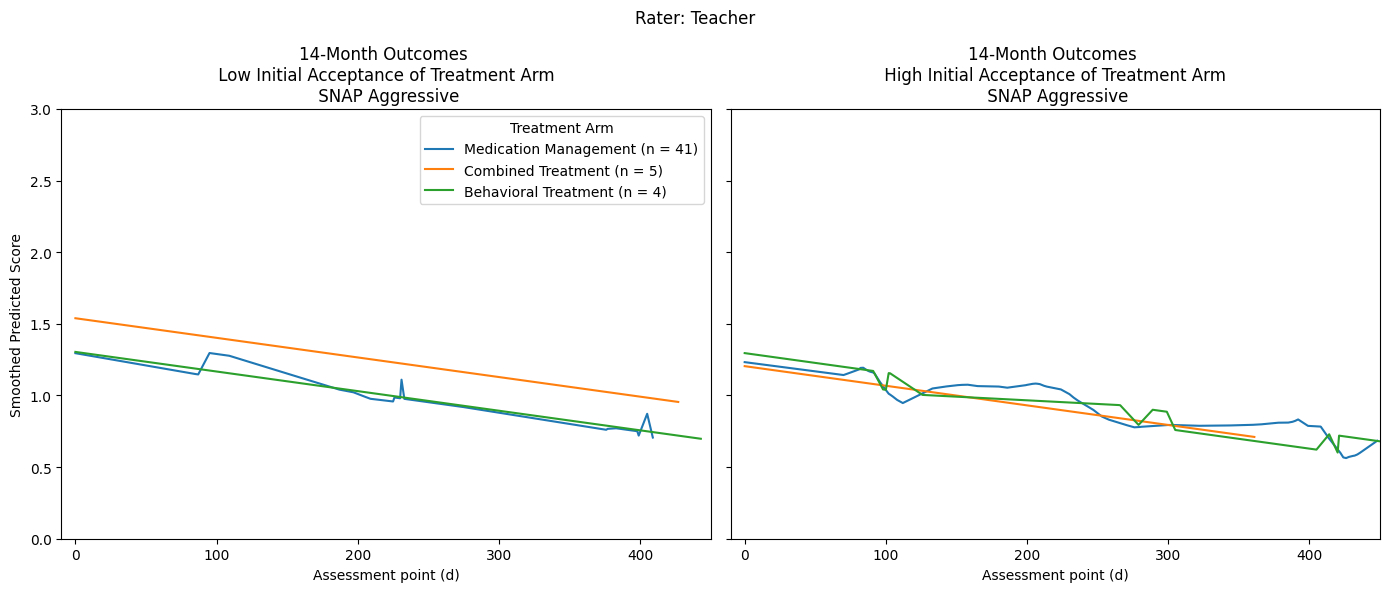

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


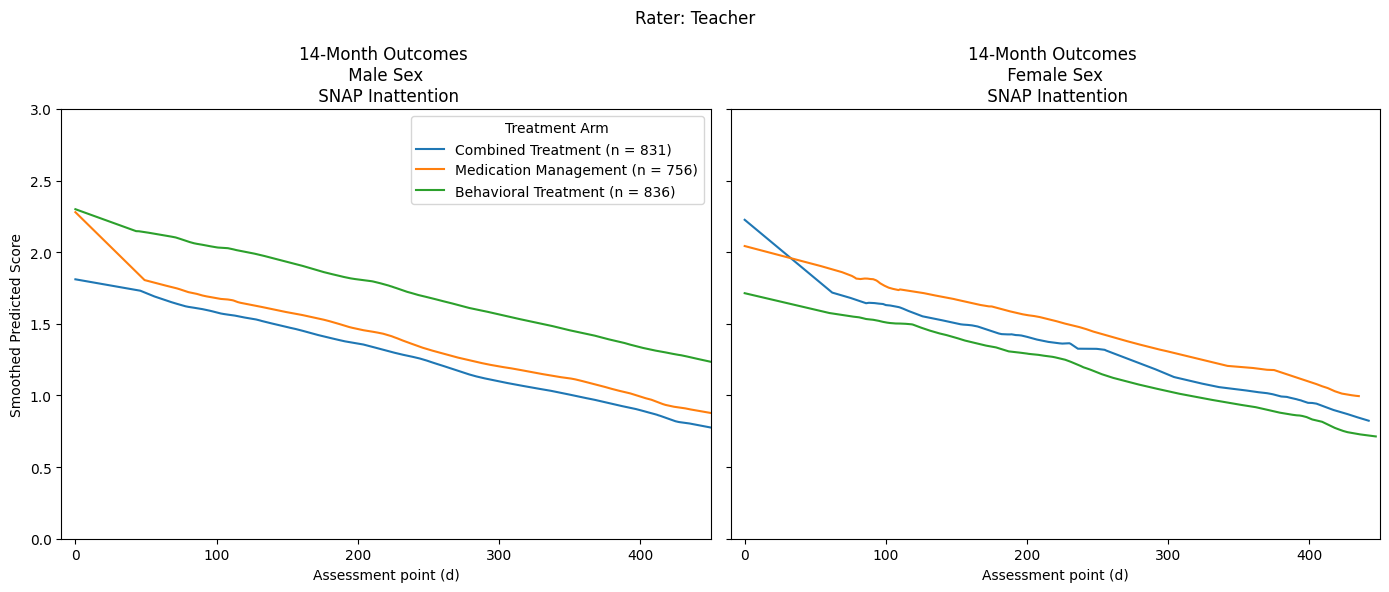

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


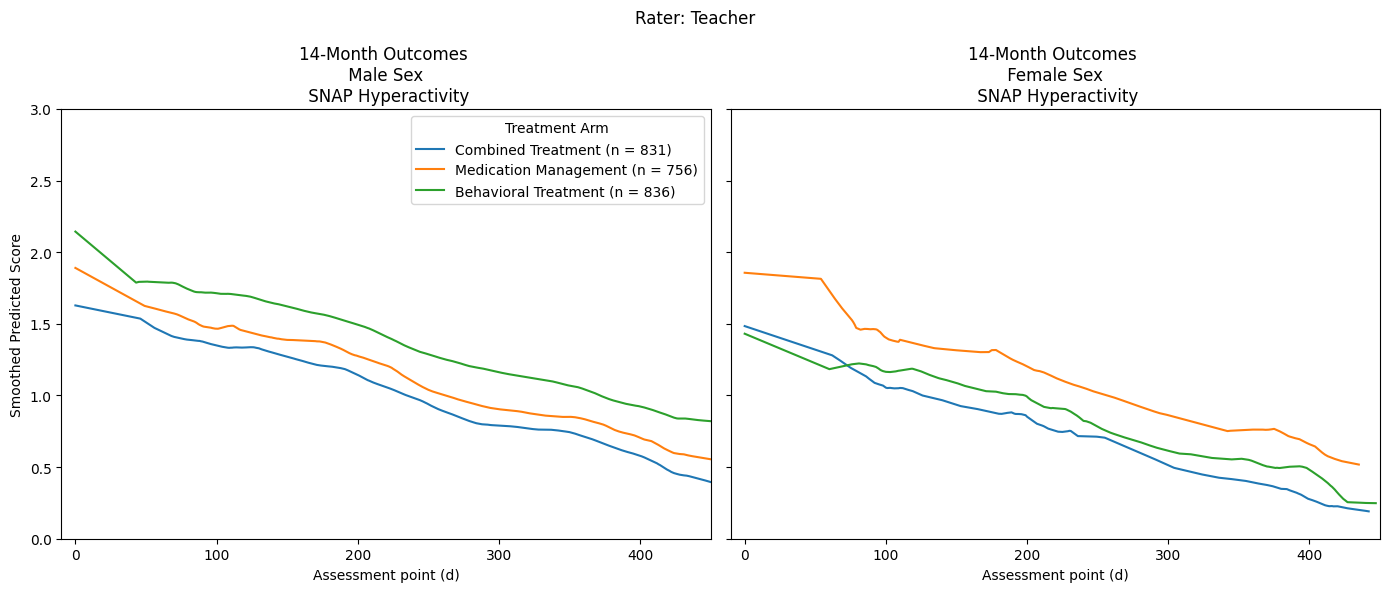

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


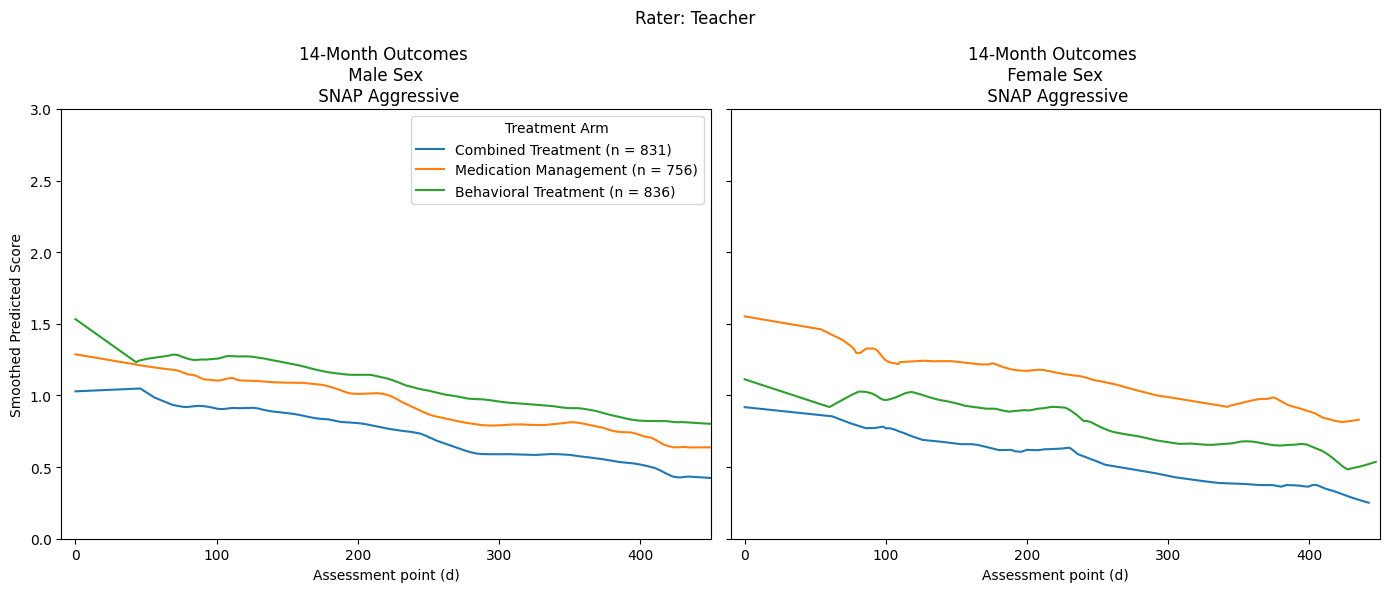

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


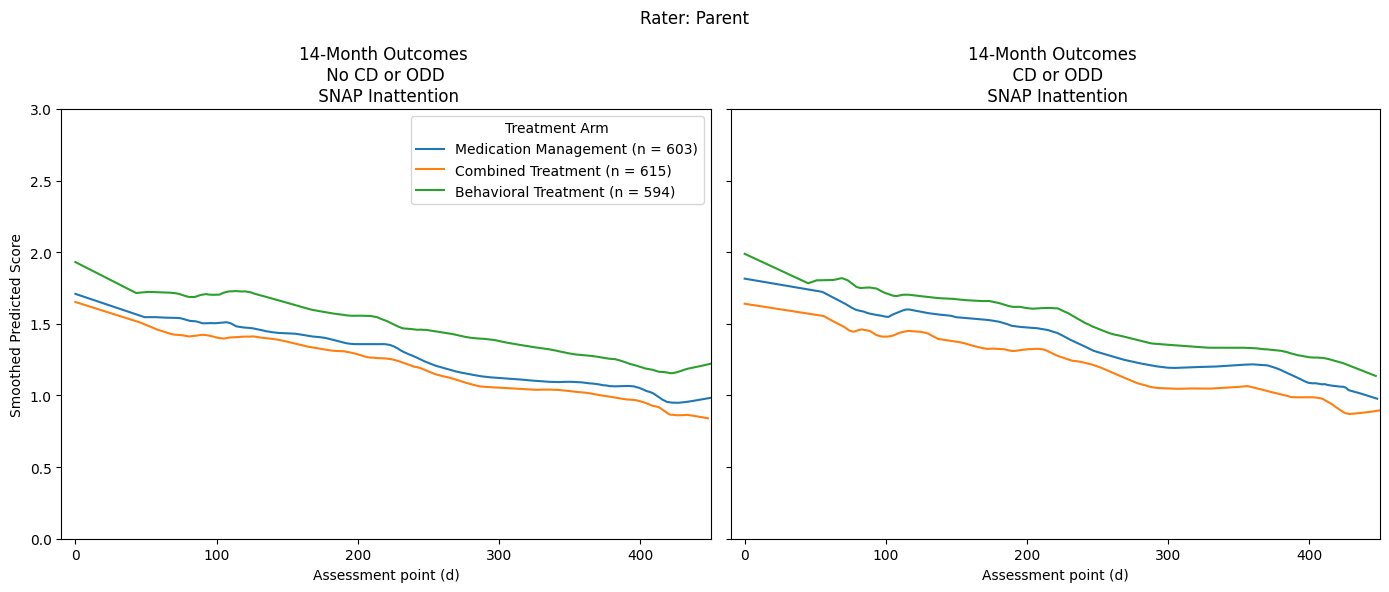

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


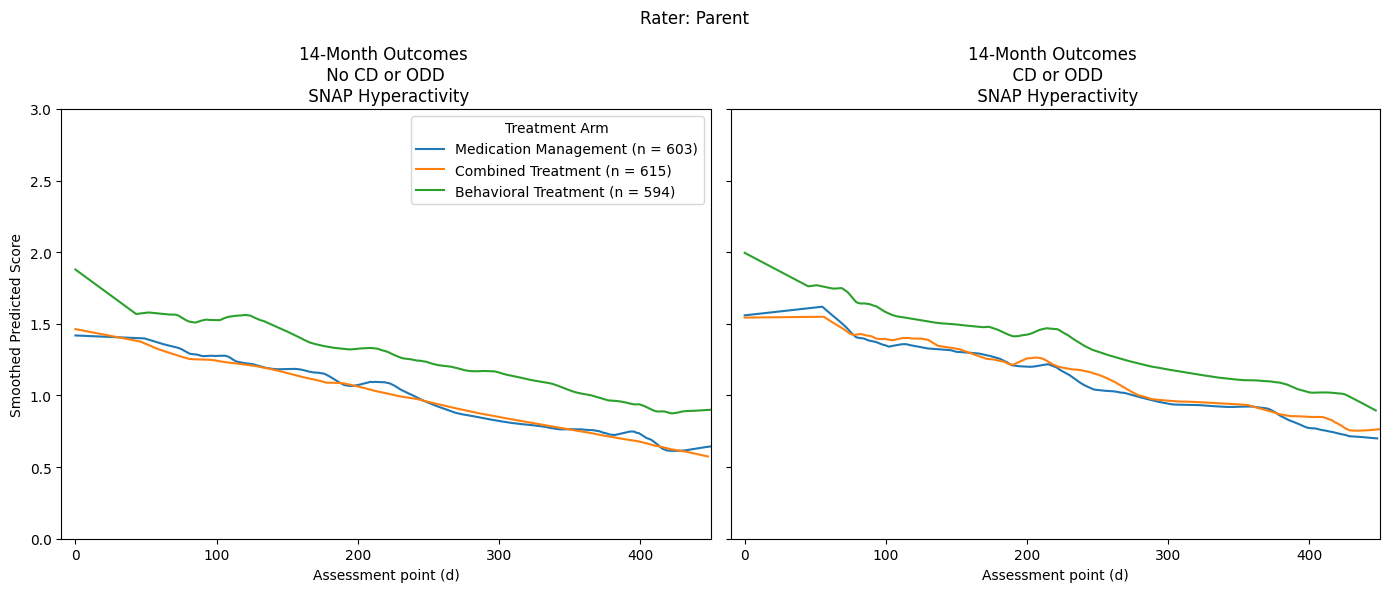

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


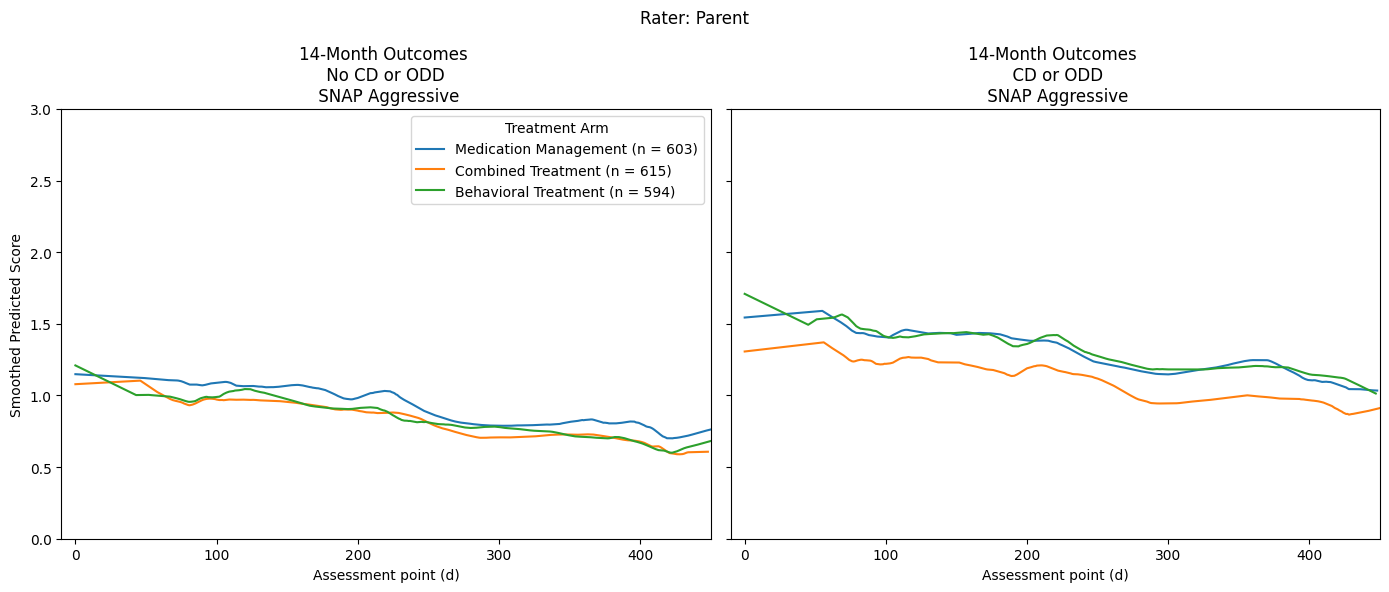

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


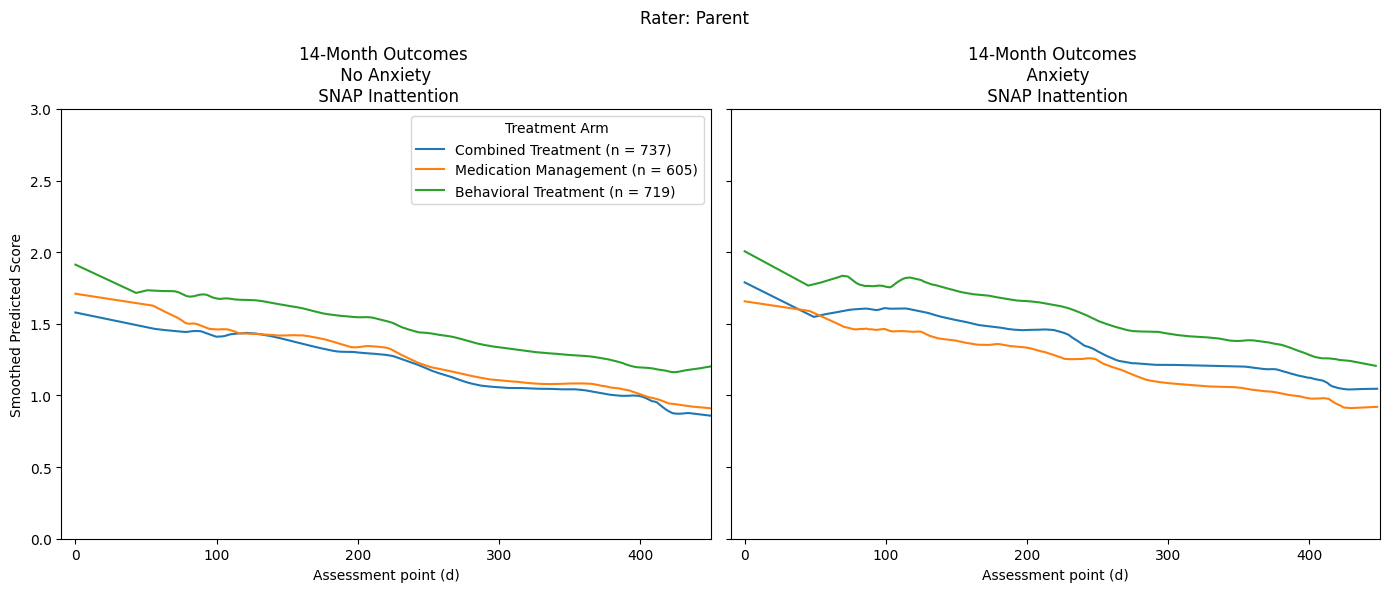

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


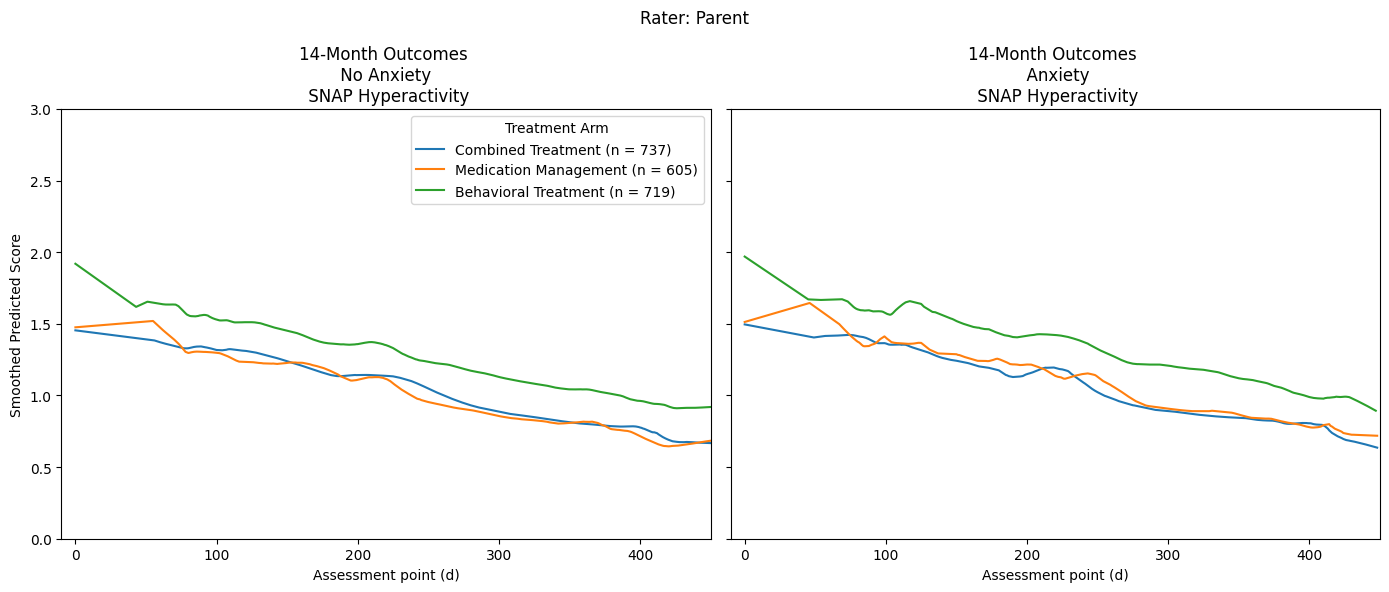

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


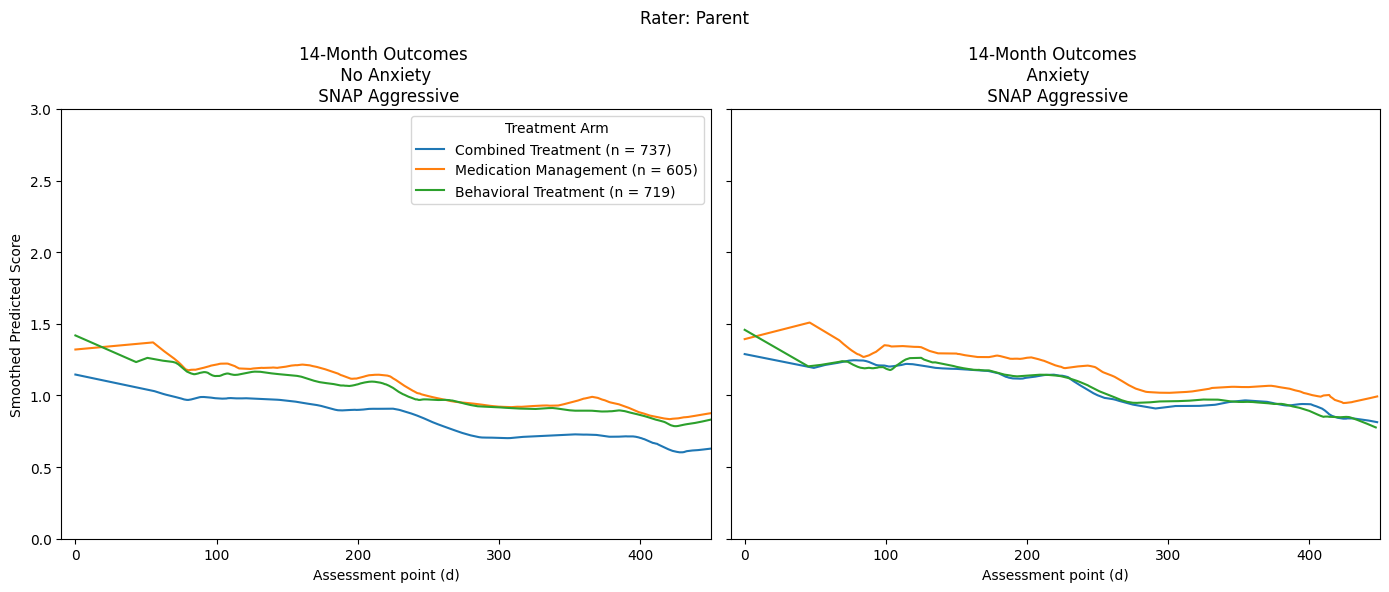

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


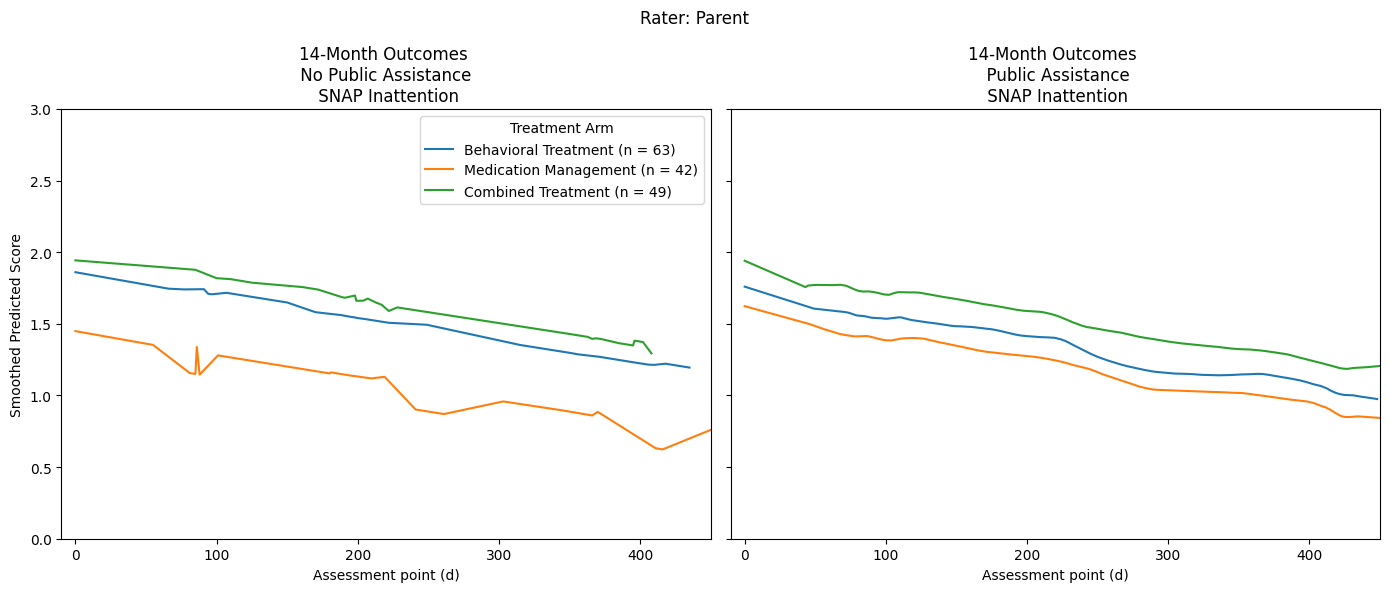

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


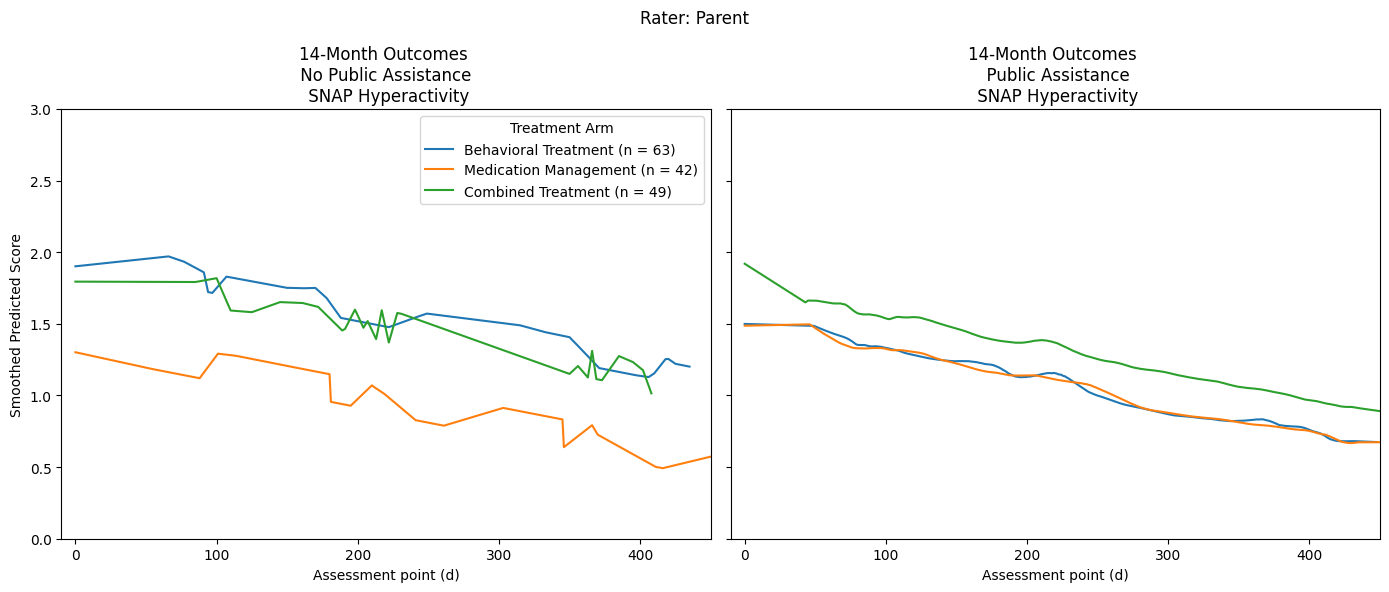

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


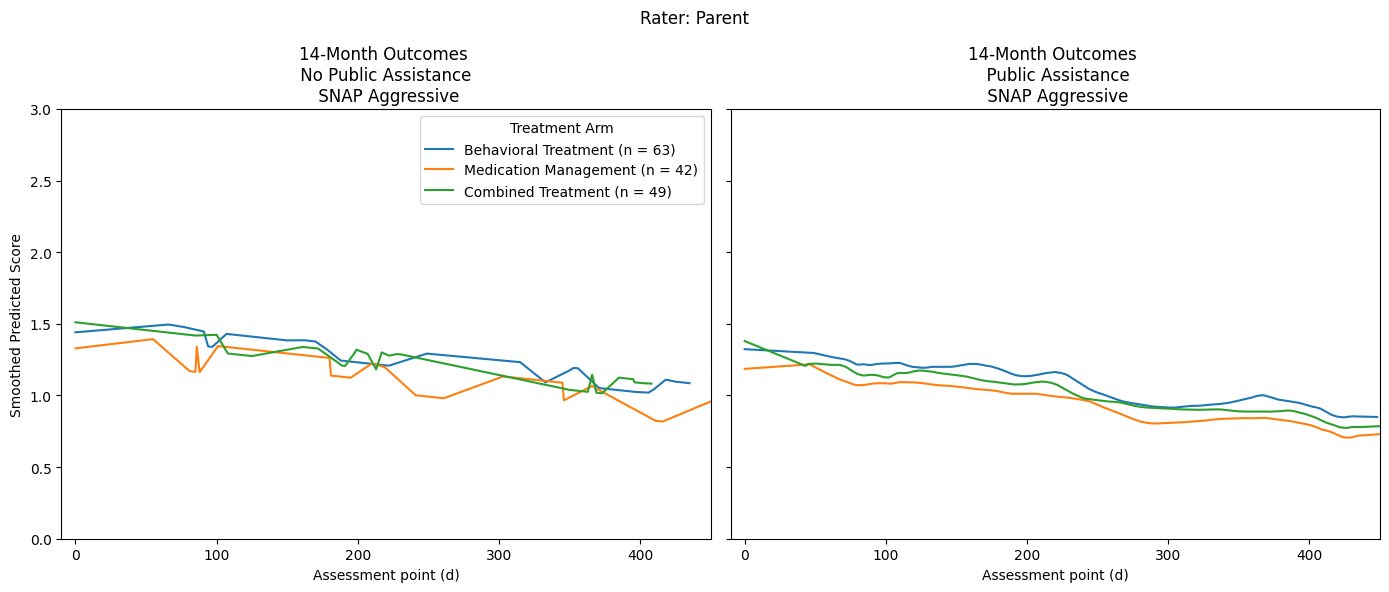

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


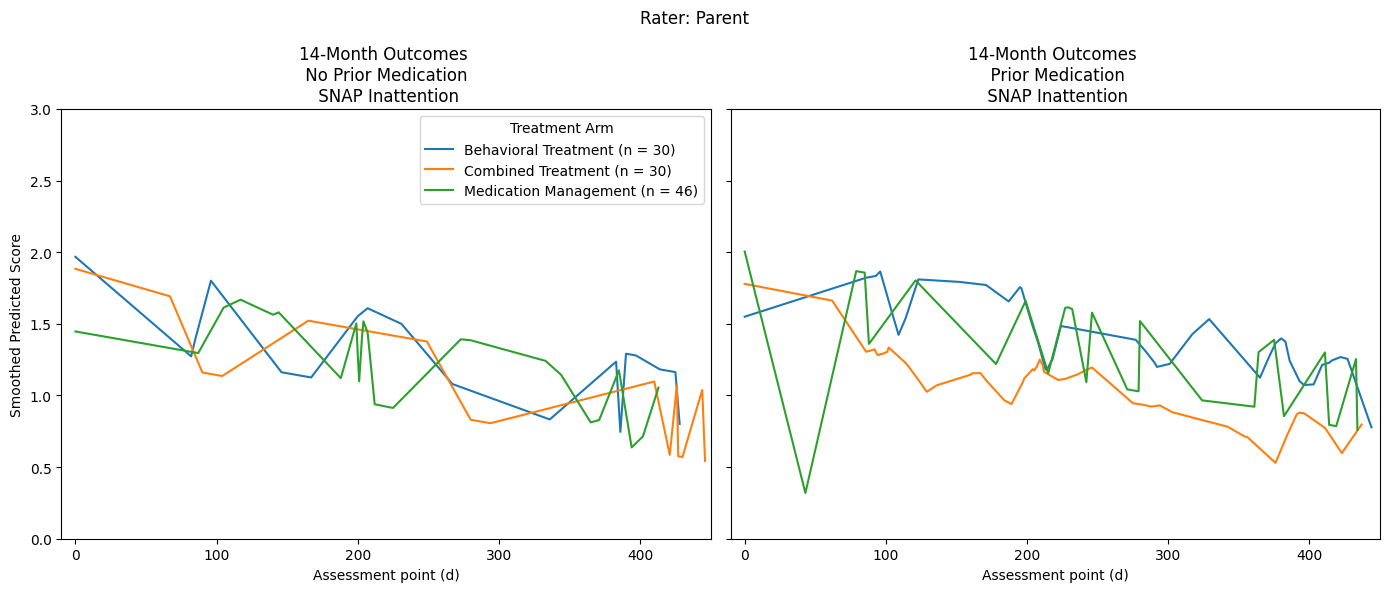

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


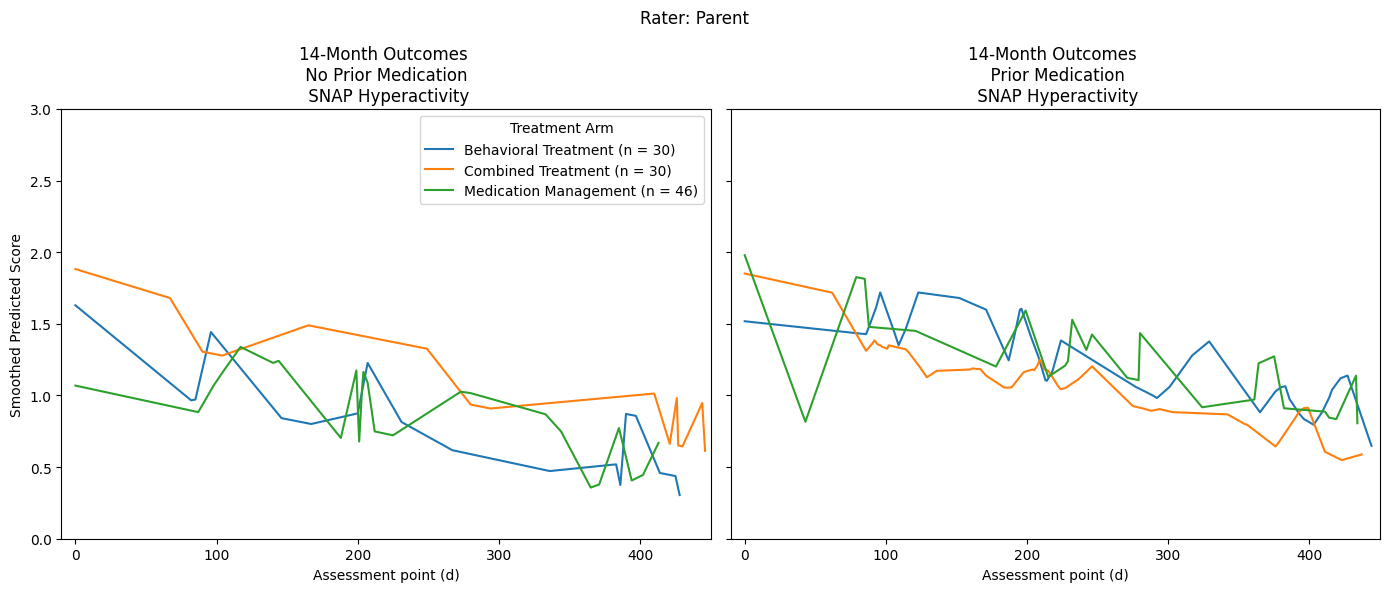

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


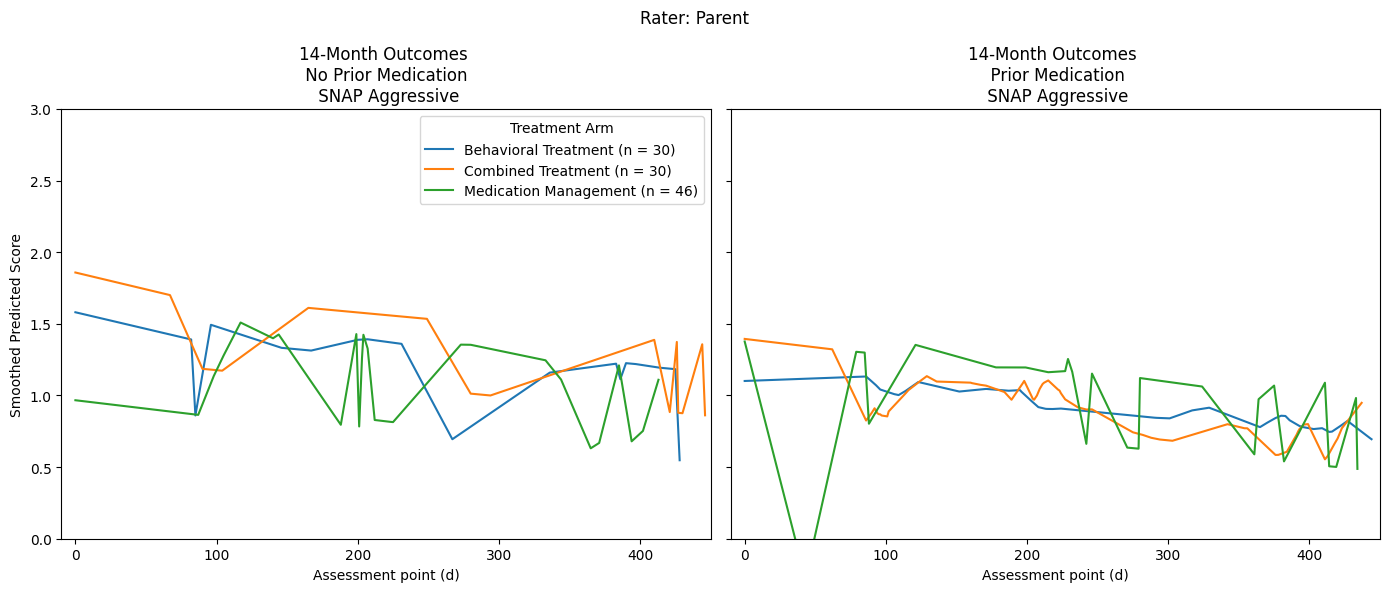

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


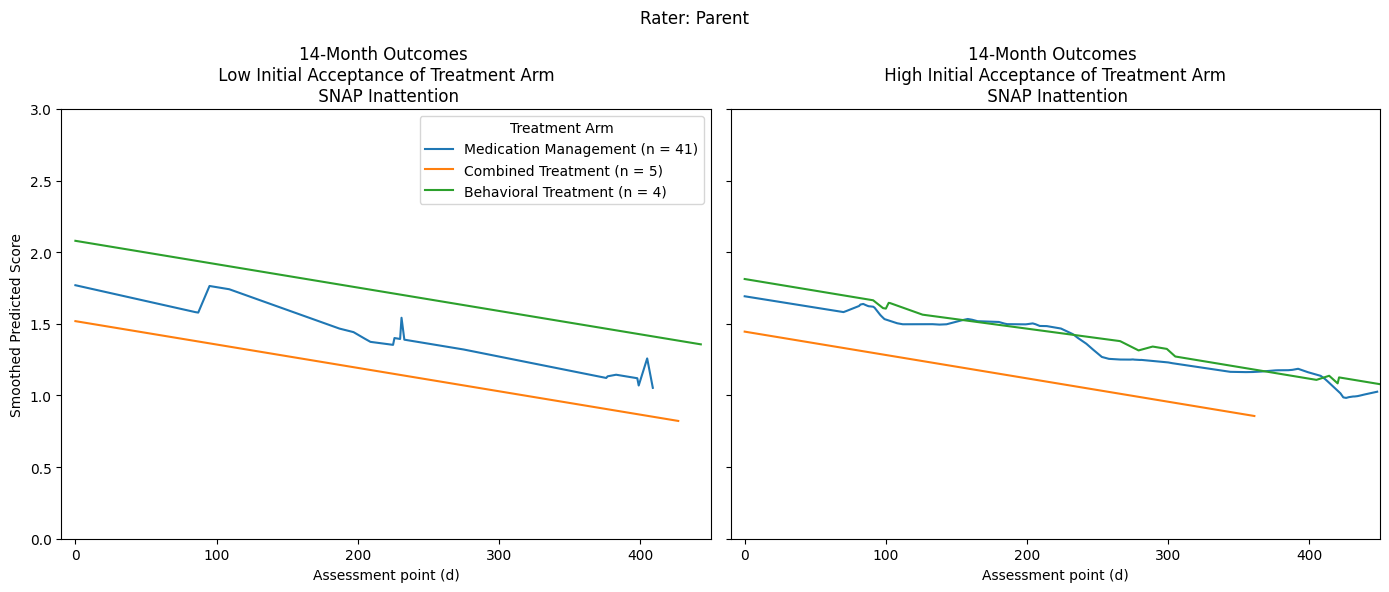

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


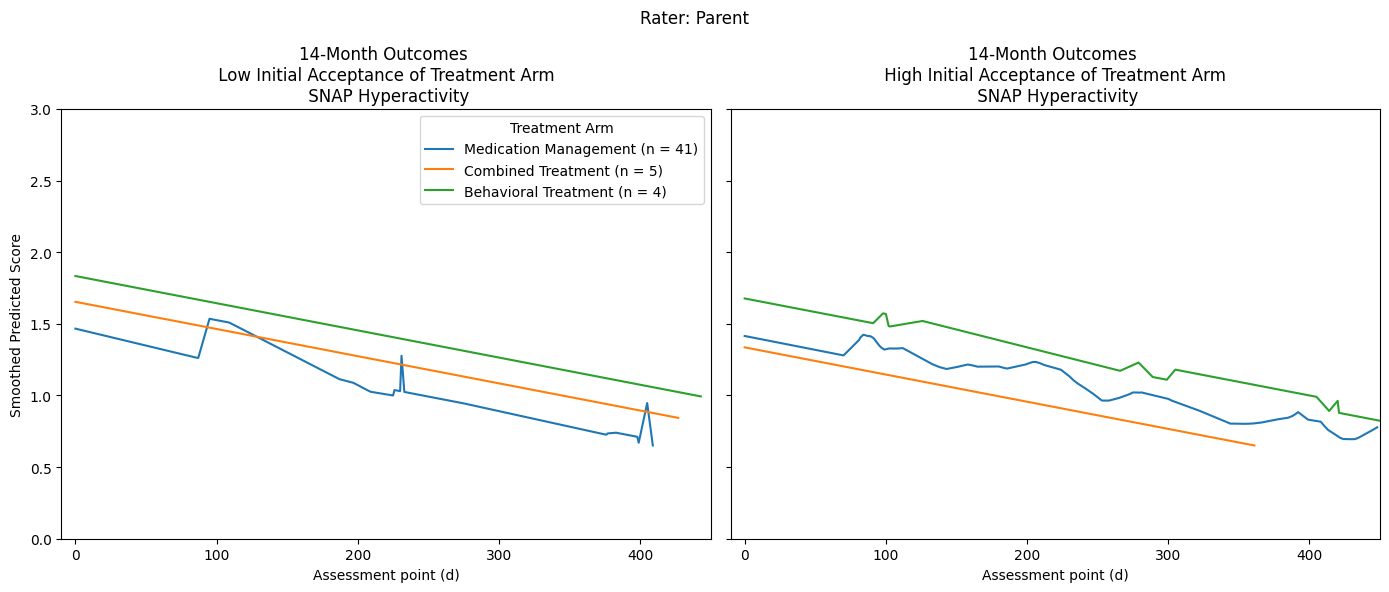

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


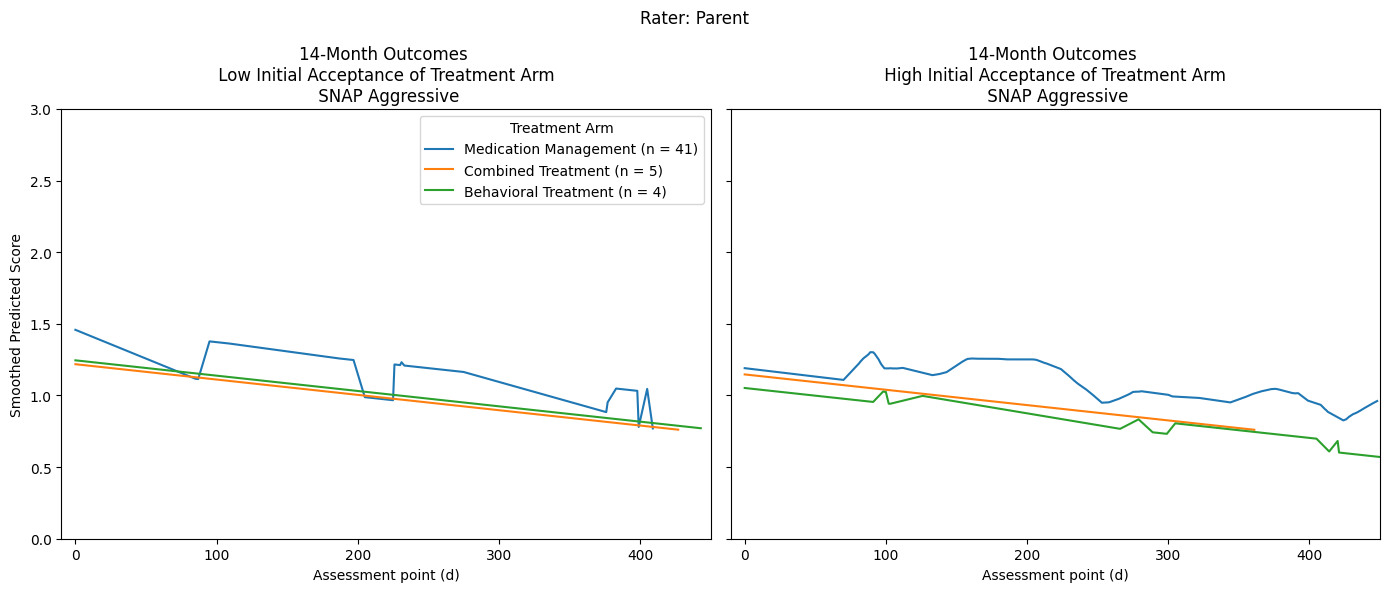

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


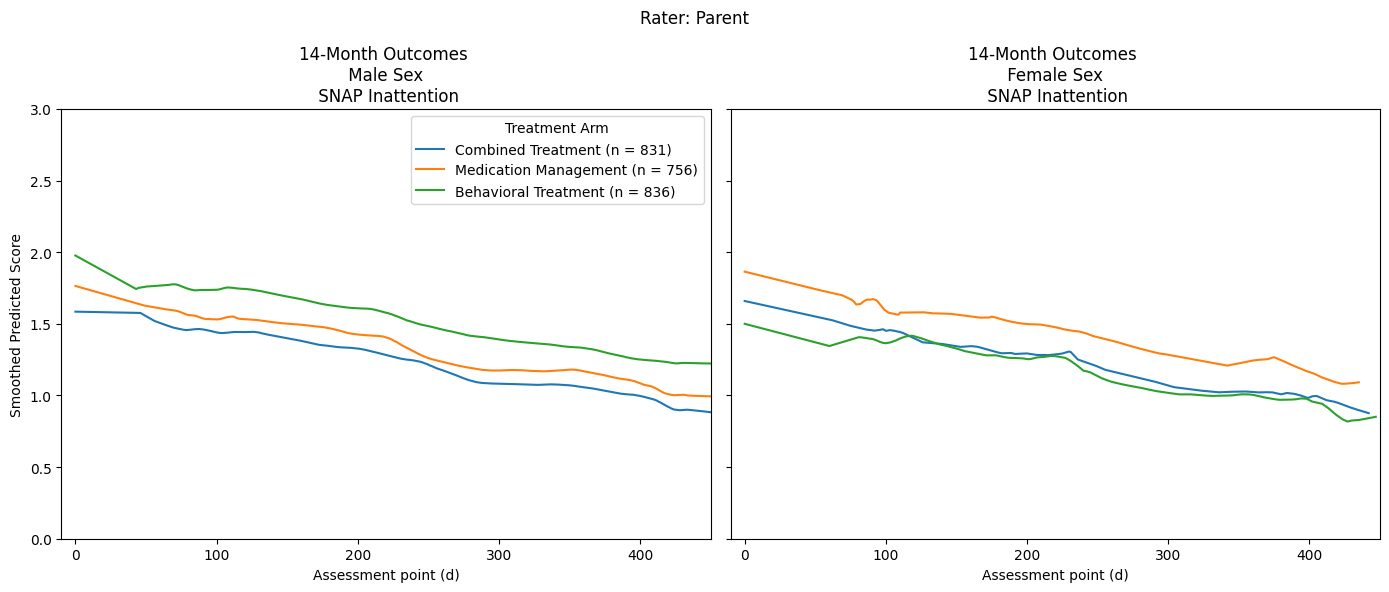

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


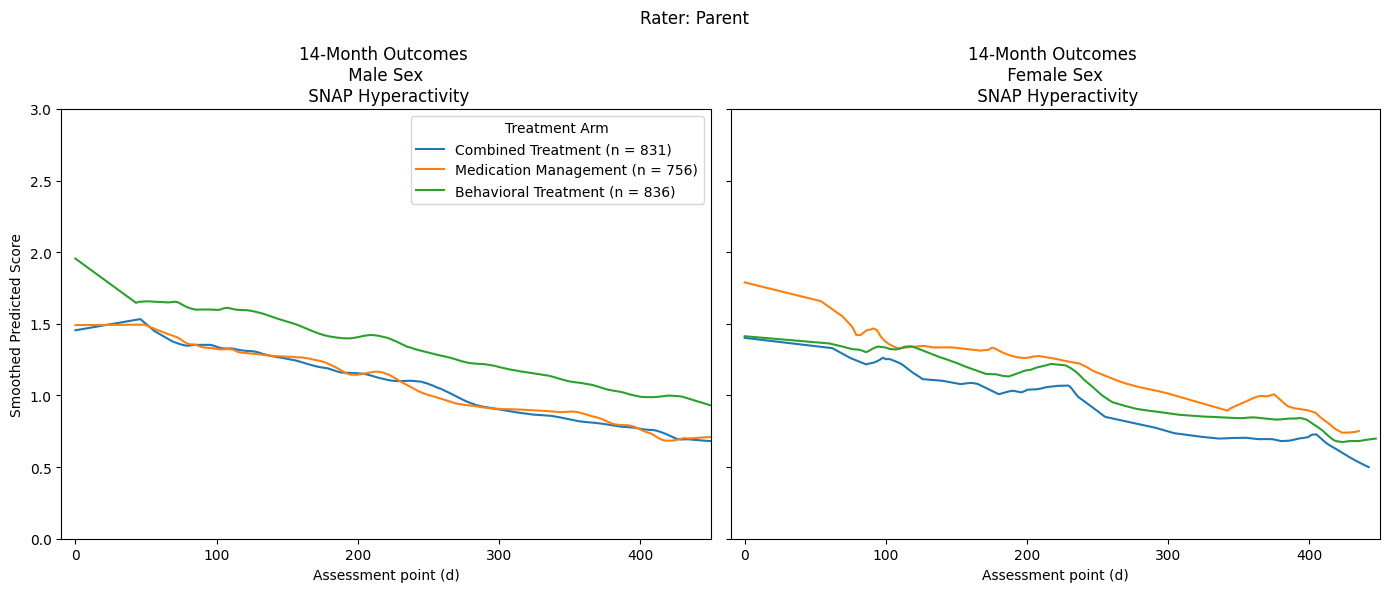

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


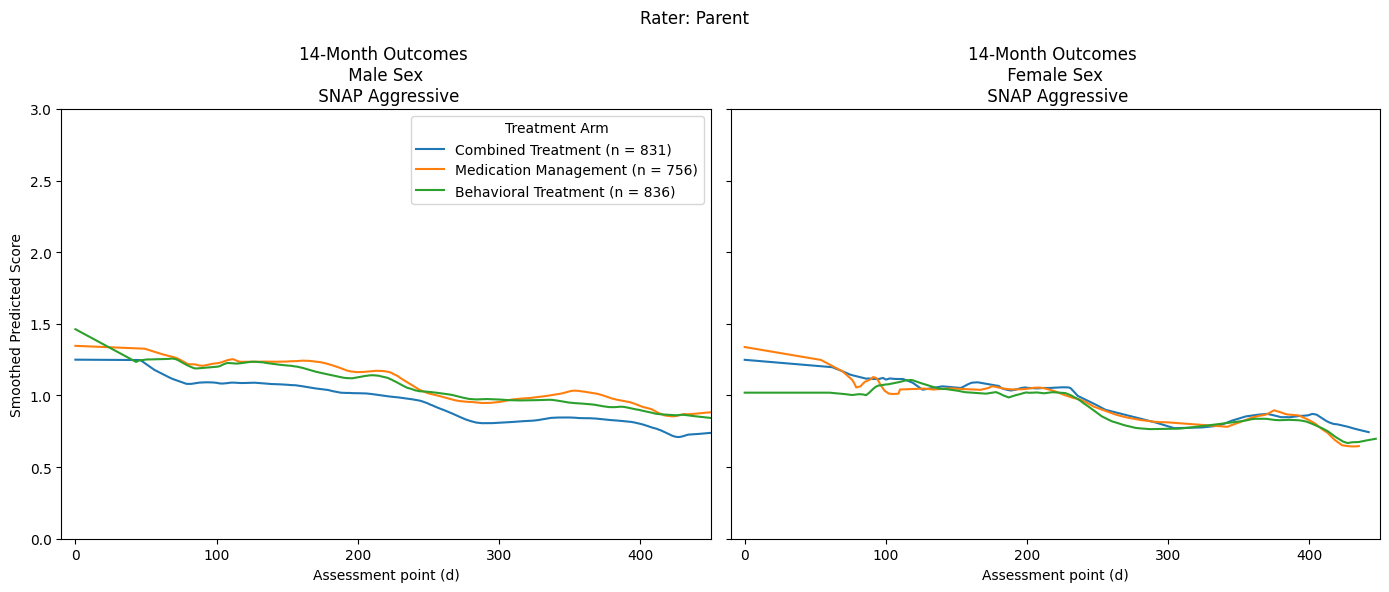

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


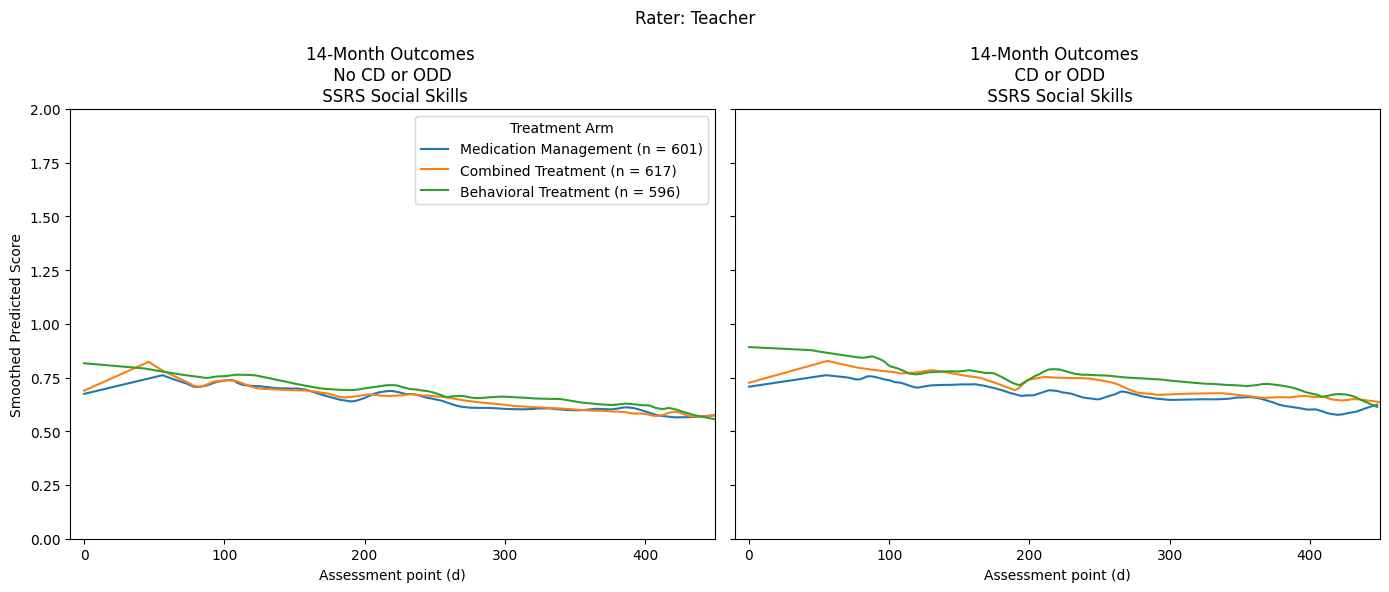

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


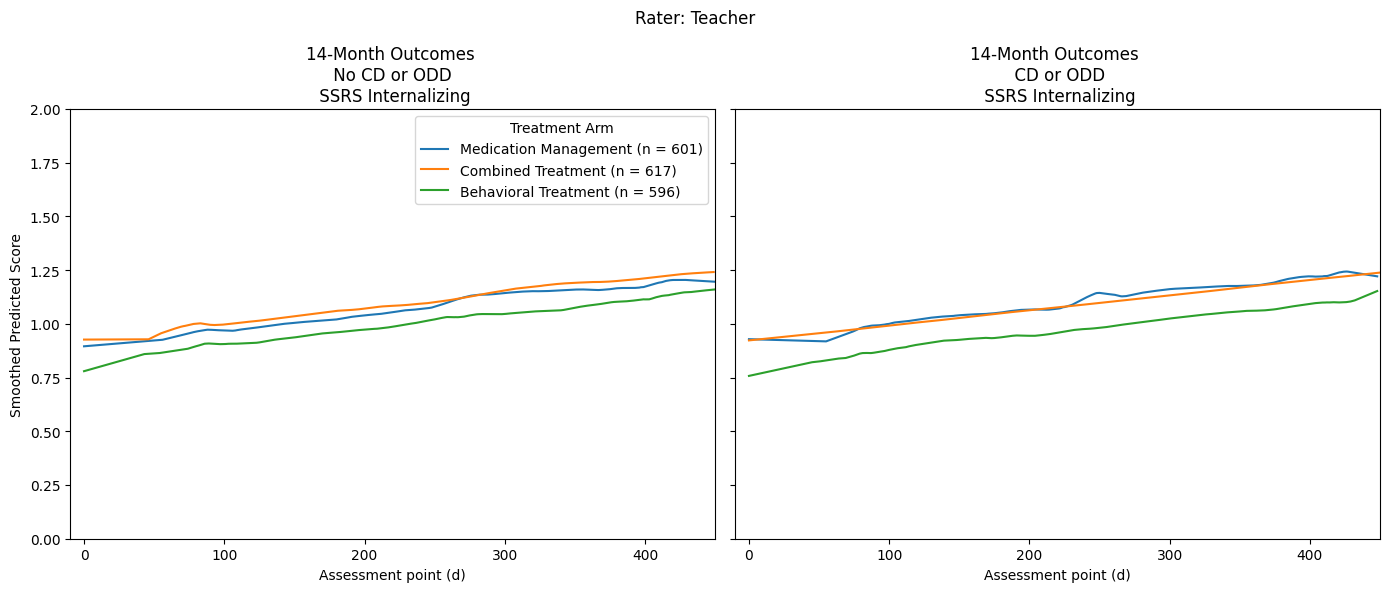

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


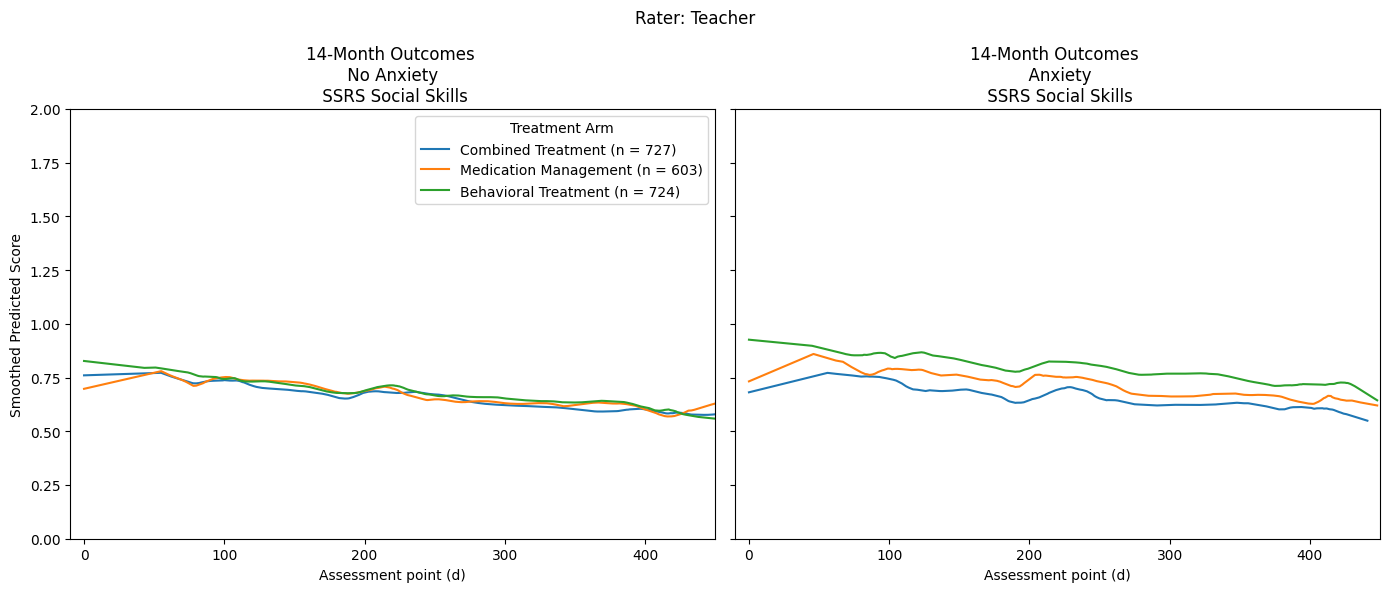

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


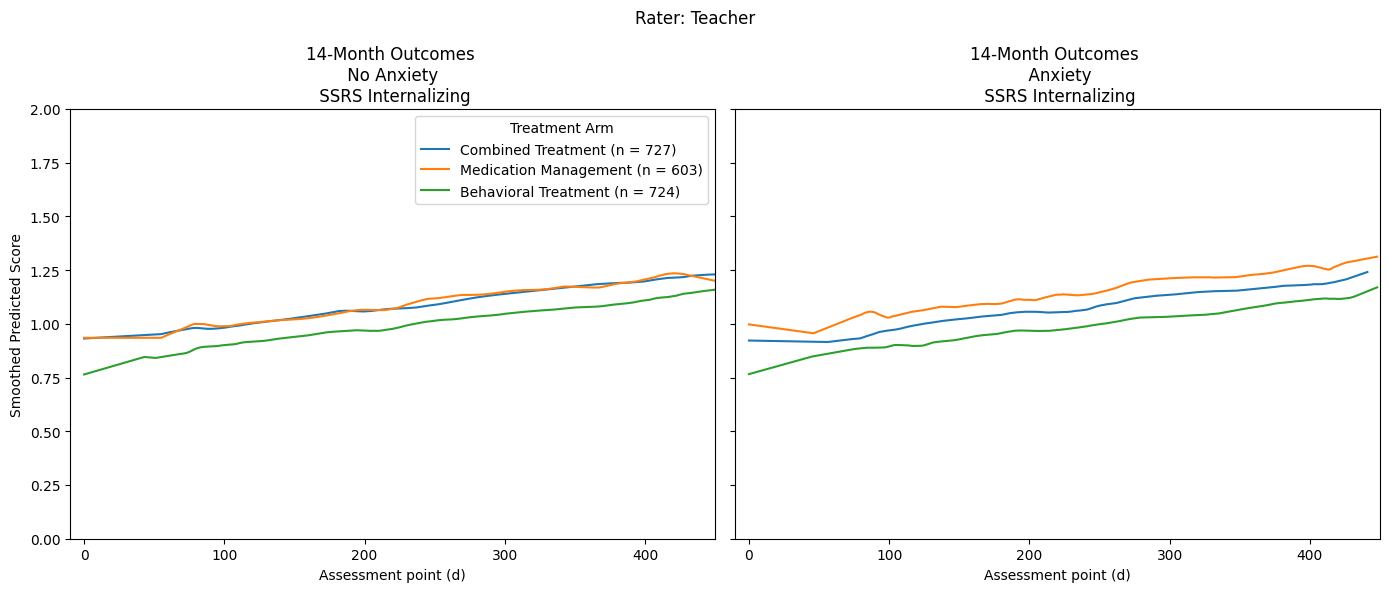

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


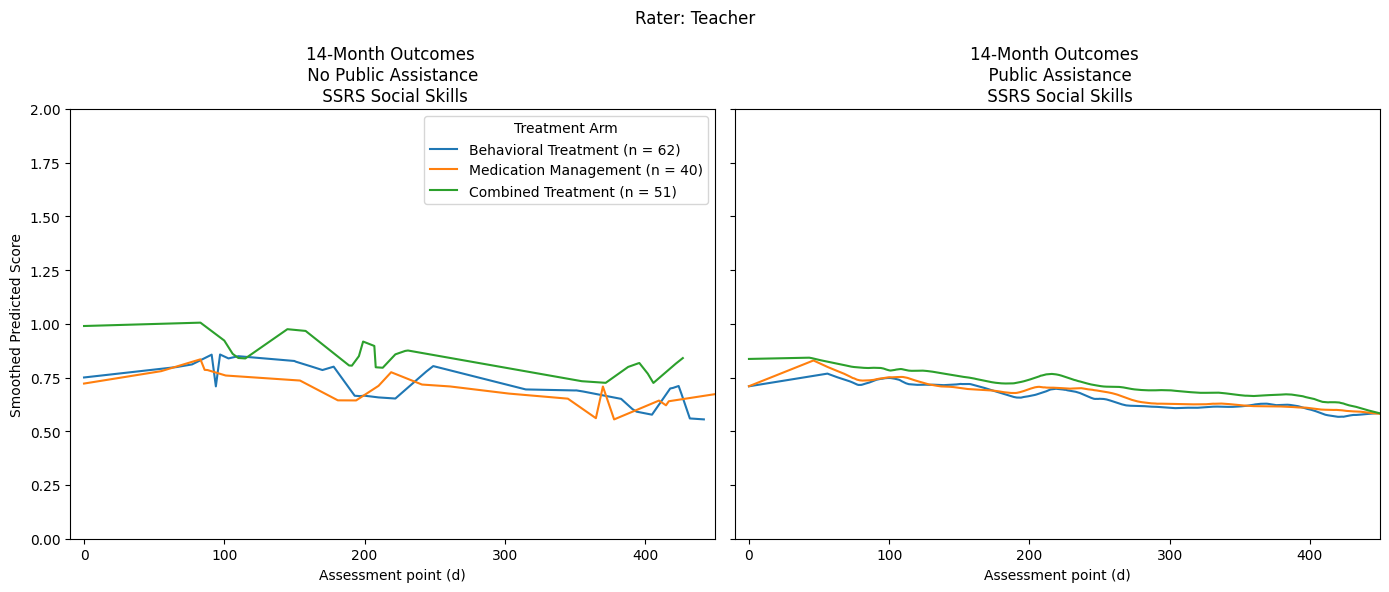

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


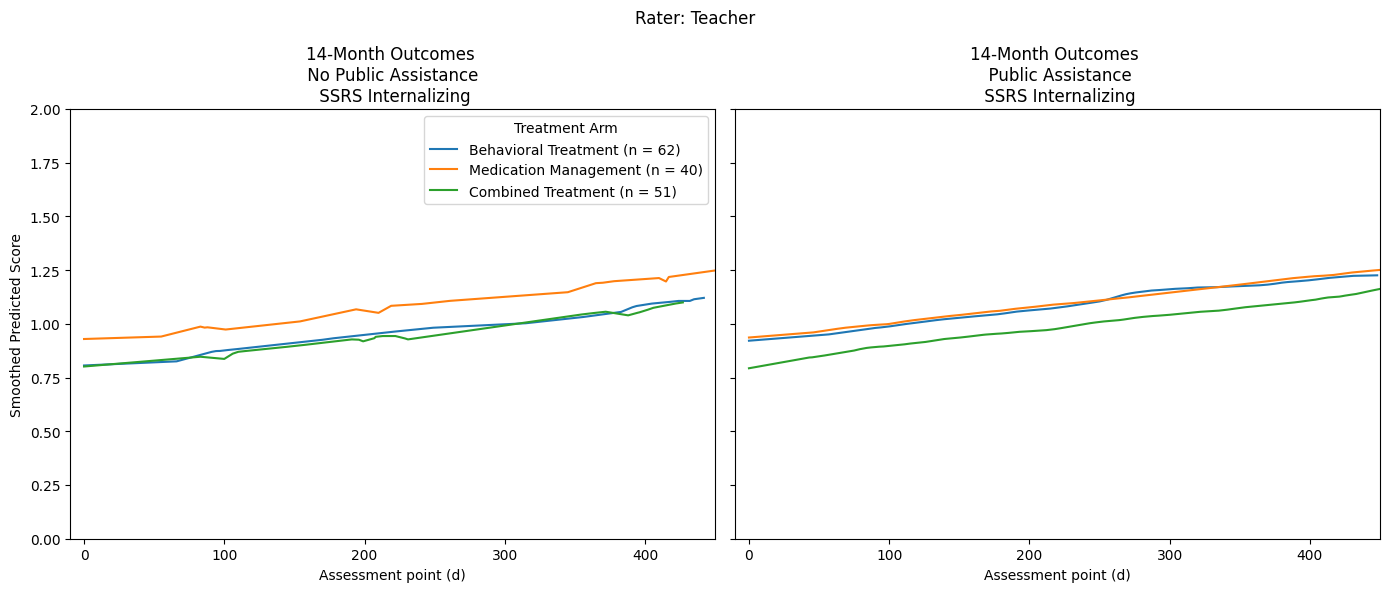

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


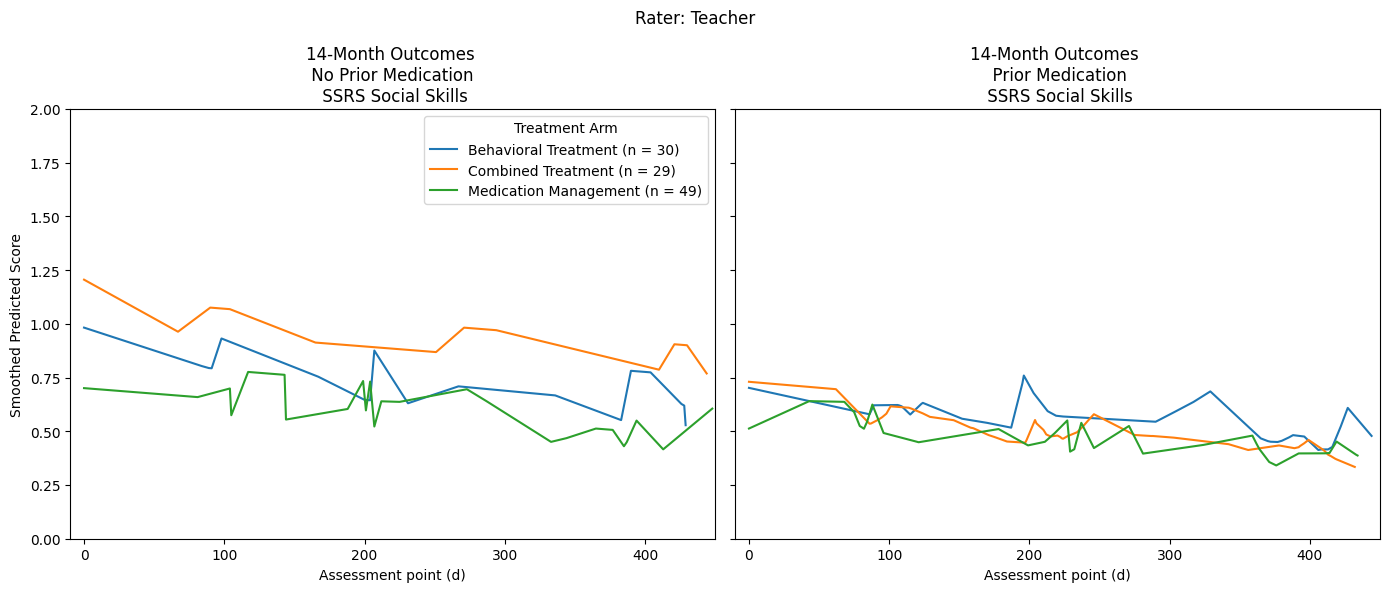

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


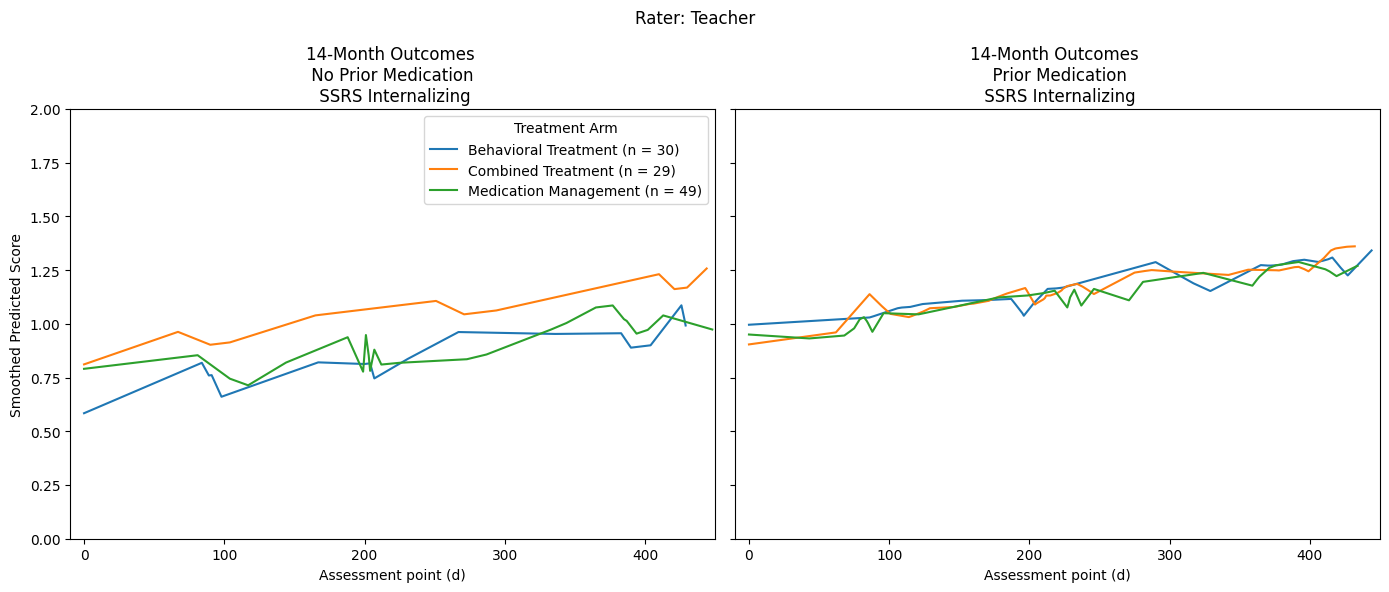

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


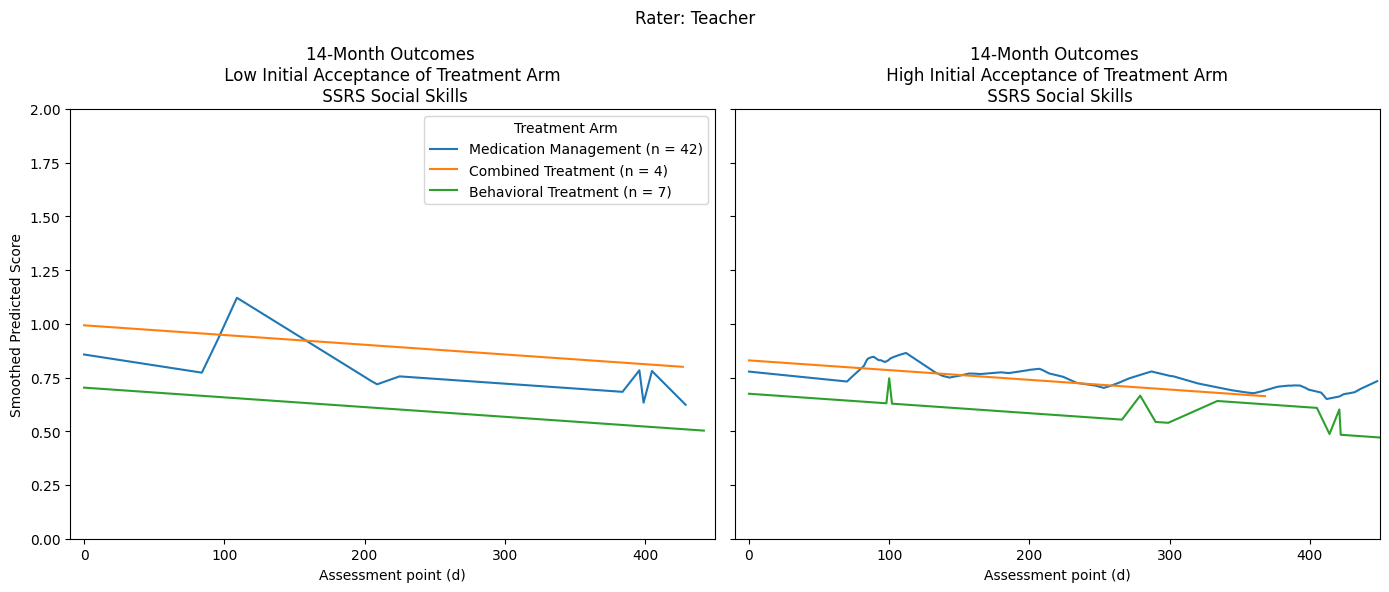

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


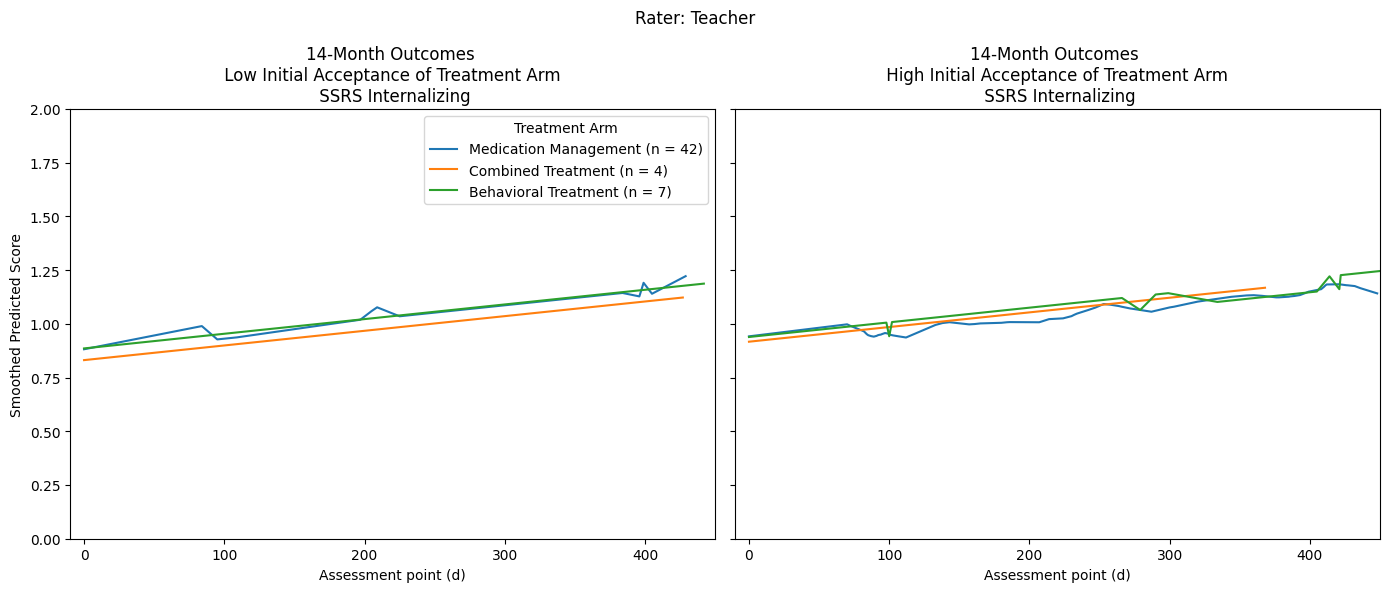

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


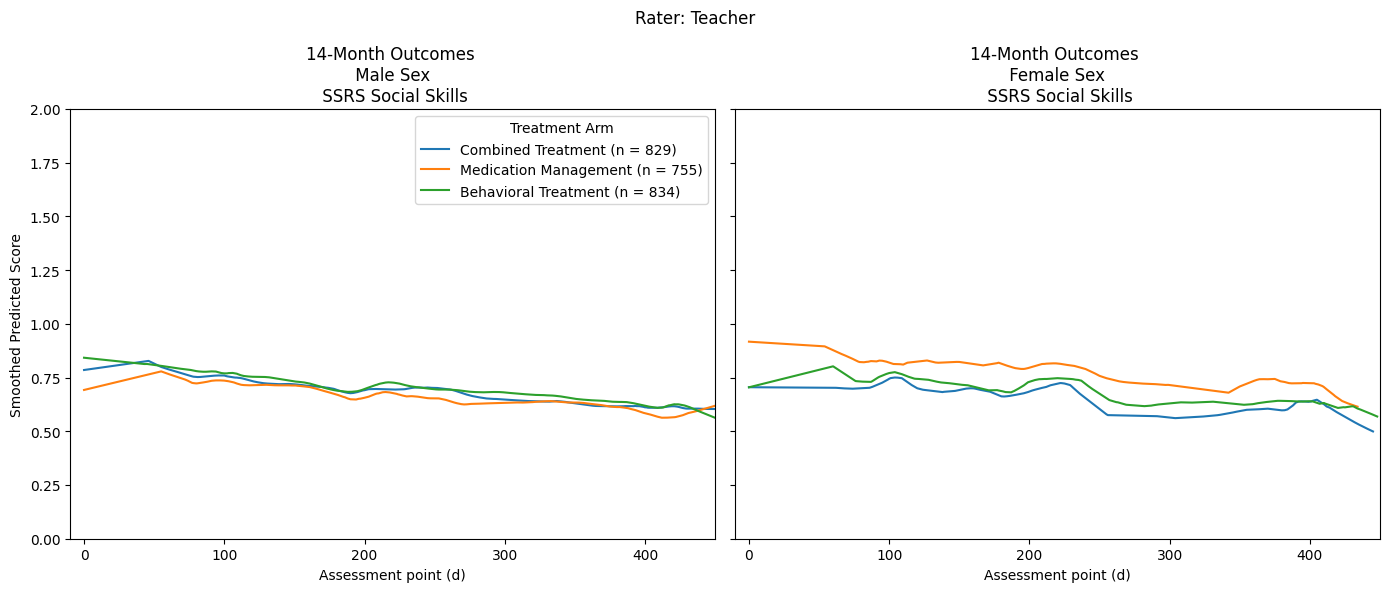

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


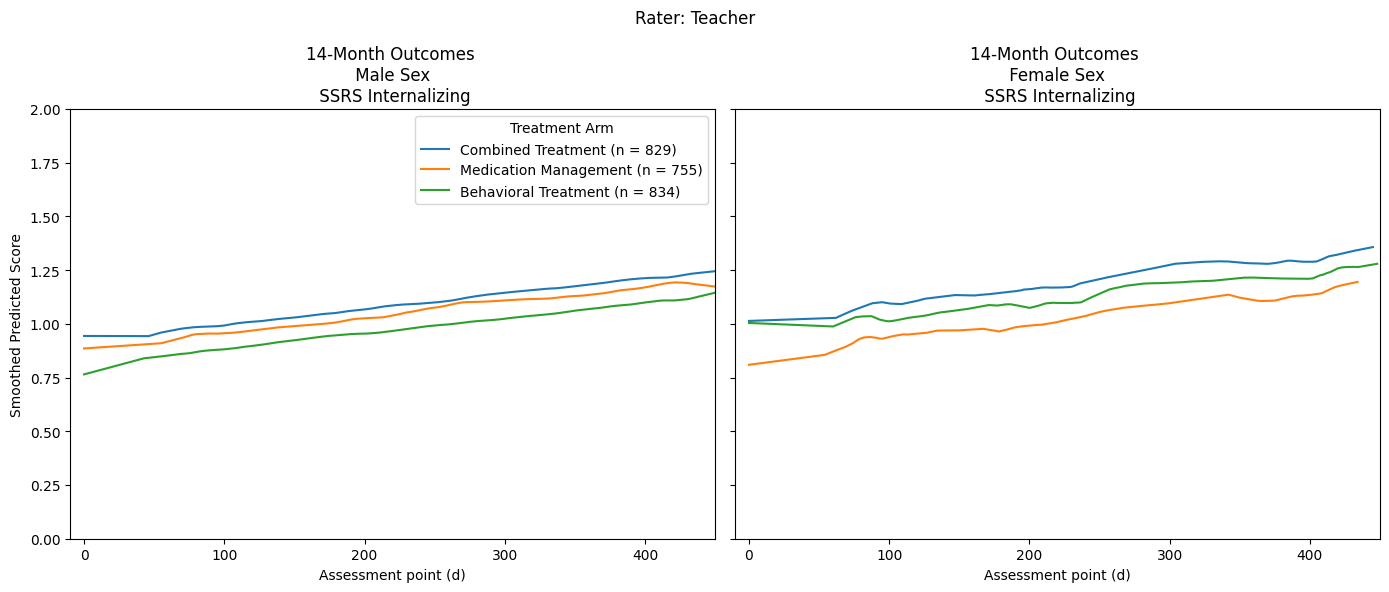

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


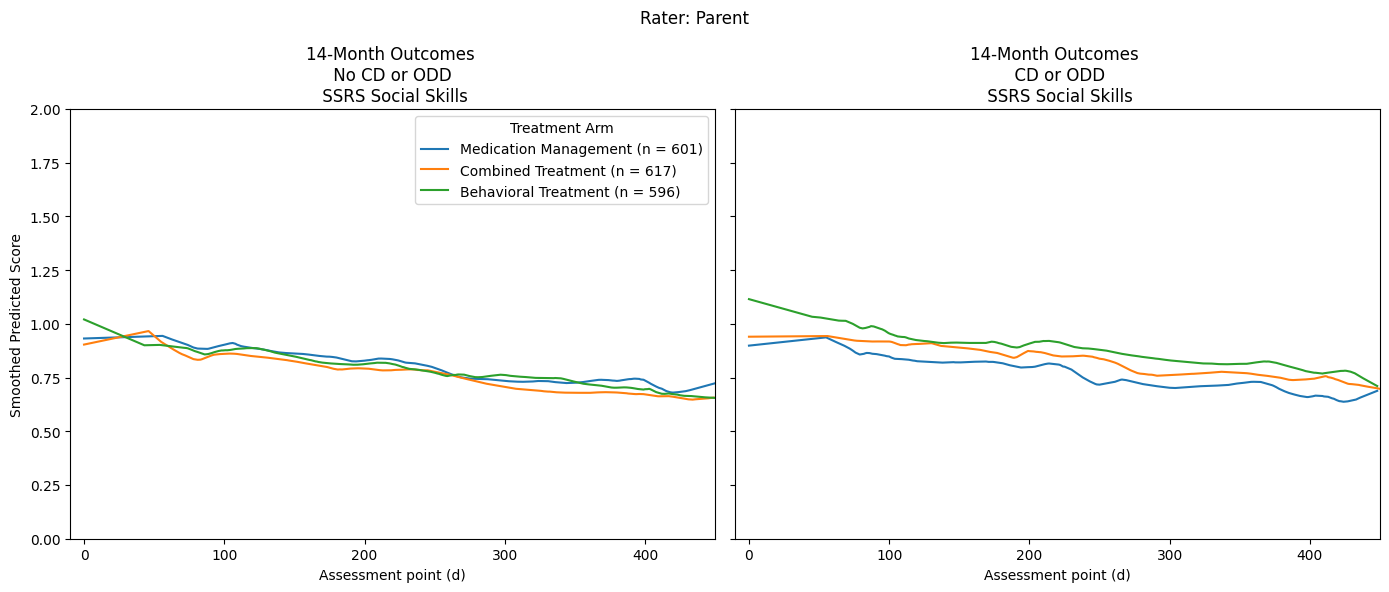

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


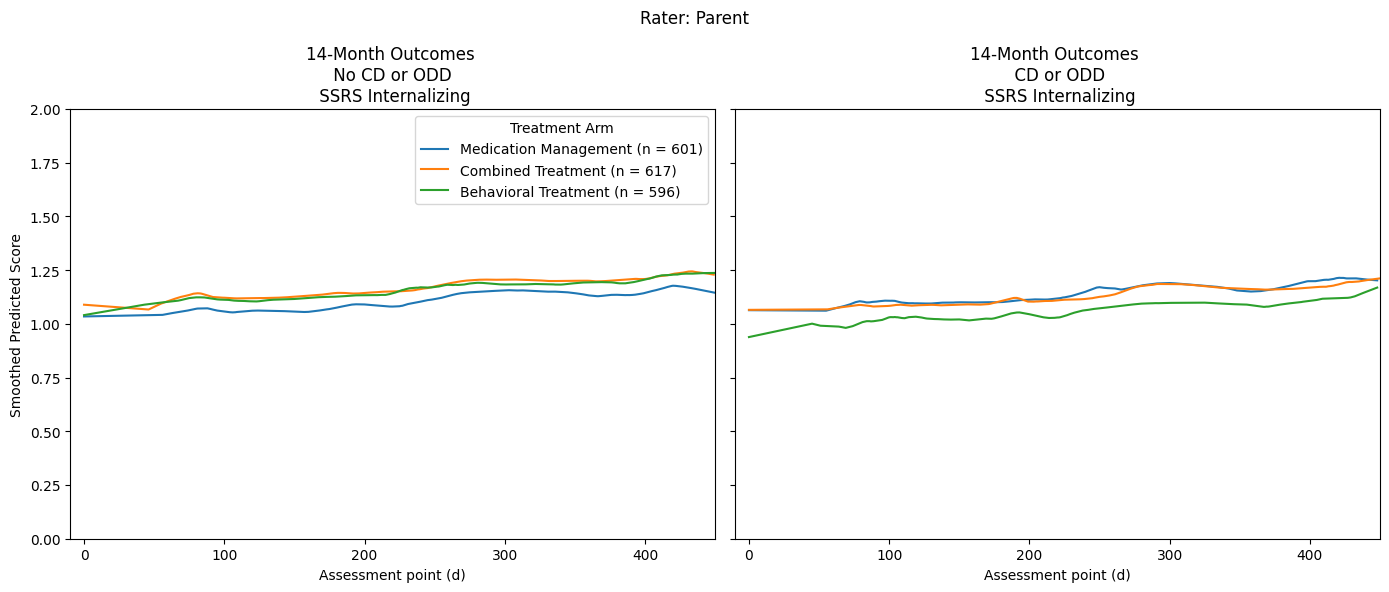

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


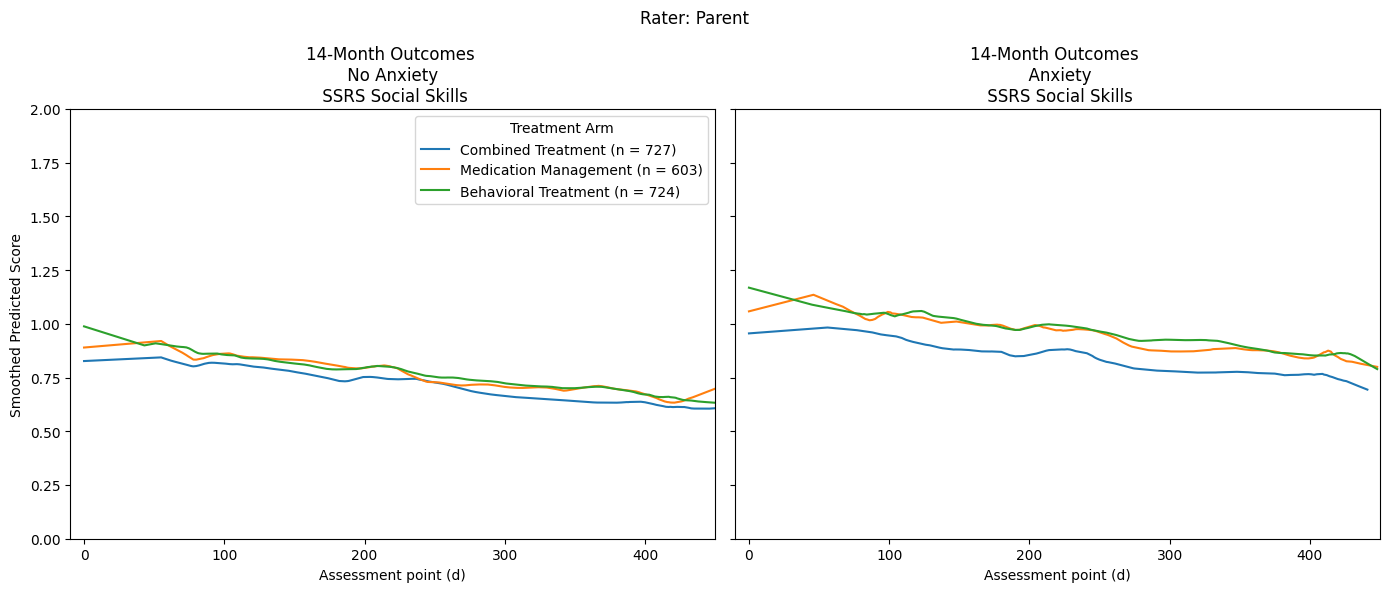

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


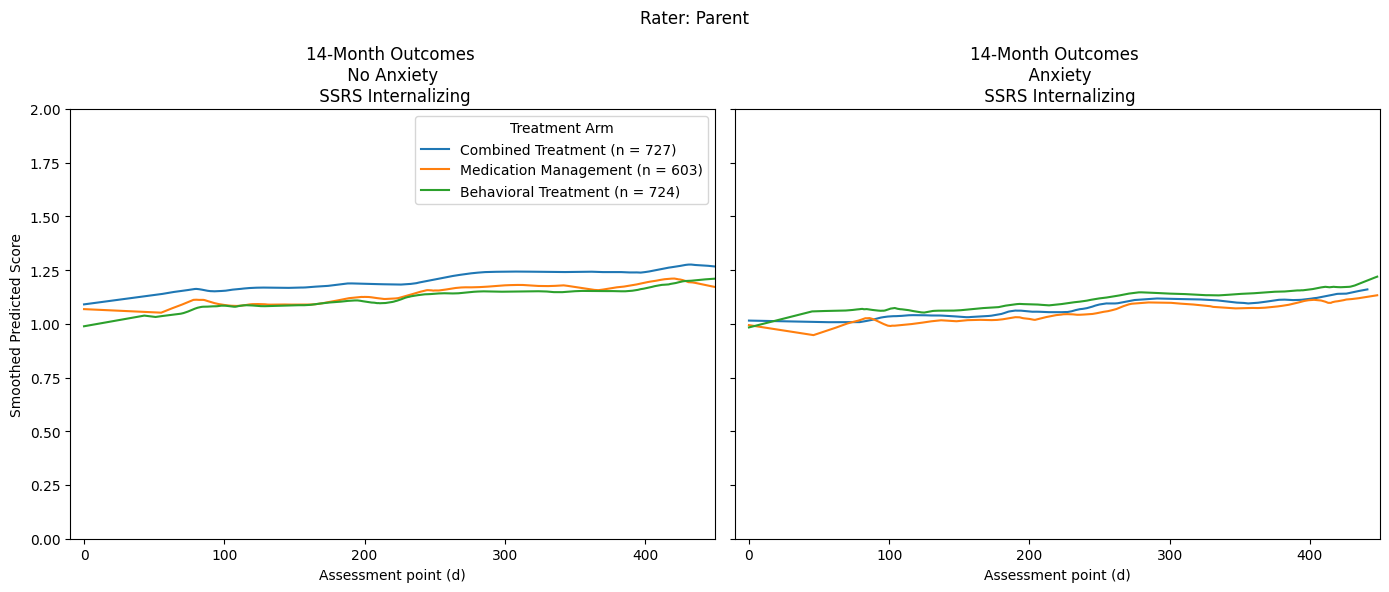

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


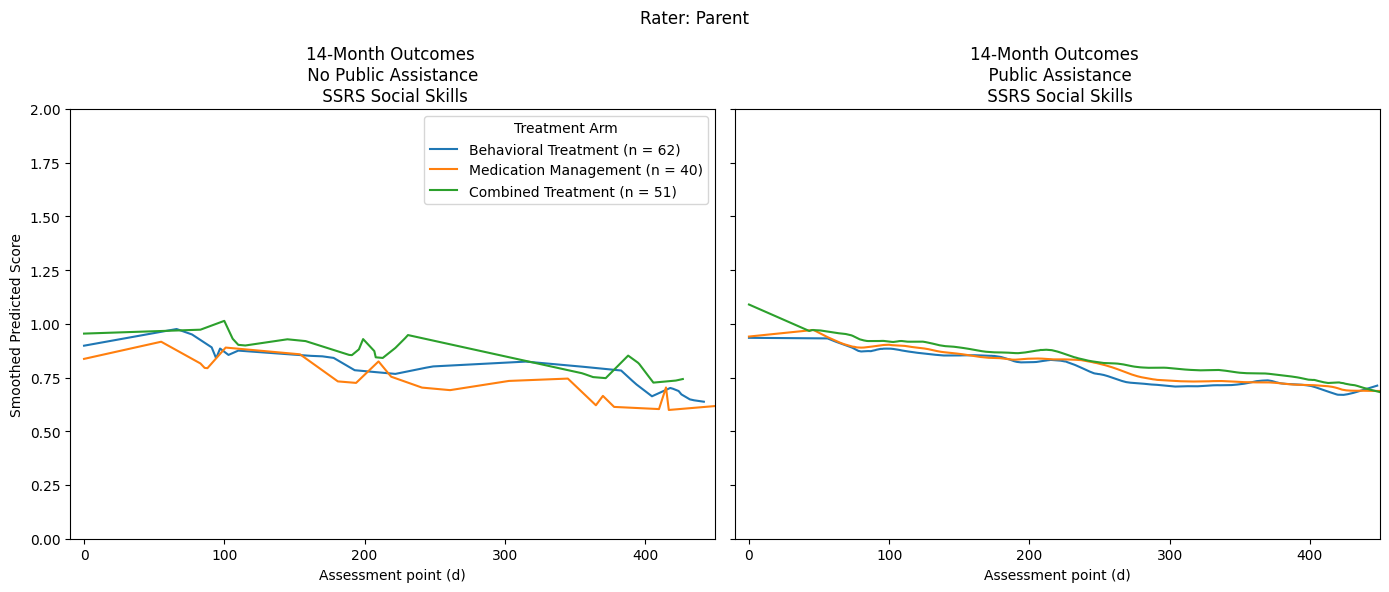

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


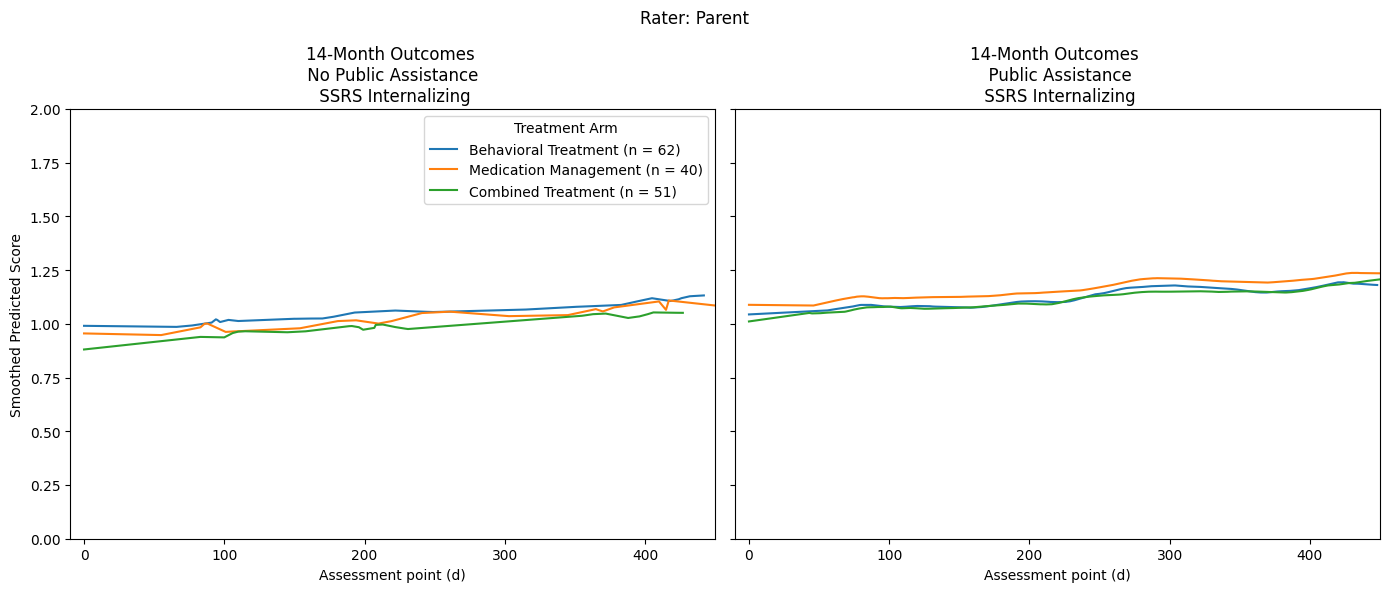

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


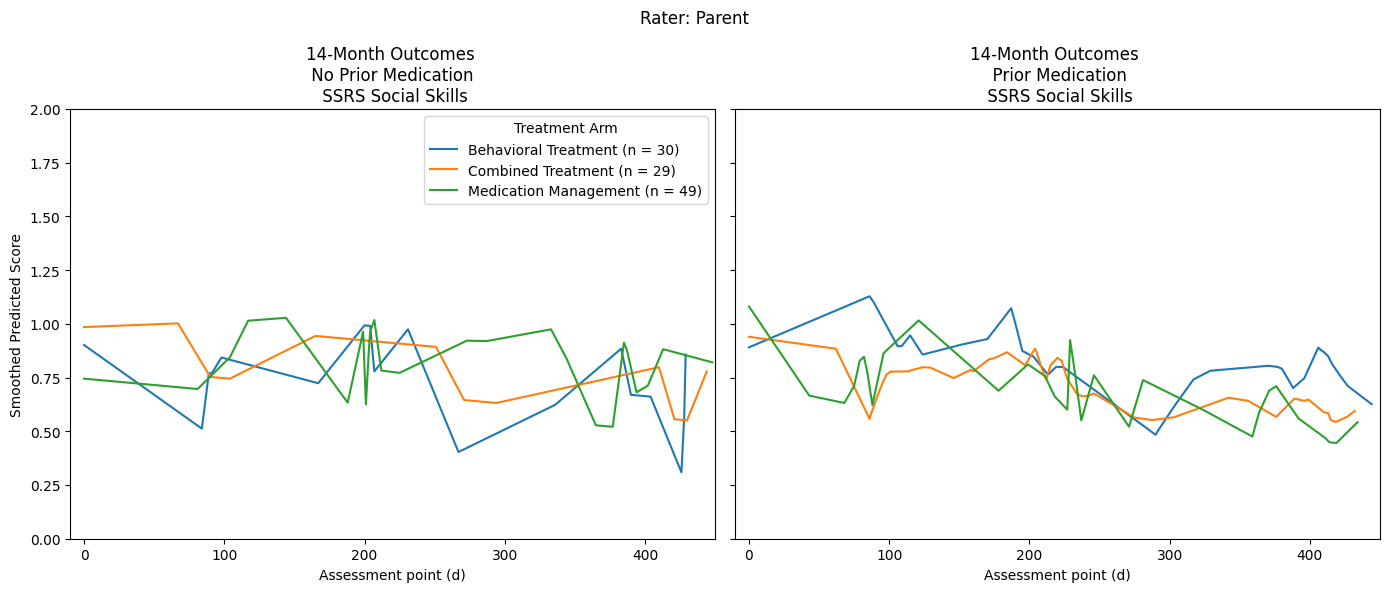

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


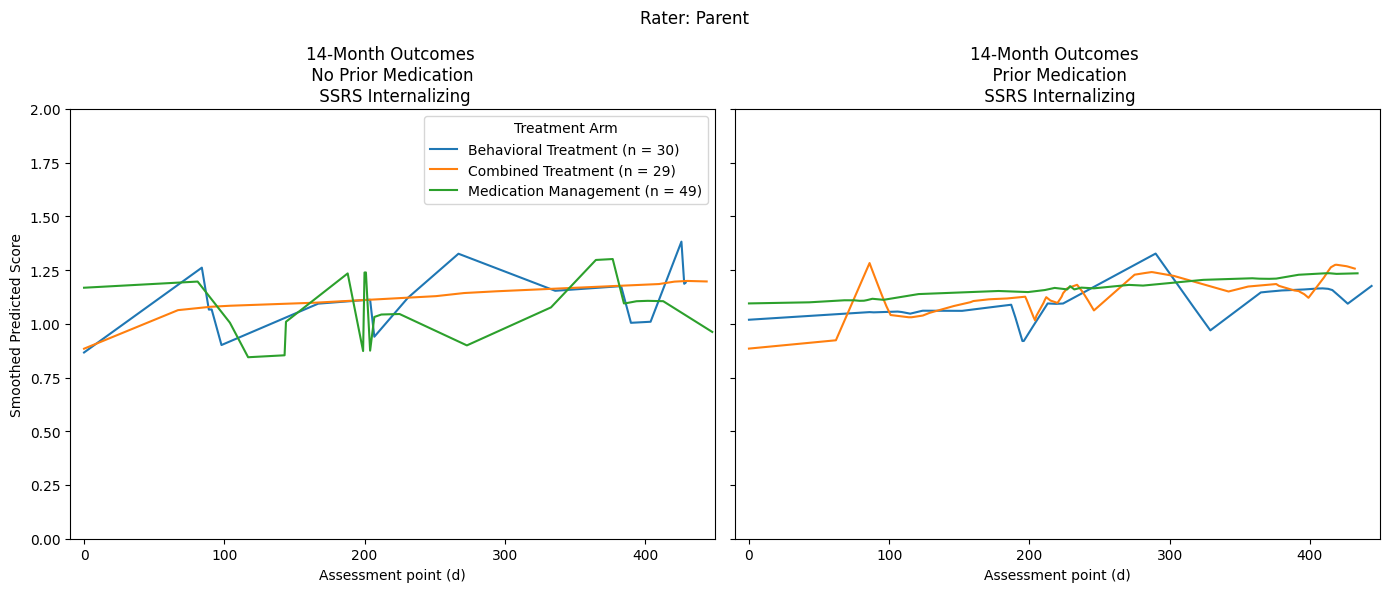

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


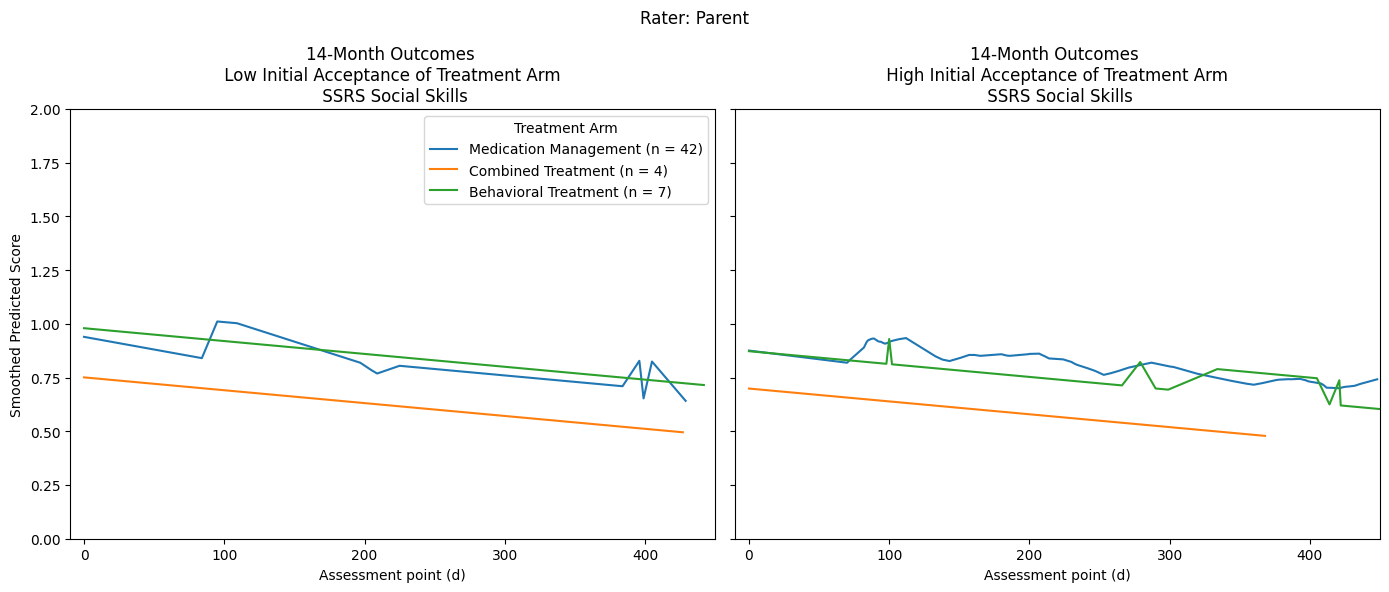

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


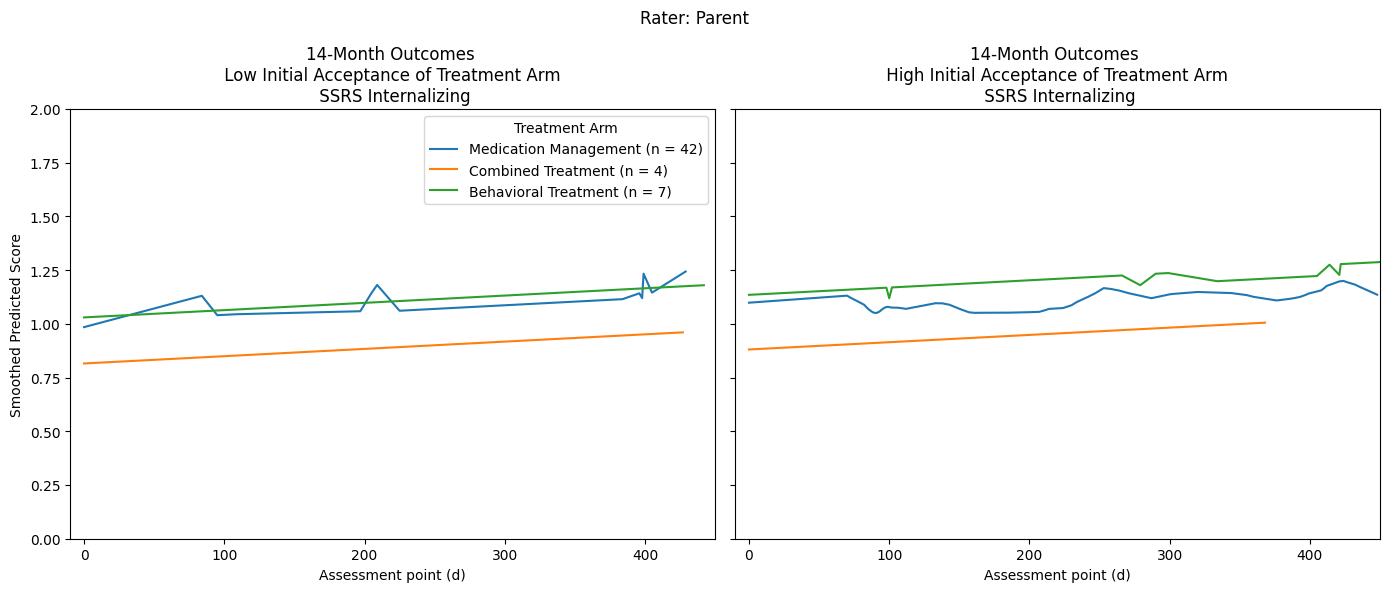

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


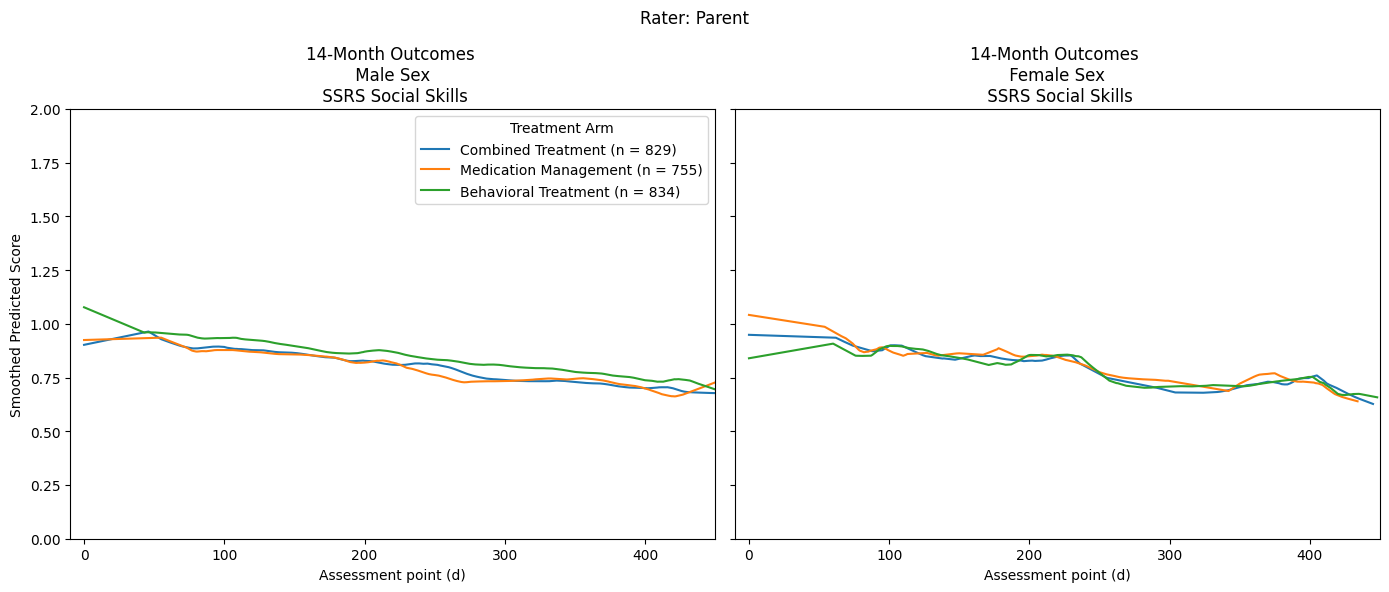

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


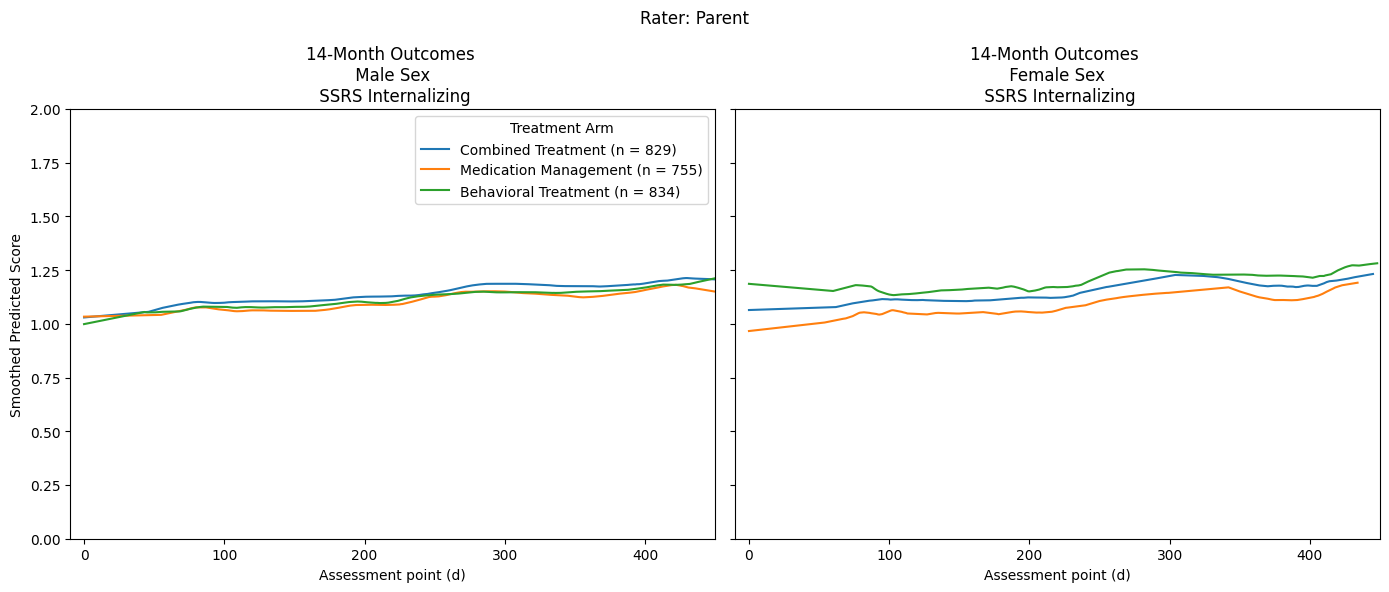

masc
{'cdorodd_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85360>, 'anx_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6174610>, 'demo61_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177df0>, 'hi_24_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177ee0>, 'd2dresp_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2185bd0>, 'sex_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2187310>}


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


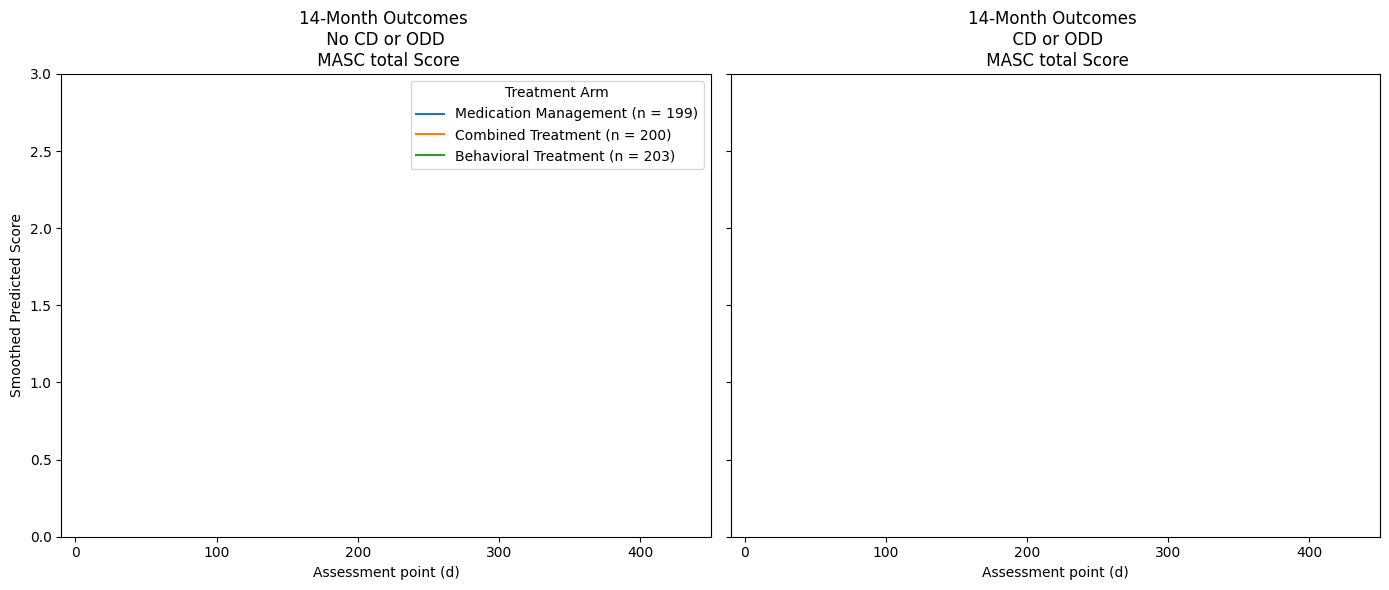

masc
{'cdorodd_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85360>, 'anx_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6174610>, 'demo61_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177df0>, 'hi_24_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177ee0>, 'd2dresp_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2185bd0>, 'sex_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2187310>}


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


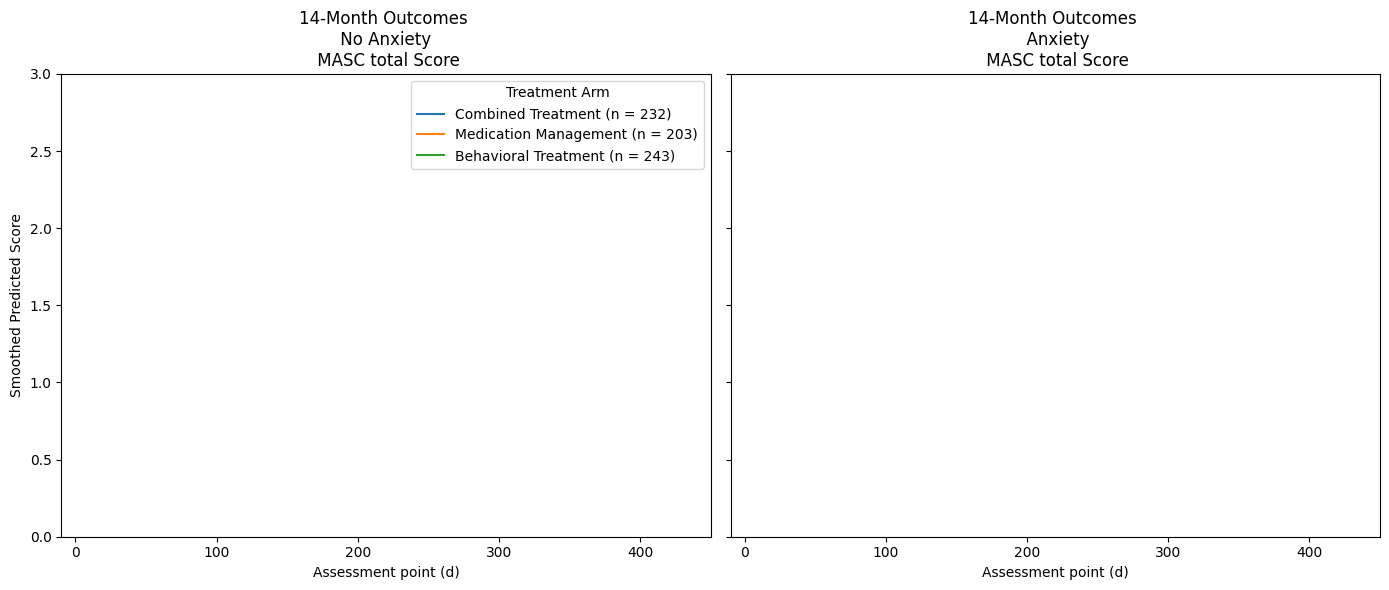

masc
{'cdorodd_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85360>, 'anx_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6174610>, 'demo61_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177df0>, 'hi_24_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177ee0>, 'd2dresp_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2185bd0>, 'sex_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2187310>}


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


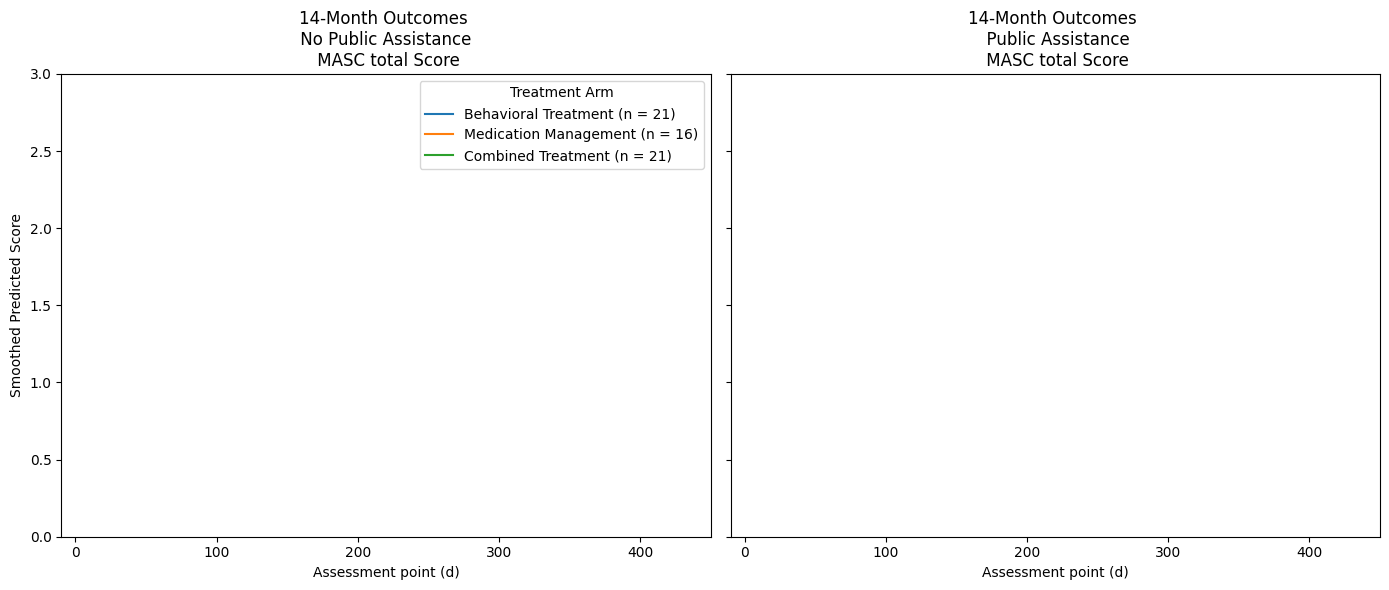

masc
{'cdorodd_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85360>, 'anx_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6174610>, 'demo61_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177df0>, 'hi_24_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177ee0>, 'd2dresp_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2185bd0>, 'sex_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2187310>}


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


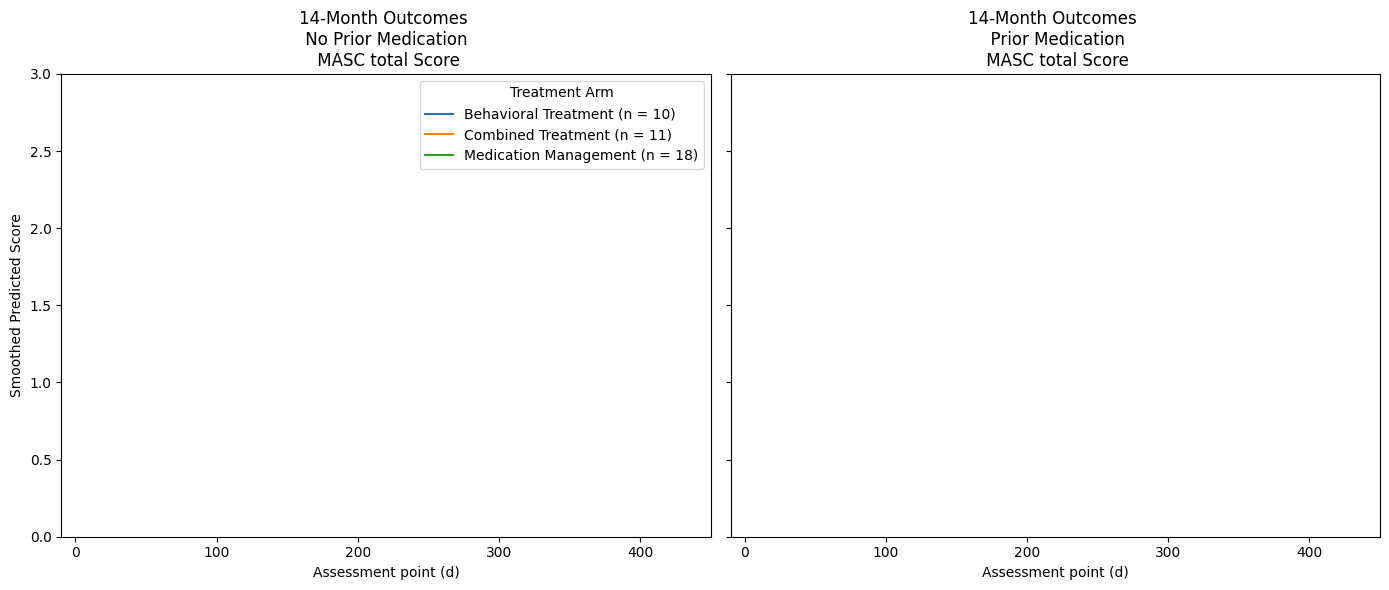

masc
{'cdorodd_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85360>, 'anx_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6174610>, 'demo61_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177df0>, 'hi_24_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177ee0>, 'd2dresp_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2185bd0>, 'sex_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2187310>}


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


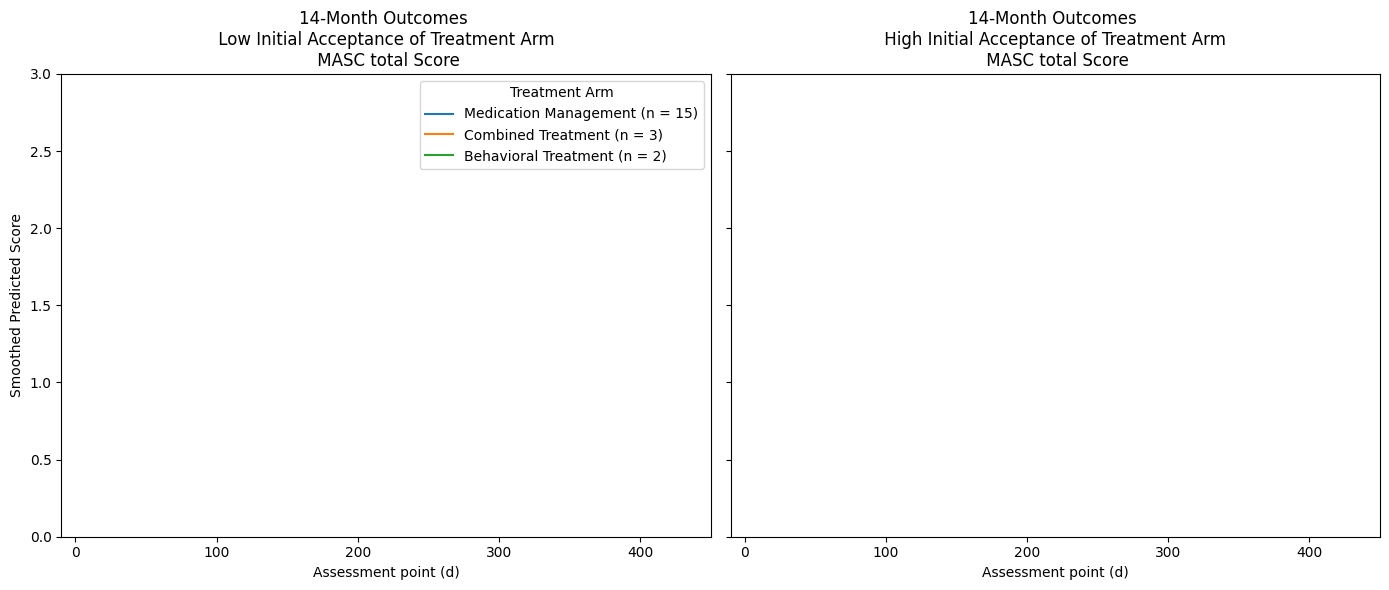

masc
{'cdorodd_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85360>, 'anx_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6174610>, 'demo61_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177df0>, 'hi_24_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc6177ee0>, 'd2dresp_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2185bd0>, 'sex_masc_masctotalt': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd2187310>}


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


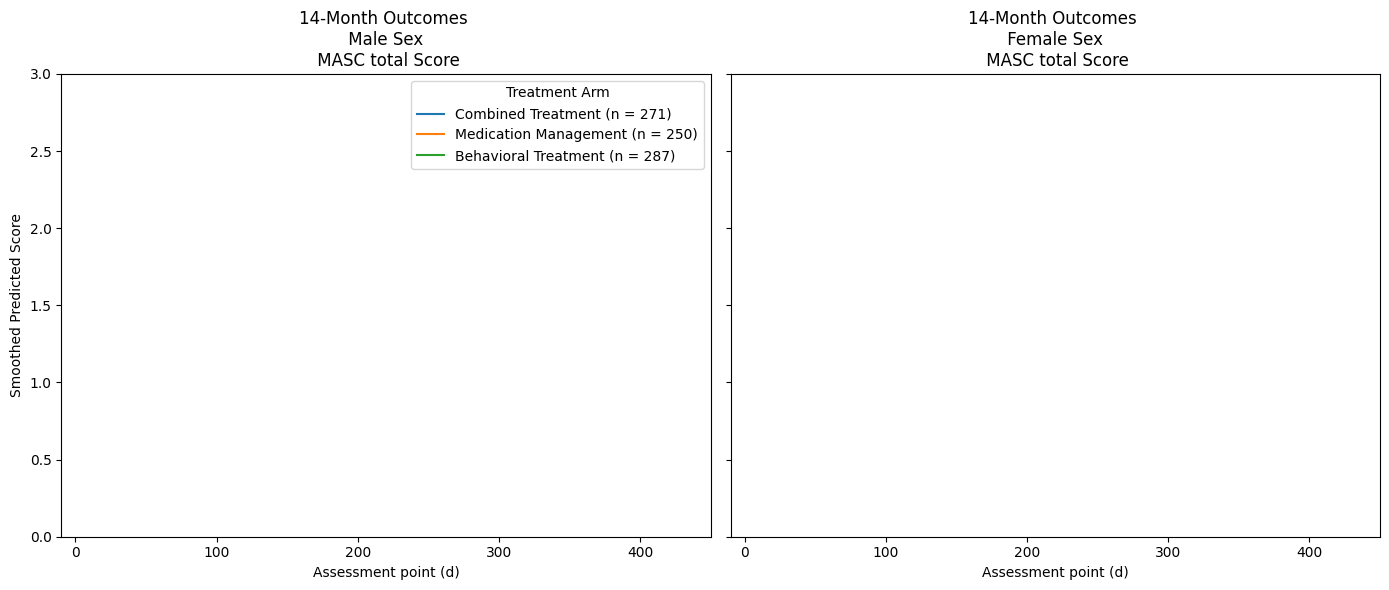

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


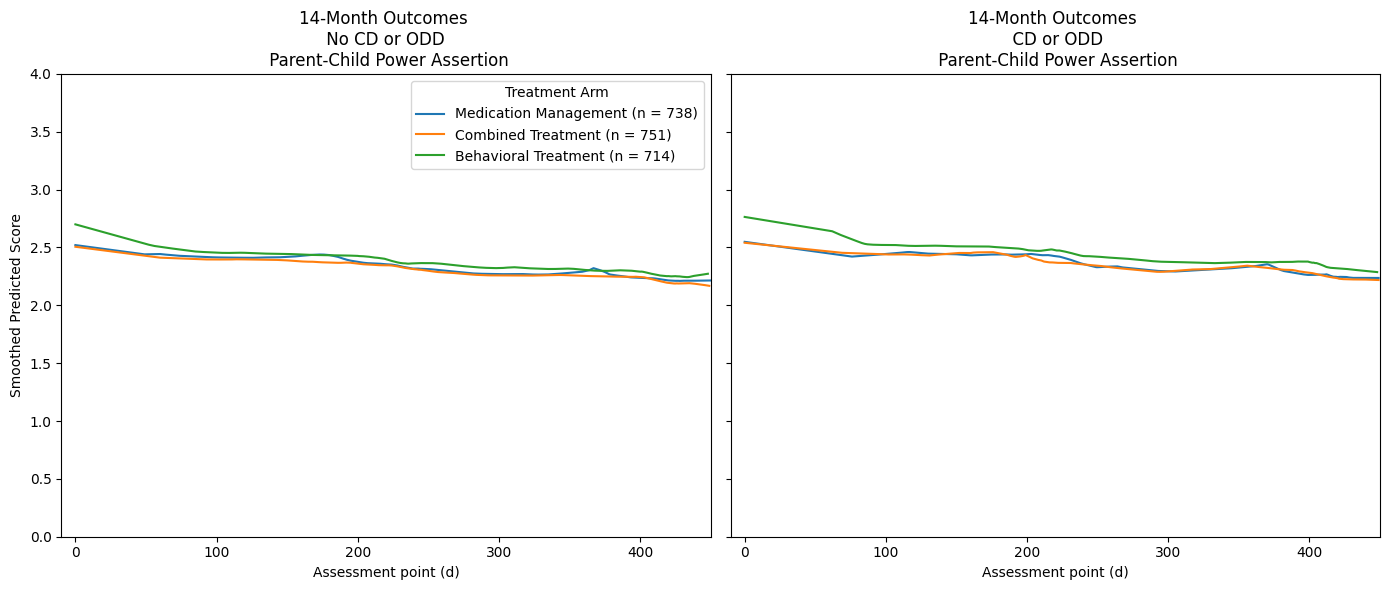

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


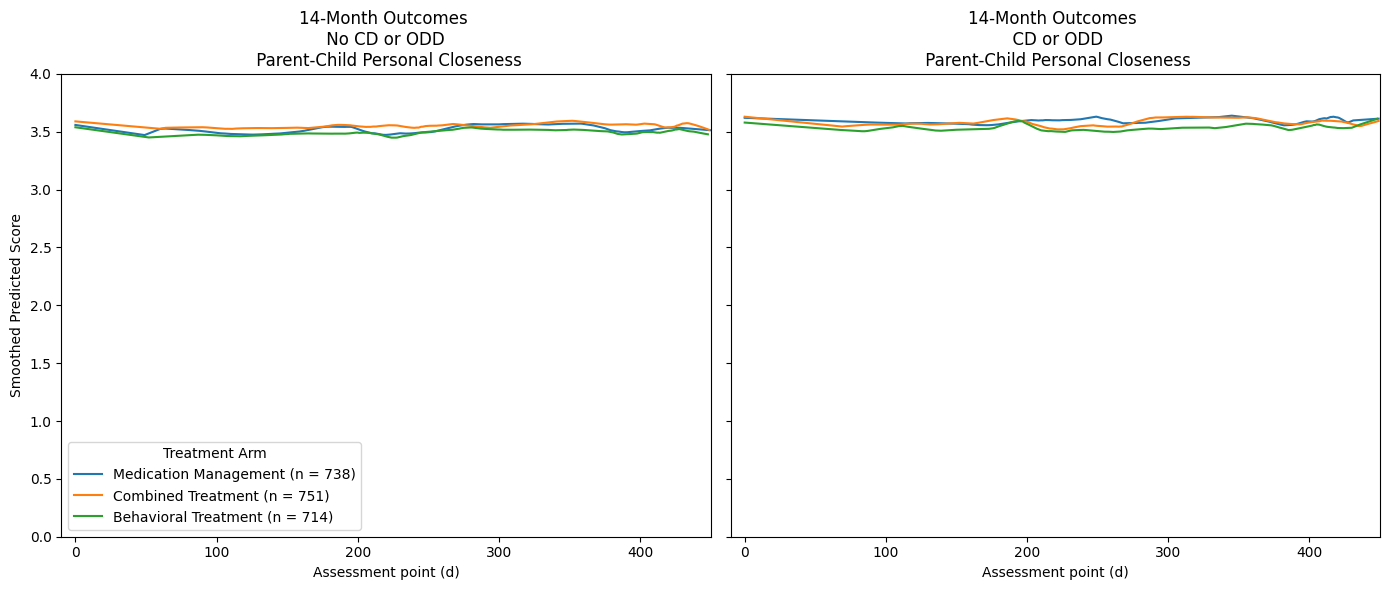

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


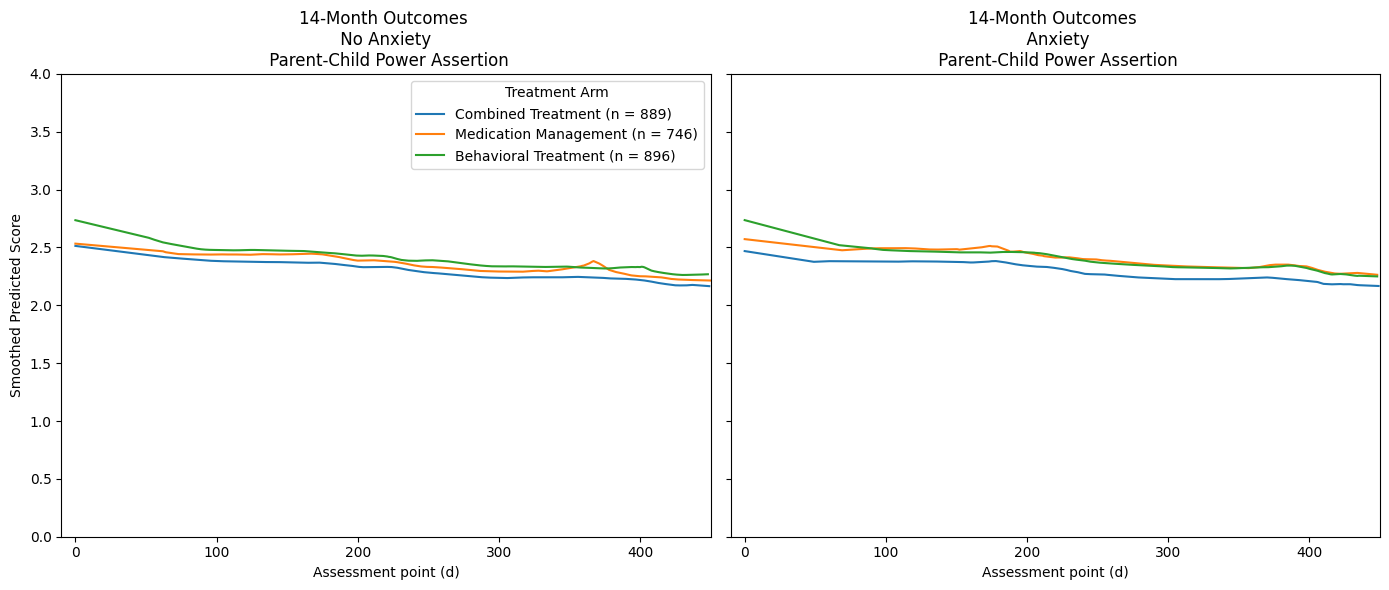

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


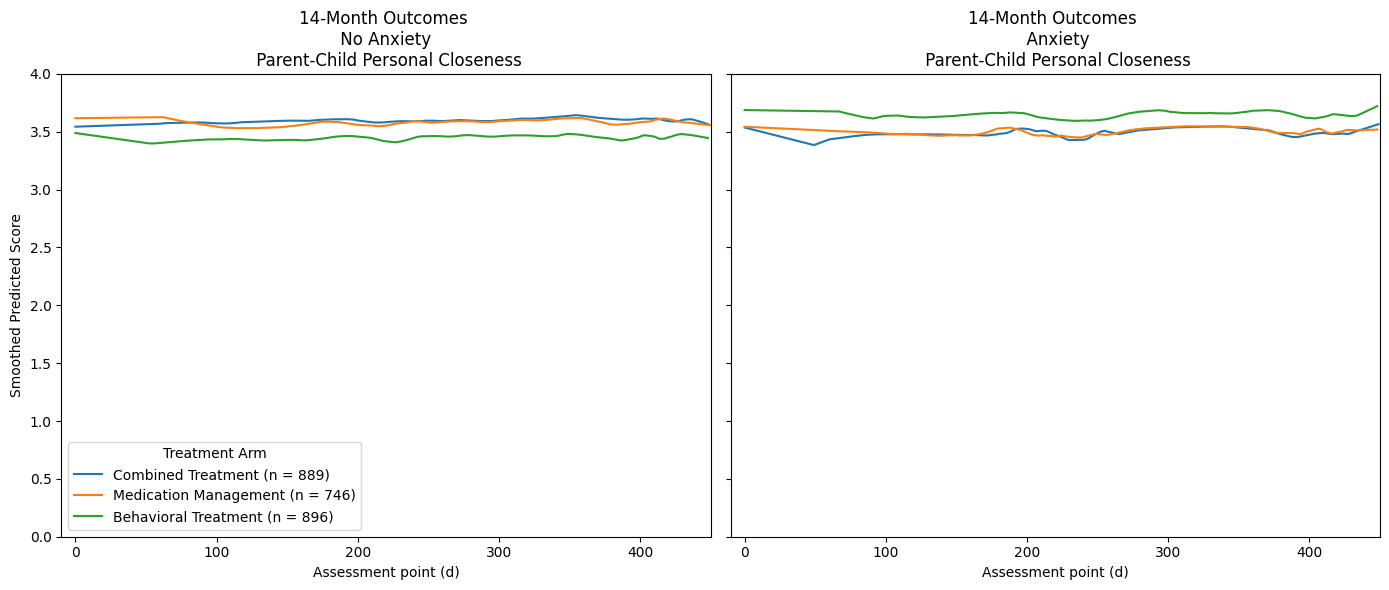

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


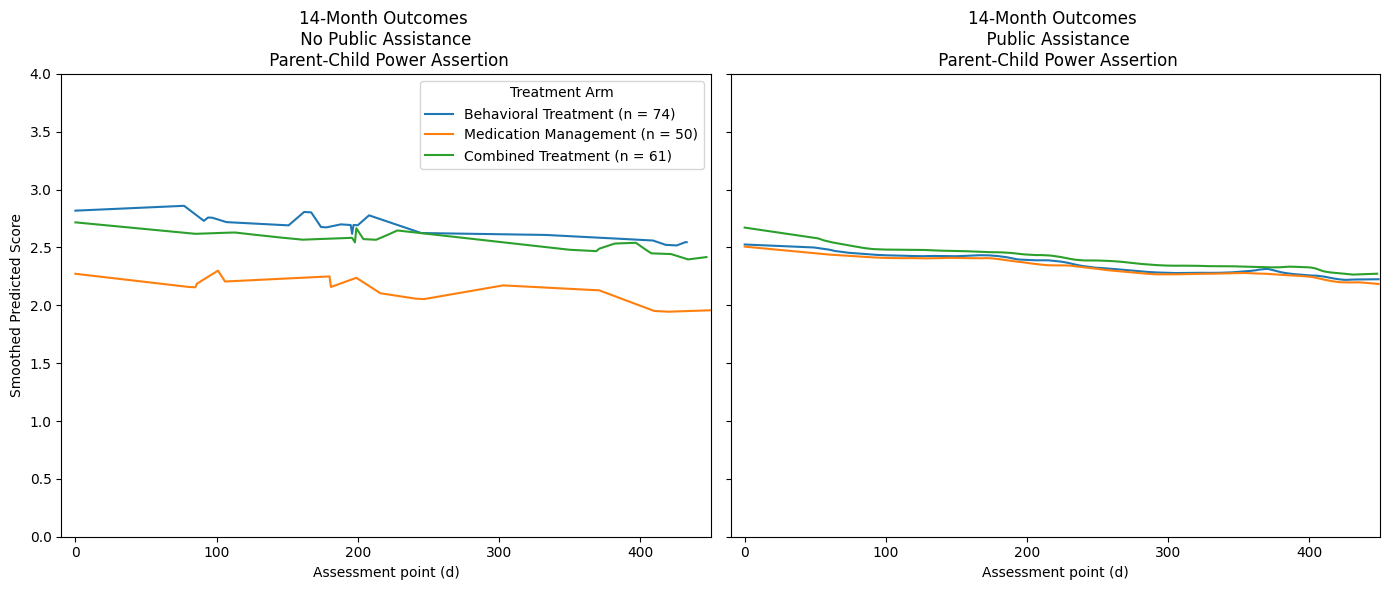

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


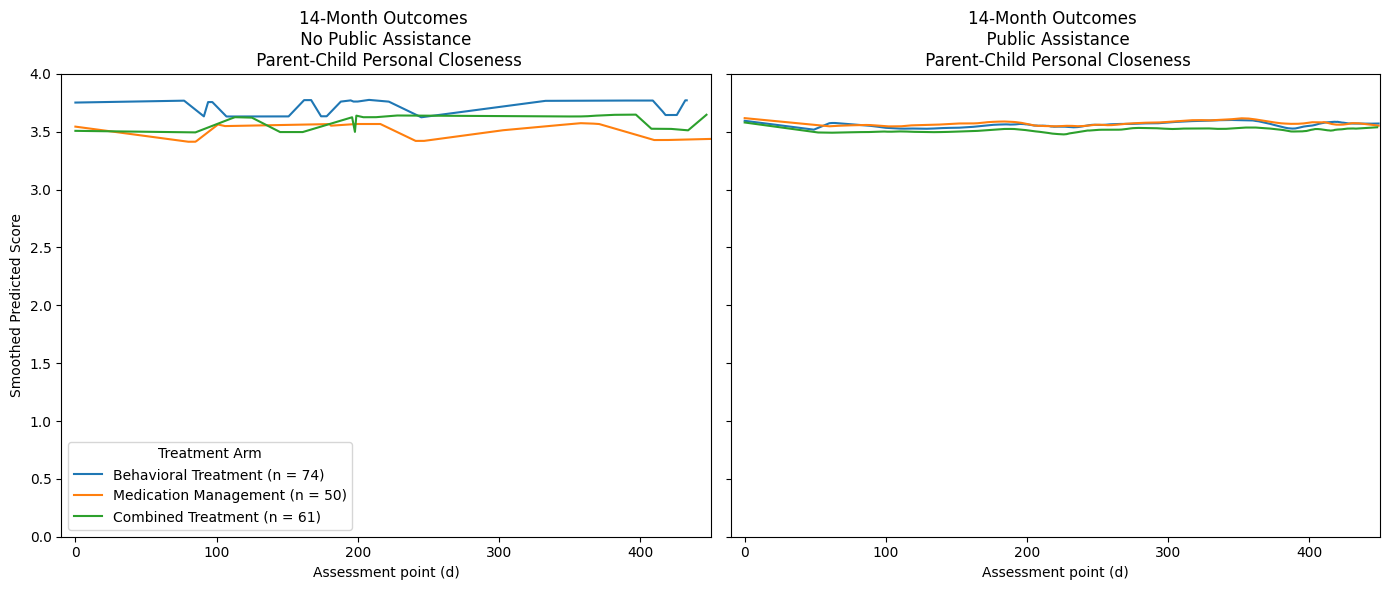

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


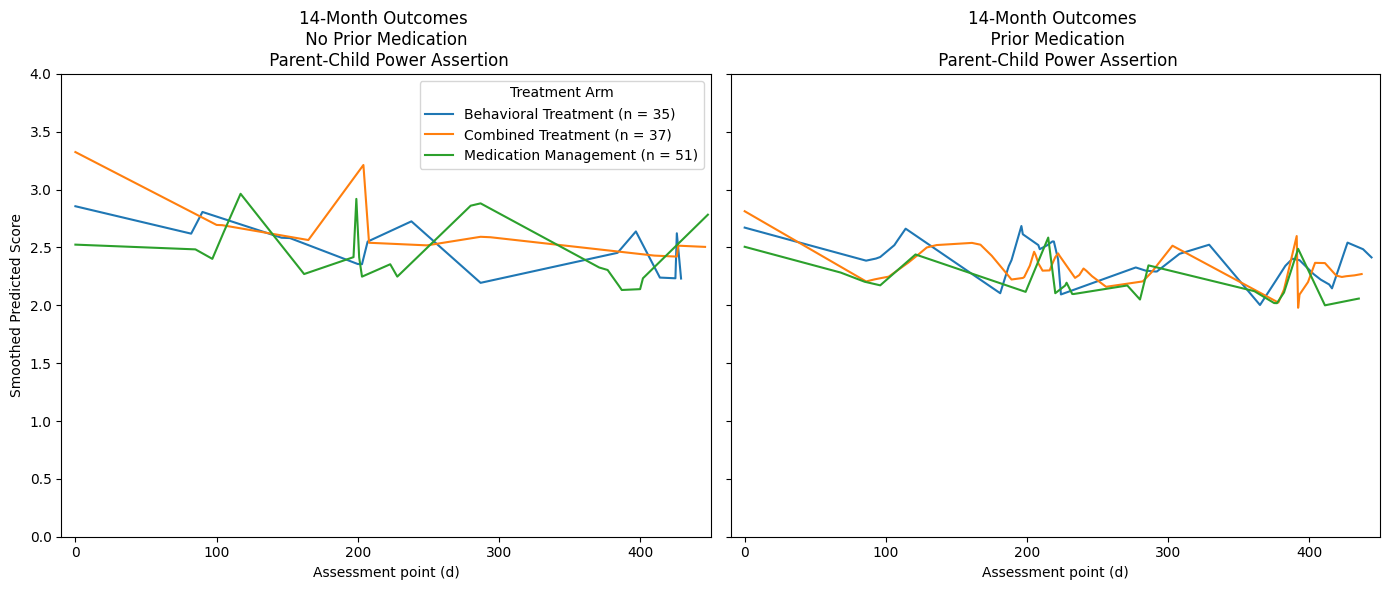

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


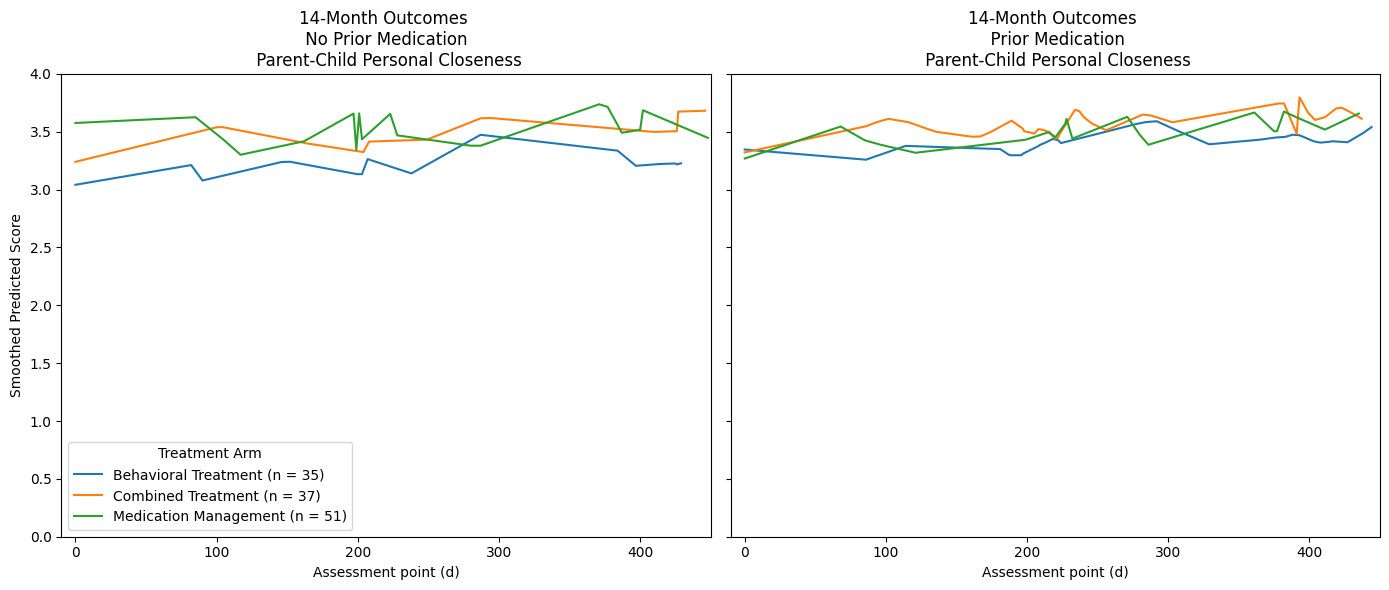

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


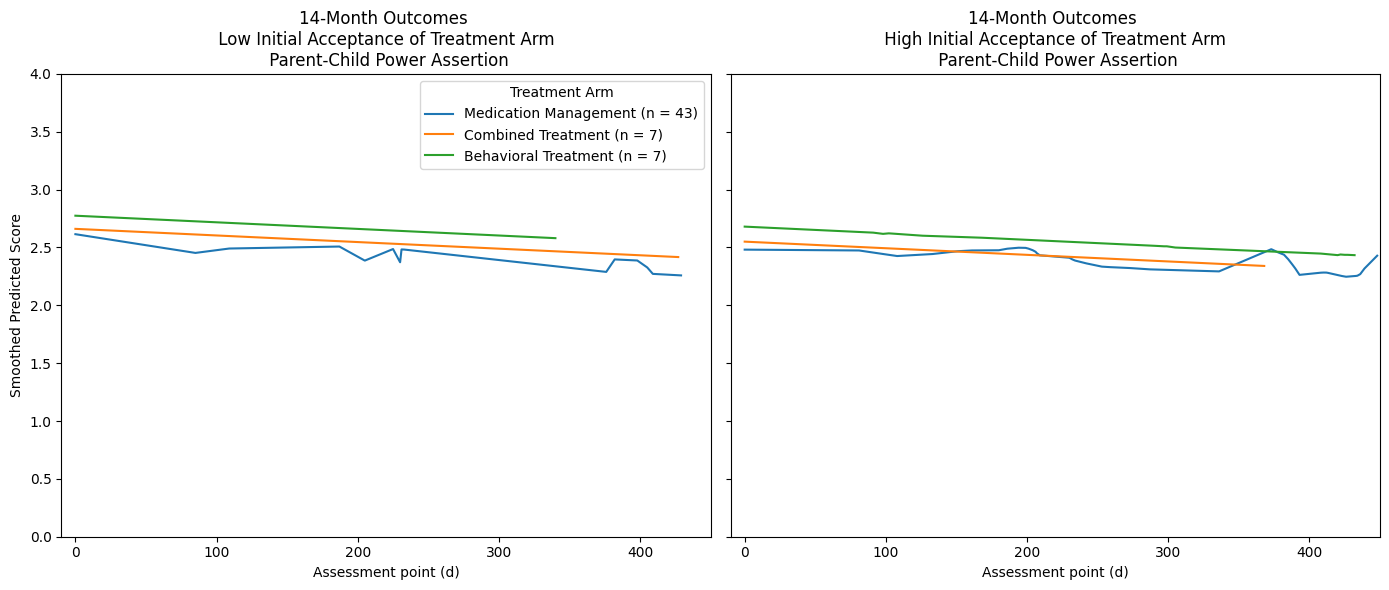

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


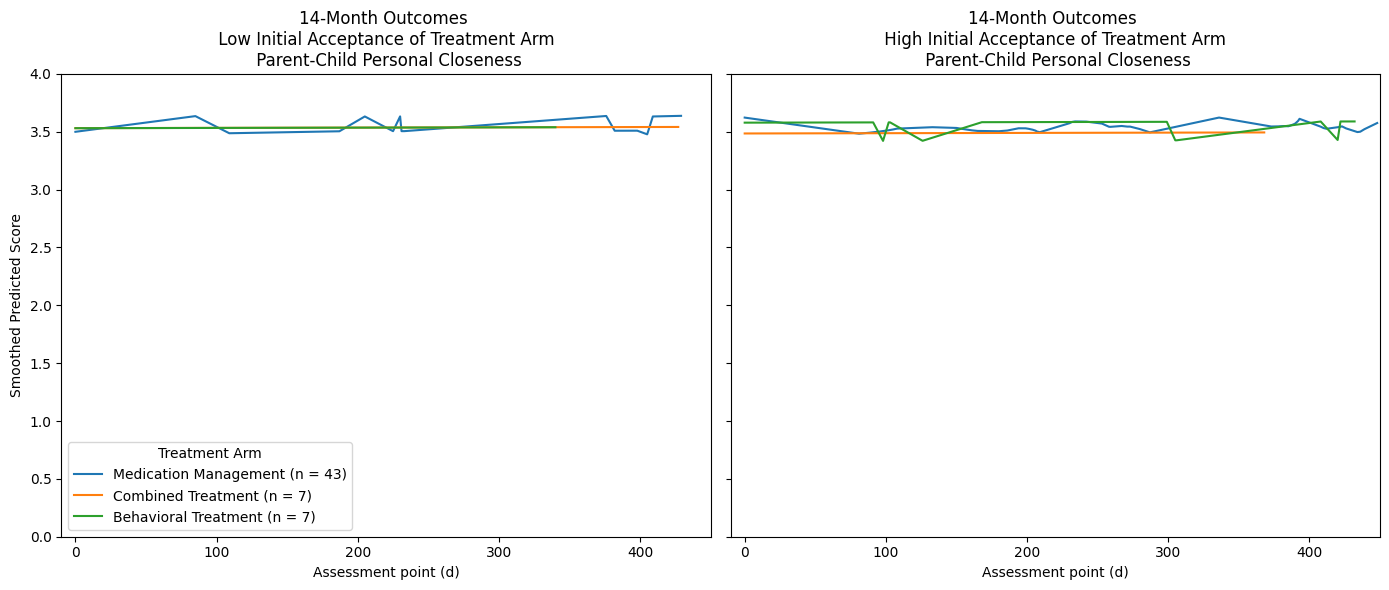

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


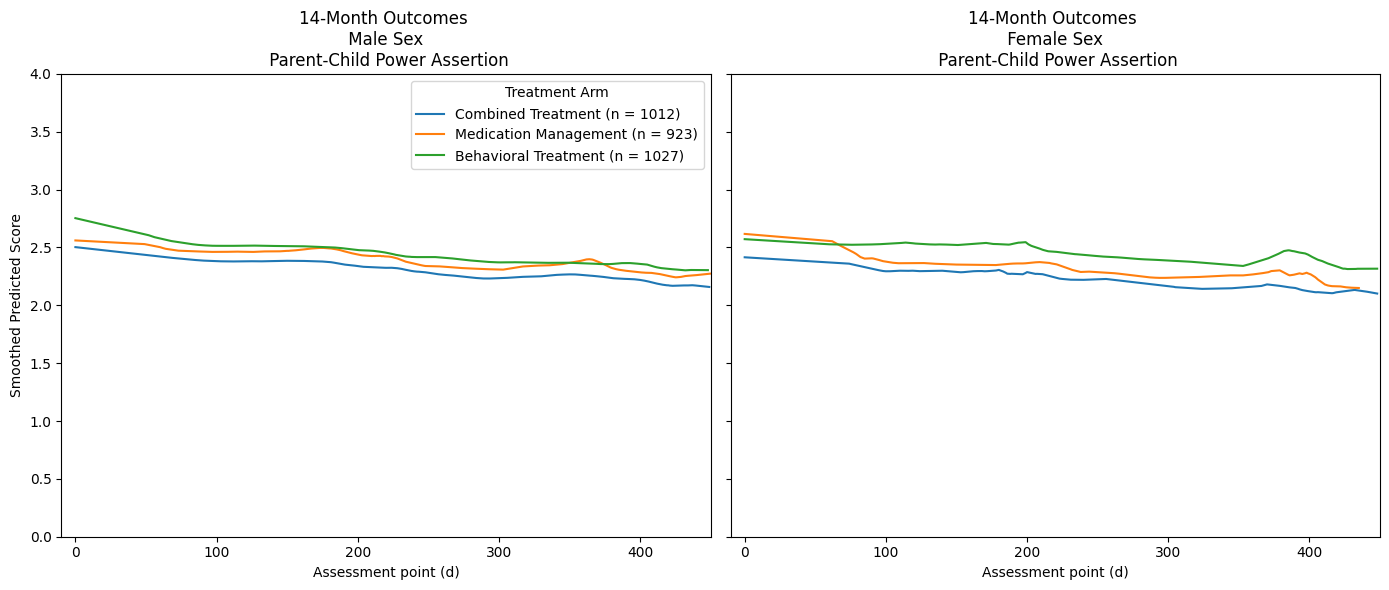

pc
{'cdorodd_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7fa0>, 'cdorodd_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e7f10>, 'anx_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fd21e4e80>, 'anx_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5f85300>, 'demo61_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fa2d59660>, 'demo61_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50c3400>, 'hi_24_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc5094a90>, 'hi_24_pcrcprx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a50c0>, 'd2dresp_pcrcpax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x7f7fc50a68f0>, 'd2dresp_pc

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


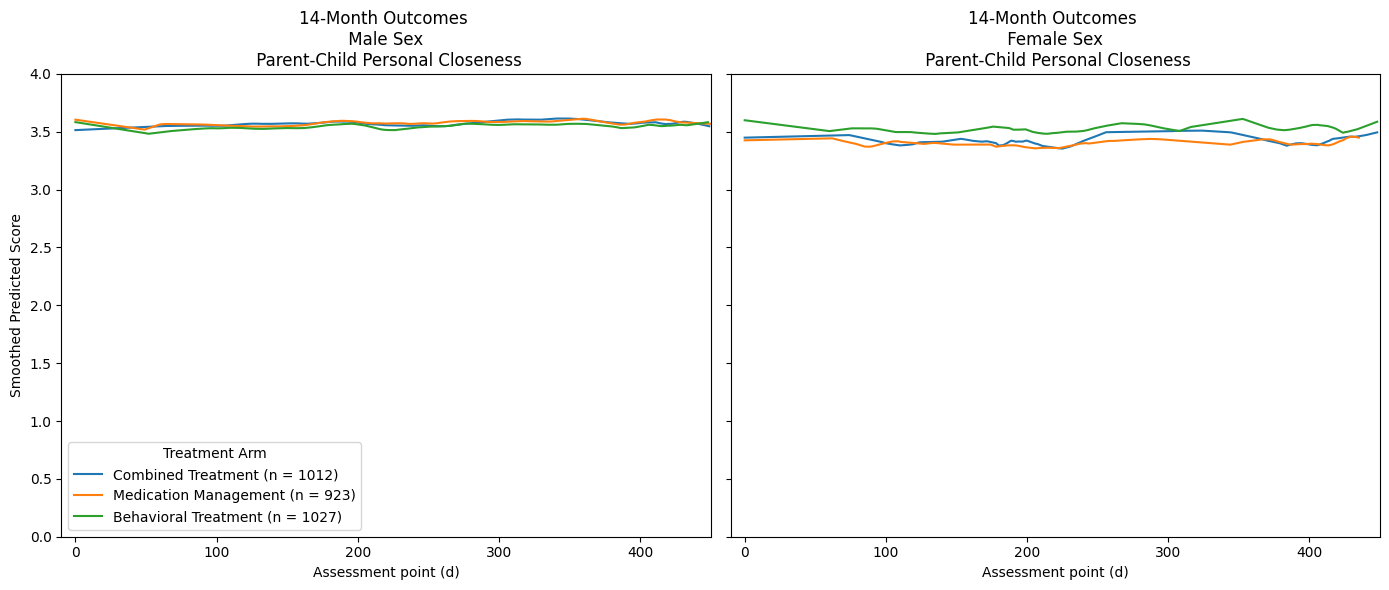

In [195]:
for qst in qsts:
    if qst == 'snap' or qst == 'ssrs':
        for rater in raters:
            for key in results[qst][rater].keys():
                if key.startswith('hi'):
                    var_mod = split_on_occurrence(key, '_', 2)[0]
                    var_out= split_on_occurrence(key, '_', 2)[1]
                else: 
                    var_mod = key.split('_')[0]
                    var_out =  key.split('_')[1]

                title = [rater + '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 

                data = data_dict[qst]
                result = results[qst][rater]
                plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, save_path=save_path)

    else: 
        for key in results[qst].keys():
            print(qst)
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
                var_out= split_on_occurrence(key, '_', 2)[1]
            elif 'masc' in key:
                var_mod = split_on_occurrence(key, '_', 1)[0]
                var_out= split_on_occurrence(key, '_', 1)[1]
            else:
                var_mod = key.split('_')[0]
                var_out =  key.split('_')[1]
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
            data = data_dict[qst]
            result = results[qst]
            print(result)

            plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], save_path=save_path)
           



 

In [152]:
outcomes

array(['snainatx', 'snahypax', 'snaoddx', 'sspintx', 'ssptossx',
       'masc_masctotalt', 'pcrcpax', 'pcrcprx'], dtype='<U15')

In [153]:
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [ ]:
to_plot = [['snahypax', 'anx'],[]